In [1]:
import fitz  # PyMuPDF
import pandas as pd
import numpy as np
import re
import os
from PIL import Image
import io
import matplotlib.pyplot as plt

In [2]:
pdf_file = '/Users/rodrigocarrillo/Library/CloudStorage/OneDrive-EmoryUniversity/Natural Language Processing Projects/Examen Residentado Peru/CONAREME/Year2018/GINECOLOGIA Y OBSTETRICIA.pdf'

In [3]:
def extract_questions(pdf_path):
    doc = fitz.open(pdf_path)
    questions_data = []  # List to store questions

    # Updated regular expression: handle questions with or without a '?'
    #question_pattern = re.compile(r"(\d+)\.\s(.*?)(?:\?)?\s*(?=A\.)", re.DOTALL)
    question_pattern = re.compile(r"(\d+)\.\s(.*?\??)\s*(?=A\.)", re.DOTALL)

    for page in doc:
        text = page.get_text("text")  # Extract full page text
        
        # Find all questions in the text using findall()
        questions = question_pattern.findall(text)
        
        # Append all the questions to the questions_data list
        for _, question in questions:
            questions_data.append(question.strip())  # Store the cleaned question text

    # Convert extracted questions to DataFrame
    questions_df = pd.DataFrame(questions_data, columns=["question"])
    return questions_df

In [4]:
def extract_answers(pdf_path):
    doc = fitz.open(pdf_path)
    answers_data = []  # List to store answers for each question

    # Regular expression for extracting answers
    answer_pattern = re.compile(r"^(A|B|C|D|E)\.\s(.+)", re.MULTILINE)

    for page in doc:
        text = page.get_text("text")  # Extract full page text
        lines = text.split("\n")  # Split into lines for structured parsing

        current_answers = []  # List to store answers for a given question
        for line in lines:
            answer_match = answer_pattern.match(line)
            if answer_match:
                opt, ans_text = answer_match.groups()
                current_answers.append(ans_text.strip())

            # After four options are found, store them as one row in answers_data
            if len(current_answers) == 5:
                answers_data.append(current_answers)
                current_answers = []  # Reset for next question

    # Convert extracted answers to DataFrame with four columns
    answers_df = pd.DataFrame(answers_data, columns = ["option_A", "option_B", "option_C", "option_D", "option_E"])
    return answers_df

In [5]:
def get_largest_rectangle(rects):
    """Return the largest rectangle from a list of rectangles."""
    if not rects:
        return None
    
    # Calculate area for each rectangle and store with index
    areas = [(abs((rect.br.x - rect.tl.x) * (rect.br.y - rect.tl.y)), idx) 
             for idx, rect in enumerate(rects)]
    
    # Sort by area (first element of tuple)
    areas.sort(key=lambda x: x[0], reverse=True)
    
    # Return the rectangle with largest area
    return rects[areas[0][1]]

def extract_correct_answers(pdf_path):
    doc = fitz.open(pdf_path)
    correct_answers = []
    missing_questions = []  # Track questions that were skipped
    
    # Flexible regex for answer choices (handles missing spaces like "A." and "A. ")
    answer_pattern = re.compile(r"^(A|B|C|D|E)\.\s(.+)", re.MULTILINE)
    
    for page_num, page in enumerate(doc, start=1):
        text = page.get_text("text")  # Extract full page text
        lines = text.split("\n")  # Split into lines
        
        # Extract valid answer positions using regex
        answer_positions = {key: [] for key in ["A", "B", "C", "D", "E"]}
        
        for line in lines:
            match = answer_pattern.match(line)
            if match:
                answer_letter, answer_text = match.groups()
                
                # Try different search variations to find the best match
                search_texts = [
                    match.group(0),  # Original matched text
                    match.group(0).strip(),  # Stripped version
                    answer_letter + '.' + answer_text,  # Without space after period
                    answer_letter.upper() + '. ' + answer_text,  # Different case
                ]
                
                rects = None
                used_search_text = ""
                
                # Find the first successful search
                for search_text in search_texts:
                    rects = page.search_for(search_text)
                    if rects:
                        used_search_text = search_text
                        break
                
                if rects:
                    # Select the largest rectangle
                    largest_rect = get_largest_rectangle(rects)
                    if largest_rect:
                        answer_positions[answer_letter].append(largest_rect)
        
        # Find the maximum number of questions on the page
        num_questions = max(len(answer_positions["A"]), len(answer_positions["B"]), len(answer_positions["C"]),
                          len(answer_positions["D"]), len(answer_positions["E"]))
        
        # Debugging: Show how many answers were found
        print(f"\nPage {page_num}: Found {num_questions} questions")
        
        for idx in range(num_questions):
            best_answer = None
            best_yellow_pixels = 0  # Track the highest number of yellow pixels
            has_all_options = True  # Flag to check if we have all 4 options
            
            for answer_letter in ["A", "B", "C", "D", "E"]:
                rects = answer_positions[answer_letter]
                if idx >= len(rects):
                    has_all_options = False  # Missing one or more options
                    continue
                
                rect = rects[idx]
                
                # Debugging: Print detected answer positions
                print(f"Page {page_num}, Q{idx+1} - {answer_letter}: Detected box: "
                      f"x0={rect.x0:.1f}, y0={rect.y0:.1f}, x1={rect.x1:.1f}, y1={rect.y1:.1f}")
                
                # Expand bounding box only to the right
                expanded_rect = fitz.Rect(rect.x0, rect.y0, rect.x1 + 50, rect.y1)
                
                # Extract pixels from the expanded region
                pixmap = page.get_pixmap(clip=expanded_rect)
                img = np.frombuffer(pixmap.samples, dtype=np.uint8).reshape(pixmap.h, pixmap.w, pixmap.n)
                
                # Count yellow pixels (pixels with high red and green, low blue)
                yellow_mask = (
                    (img[:, :, 0] > 200) &  # High red
                    (img[:, :, 1] > 200) &  # High green
                    (img[:, :, 2] < 150)    # Low blue
                )
                yellow_pixels = np.sum(yellow_mask)
                
                # Count total non-white pixels
                nonwhite_mask = ~np.all(img > 250, axis=2)
                total_pixels = np.sum(nonwhite_mask)
                
                # Debug information
                print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Yellow pixels: {yellow_pixels}")
                print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Total non-white pixels: {total_pixels}")
                
                if total_pixels > 0:
                    yellow_percentage = (yellow_pixels / total_pixels) * 100
                    print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Yellow percentage: {yellow_percentage:.1f}%")
                
                # Display the box in the notebook
                plt.figure(figsize=(8, 4))
                plt.imshow(img)
                plt.gca().add_patch(plt.Rectangle((0, 0), expanded_rect.width, expanded_rect.height,
                                                fill=False, color='red', linewidth=2))
                plt.title(f'Page {page_num}, Q{idx+1}, Answer {answer_letter}\nYellow pixels: {yellow_pixels}')
                plt.axis('off')
                plt.show()
                
                # Store the best answer based on the highest number of yellow pixels
                if yellow_pixels > best_yellow_pixels:
                    best_yellow_pixels = yellow_pixels
                    best_answer = answer_letter
            
            # If missing options, log missing questions
            if not has_all_options:
                missing_questions.append(f"Page {page_num}, Q{idx+1}")
            
            if best_answer:
                correct_answers.append(best_answer)
                print(f"\nPage {page_num}, Q{idx+1} - Selected Answer: {best_answer} (based on yellow pixel count)")
                print("====================================================================================================")
                print("\n")
                print("\n")
            else:
                correct_answers.append("DK")
    
    # Debugging: Print missing questions
    if missing_questions:
        print("\n⚠️ The following questions were skipped due to missing options:")
        for q in missing_questions:
            print(q)
    
    return pd.DataFrame(correct_answers, columns=["correct_answer"])


Page 1: Found 10 questions
Page 1, Q1 - A: Detected box: x0=82.6, y0=109.5, x1=264.2, y1=121.6
Page 1, Q1, A: Yellow pixels: 0
Page 1, Q1, A: Total non-white pixels: 873
Page 1, Q1, A: Yellow percentage: 0.0%


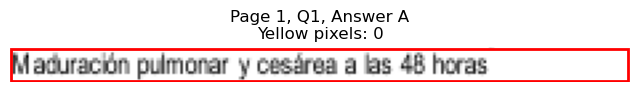

Page 1, Q1 - B: Detected box: x0=71.3, y0=121.5, x1=175.0, y1=133.6
Page 1, Q1, B: Yellow pixels: 0
Page 1, Q1, B: Total non-white pixels: 512
Page 1, Q1, B: Yellow percentage: 0.0%


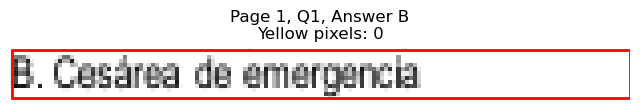

Page 1, Q1 - C: Detected box: x0=71.3, y0=133.5, x1=247.2, y1=145.6
Page 1, Q1, C: Yellow pixels: 1390
Page 1, Q1, C: Total non-white pixels: 2262
Page 1, Q1, C: Yellow percentage: 61.5%


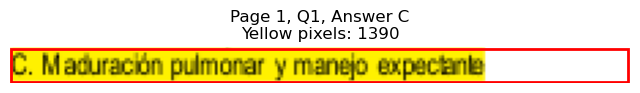

Page 1, Q1 - D: Detected box: x0=322.9, y0=109.5, x1=521.8, y1=121.6
Page 1, Q1, D: Yellow pixels: 0
Page 1, Q1, D: Total non-white pixels: 944
Page 1, Q1, D: Yellow percentage: 0.0%


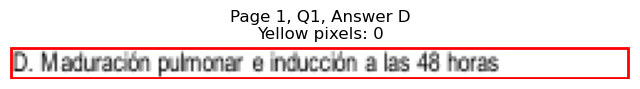

Page 1, Q1 - E: Detected box: x0=322.9, y0=121.5, x1=445.3, y1=133.6
Page 1, Q1, E: Yellow pixels: 0
Page 1, Q1, E: Total non-white pixels: 596
Page 1, Q1, E: Yellow percentage: 0.0%


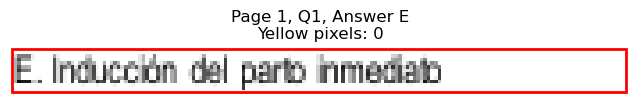


Page 1, Q1 - Selected Answer: C (based on yellow pixel count)




Page 1, Q2 - A: Detected box: x0=82.6, y0=169.6, x1=134.6, y1=181.6
Page 1, Q2, A: Yellow pixels: 369
Page 1, Q2, A: Total non-white pixels: 663
Page 1, Q2, A: Yellow percentage: 55.7%


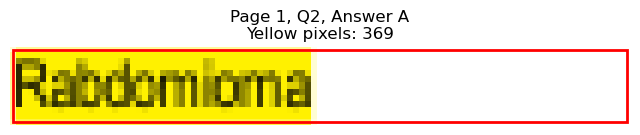

Page 1, Q2 - B: Detected box: x0=71.3, y0=181.6, x1=129.2, y1=193.6
Page 1, Q2, B: Yellow pixels: 49
Page 1, Q2, B: Total non-white pixels: 351
Page 1, Q2, B: Yellow percentage: 14.0%


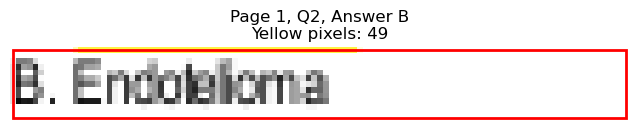

Page 1, Q2 - C: Detected box: x0=71.3, y0=193.6, x1=121.0, y1=205.6
Page 1, Q2, C: Yellow pixels: 0
Page 1, Q2, C: Total non-white pixels: 223
Page 1, Q2, C: Yellow percentage: 0.0%


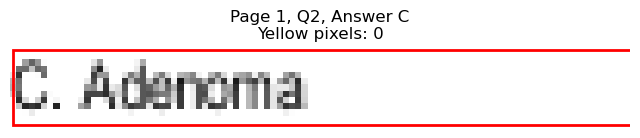

Page 1, Q2 - D: Detected box: x0=322.9, y0=169.6, x1=371.8, y1=181.6
Page 1, Q2, D: Yellow pixels: 0
Page 1, Q2, D: Total non-white pixels: 230
Page 1, Q2, D: Yellow percentage: 0.0%


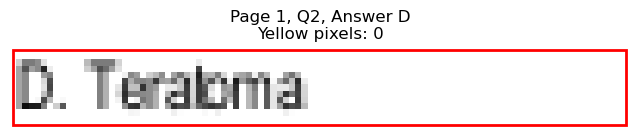

Page 1, Q2 - E: Detected box: x0=322.9, y0=181.6, x1=362.0, y1=193.6
Page 1, Q2, E: Yellow pixels: 0
Page 1, Q2, E: Total non-white pixels: 187
Page 1, Q2, E: Yellow percentage: 0.0%


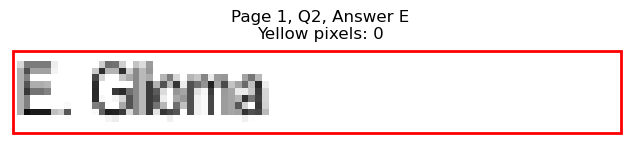


Page 1, Q2 - Selected Answer: A (based on yellow pixel count)




Page 1, Q3 - A: Detected box: x0=82.6, y0=229.6, x1=198.9, y1=241.7
Page 1, Q3, A: Yellow pixels: 0
Page 1, Q3, A: Total non-white pixels: 551
Page 1, Q3, A: Yellow percentage: 0.0%


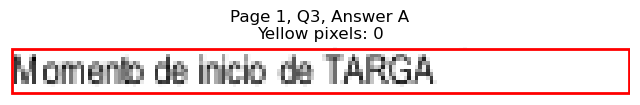

Page 1, Q3 - B: Detected box: x0=71.3, y0=241.6, x1=129.2, y1=253.7
Page 1, Q3, B: Yellow pixels: 0
Page 1, Q3, B: Total non-white pixels: 265
Page 1, Q3, B: Yellow percentage: 0.0%


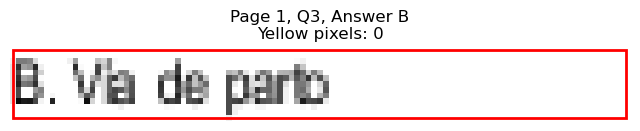

Page 1, Q3 - C: Detected box: x0=71.3, y0=253.6, x1=154.0, y1=265.7
Page 1, Q3, C: Yellow pixels: 0
Page 1, Q3, C: Total non-white pixels: 371
Page 1, Q3, C: Yellow percentage: 0.0%


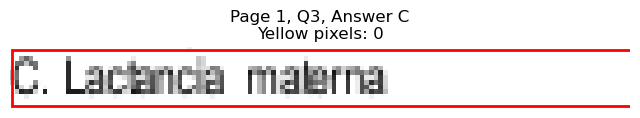

Page 1, Q3 - D: Detected box: x0=322.9, y0=229.6, x1=392.1, y1=241.7
Page 1, Q3, D: Yellow pixels: 529
Page 1, Q3, D: Total non-white pixels: 884
Page 1, Q3, D: Yellow percentage: 59.8%


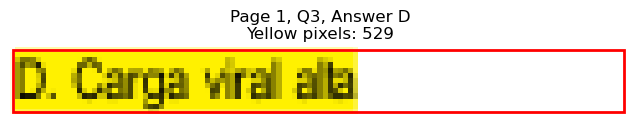

Page 1, Q3 - E: Detected box: x0=322.9, y0=241.6, x1=422.0, y1=253.7
Page 1, Q3, E: Yellow pixels: 67
Page 1, Q3, E: Total non-white pixels: 529
Page 1, Q3, E: Yellow percentage: 12.7%


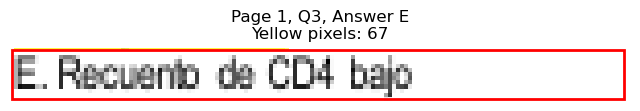


Page 1, Q3 - Selected Answer: D (based on yellow pixel count)




Page 1, Q4 - A: Detected box: x0=82.6, y0=289.7, x1=144.3, y1=301.8
Page 1, Q4, A: Yellow pixels: 0
Page 1, Q4, A: Total non-white pixels: 317
Page 1, Q4, A: Yellow percentage: 0.0%


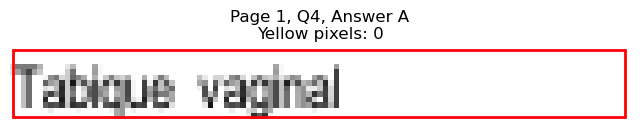

Page 1, Q4 - B: Detected box: x0=71.3, y0=302.5, x1=154.7, y1=314.5
Page 1, Q4, B: Yellow pixels: 0
Page 1, Q4, B: Total non-white pixels: 415
Page 1, Q4, B: Yellow percentage: 0.0%


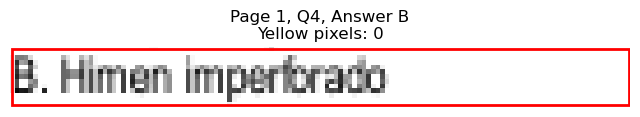

Page 1, Q4 - C: Detected box: x0=71.3, y0=314.5, x1=184.0, y1=326.5
Page 1, Q4, C: Yellow pixels: 0
Page 1, Q4, C: Total non-white pixels: 798
Page 1, Q4, C: Yellow percentage: 0.0%


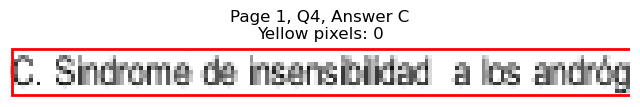

Page 1, Q4 - D: Detected box: x0=322.9, y0=289.7, x1=452.8, y1=301.8
Page 1, Q4, D: Yellow pixels: 0
Page 1, Q4, D: Total non-white pixels: 644
Page 1, Q4, D: Yellow percentage: 0.0%


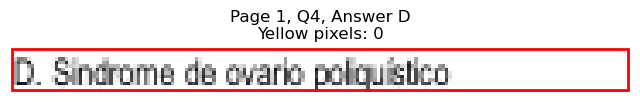

Page 1, Q4 - E: Detected box: x0=322.9, y0=302.5, x1=477.0, y1=314.5
Page 1, Q4, E: Yellow pixels: 1357
Page 1, Q4, E: Total non-white pixels: 1989
Page 1, Q4, E: Yellow percentage: 68.2%


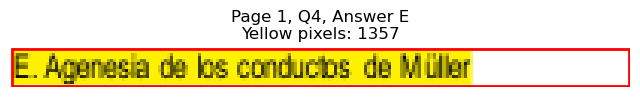


Page 1, Q4 - Selected Answer: E (based on yellow pixel count)




Page 1, Q5 - A: Detected box: x0=82.6, y0=350.5, x1=142.7, y1=362.5
Page 1, Q5, A: Yellow pixels: 0
Page 1, Q5, A: Total non-white pixels: 318
Page 1, Q5, A: Yellow percentage: 0.0%


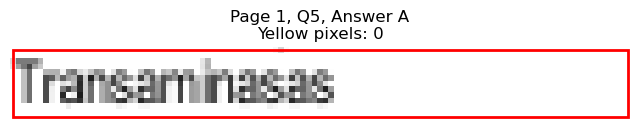

Page 1, Q5 - B: Detected box: x0=71.3, y0=362.5, x1=119.5, y1=374.6
Page 1, Q5, B: Yellow pixels: 0
Page 1, Q5, B: Total non-white pixels: 410
Page 1, Q5, B: Yellow percentage: 0.0%


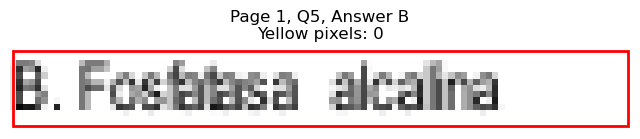

Page 1, Q5 - C: Detected box: x0=71.3, y0=374.5, x1=121.0, y1=386.6
Page 1, Q5, C: Yellow pixels: 0
Page 1, Q5, C: Total non-white pixels: 238
Page 1, Q5, C: Yellow percentage: 0.0%


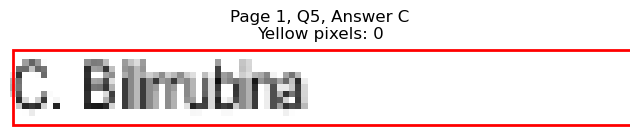

Page 1, Q5 - D: Detected box: x0=322.9, y0=350.5, x1=379.4, y1=362.5
Page 1, Q5, D: Yellow pixels: 464
Page 1, Q5, D: Total non-white pixels: 717
Page 1, Q5, D: Yellow percentage: 64.7%


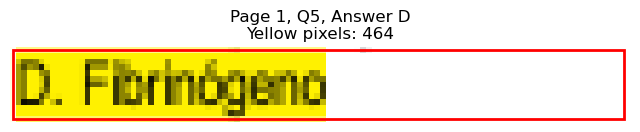

Page 1, Q5 - E: Detected box: x0=322.9, y0=362.5, x1=395.8, y1=374.6
Page 1, Q5, E: Yellow pixels: 54
Page 1, Q5, E: Total non-white pixels: 571
Page 1, Q5, E: Yellow percentage: 9.5%


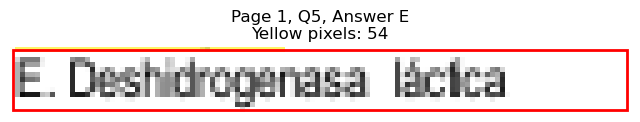


Page 1, Q5 - Selected Answer: D (based on yellow pixel count)




Page 1, Q6 - A: Detected box: x0=82.6, y0=422.5, x1=240.4, y1=434.6
Page 1, Q6, A: Yellow pixels: 1236
Page 1, Q6, A: Total non-white pixels: 2041
Page 1, Q6, A: Yellow percentage: 60.6%


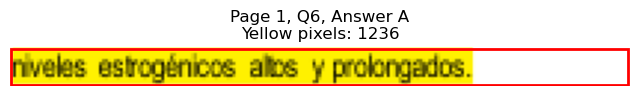

Page 1, Q6 - B: Detected box: x0=71.3, y0=434.6, x1=234.2, y1=446.6
Page 1, Q6, B: Yellow pixels: 155
Page 1, Q6, B: Total non-white pixels: 924
Page 1, Q6, B: Yellow percentage: 16.8%


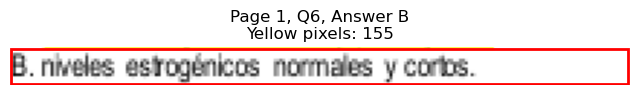

Page 1, Q6 - C: Detected box: x0=71.3, y0=446.6, x1=223.7, y1=458.6
Page 1, Q6, C: Yellow pixels: 0
Page 1, Q6, C: Total non-white pixels: 880
Page 1, Q6, C: Yellow percentage: 0.0%


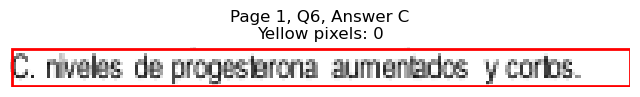

Page 1, Q6 - D: Detected box: x0=322.9, y0=422.5, x1=436.3, y1=434.6
Page 1, Q6, D: Yellow pixels: 0
Page 1, Q6, D: Total non-white pixels: 661
Page 1, Q6, D: Yellow percentage: 0.0%


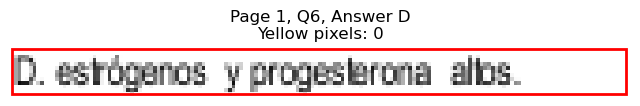

Page 1, Q6 - E: Detected box: x0=322.9, y0=434.6, x1=435.5, y1=446.6
Page 1, Q6, E: Yellow pixels: 0
Page 1, Q6, E: Total non-white pixels: 685
Page 1, Q6, E: Yellow percentage: 0.0%


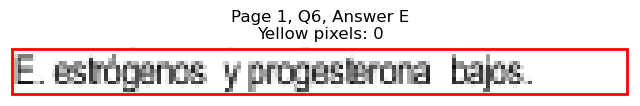


Page 1, Q6 - Selected Answer: A (based on yellow pixel count)




Page 1, Q7 - A: Detected box: x0=117.2, y0=483.4, x1=169.1, y1=495.4
Page 1, Q7, A: Yellow pixels: 424
Page 1, Q7, A: Total non-white pixels: 650
Page 1, Q7, A: Yellow percentage: 65.2%


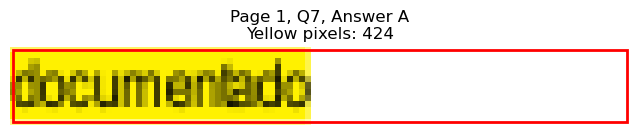

Page 1, Q7 - B: Detected box: x0=71.3, y0=495.4, x1=178.7, y1=507.4
Page 1, Q7, B: Yellow pixels: 83
Page 1, Q7, B: Total non-white pixels: 860
Page 1, Q7, B: Yellow percentage: 9.7%


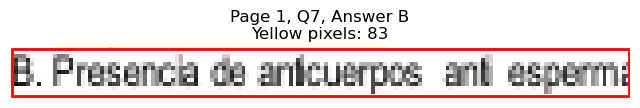

Page 1, Q7 - C: Detected box: x0=71.3, y0=507.4, x1=173.5, y1=519.4
Page 1, Q7, C: Yellow pixels: 0
Page 1, Q7, C: Total non-white pixels: 481
Page 1, Q7, C: Yellow percentage: 0.0%


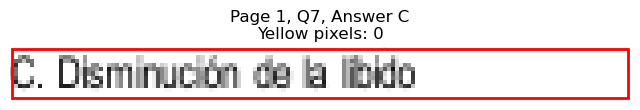

Page 1, Q7 - D: Detected box: x0=322.9, y0=483.4, x1=407.0, y1=495.4
Page 1, Q7, D: Yellow pixels: 0
Page 1, Q7, D: Total non-white pixels: 417
Page 1, Q7, D: Yellow percentage: 0.0%


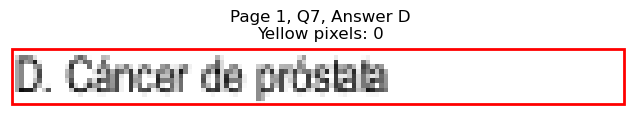

Page 1, Q7 - E: Detected box: x0=322.9, y0=495.4, x1=409.3, y1=507.4
Page 1, Q7, E: Yellow pixels: 0
Page 1, Q7, E: Total non-white pixels: 444
Page 1, Q7, E: Yellow percentage: 0.0%


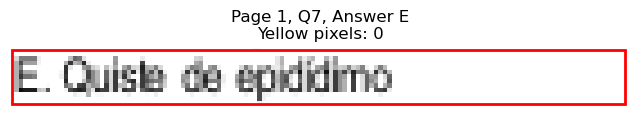


Page 1, Q7 - Selected Answer: A (based on yellow pixel count)




Page 1, Q8 - A: Detected box: x0=82.6, y0=555.4, x1=127.0, y1=567.5
Page 1, Q8, A: Yellow pixels: 0
Page 1, Q8, A: Total non-white pixels: 228
Page 1, Q8, A: Yellow percentage: 0.0%


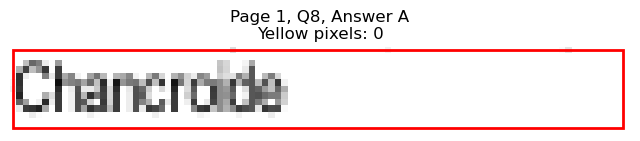

Page 1, Q8 - B: Detected box: x0=71.3, y0=567.5, x1=136.7, y1=579.5
Page 1, Q8, B: Yellow pixels: 0
Page 1, Q8, B: Total non-white pixels: 342
Page 1, Q8, B: Yellow percentage: 0.0%


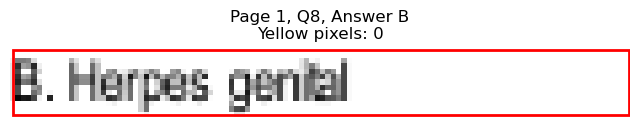

Page 1, Q8 - C: Detected box: x0=71.3, y0=579.4, x1=157.0, y1=591.5
Page 1, Q8, C: Yellow pixels: 0
Page 1, Q8, C: Total non-white pixels: 424
Page 1, Q8, C: Yellow percentage: 0.0%


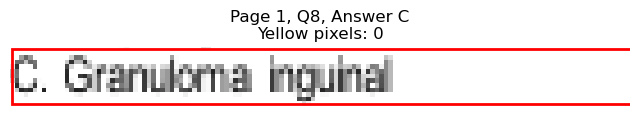

Page 1, Q8 - D: Detected box: x0=322.9, y0=555.4, x1=354.6, y1=567.5
Page 1, Q8, D: Yellow pixels: 248
Page 1, Q8, D: Total non-white pixels: 405
Page 1, Q8, D: Yellow percentage: 61.2%


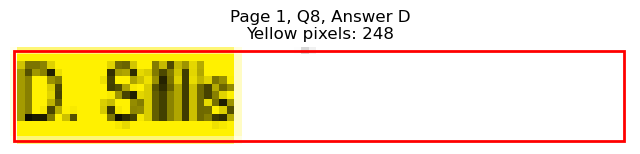

Page 1, Q8 - E: Detected box: x0=322.9, y0=567.5, x1=391.3, y1=579.5
Page 1, Q8, E: Yellow pixels: 29
Page 1, Q8, E: Total non-white pixels: 523
Page 1, Q8, E: Yellow percentage: 5.5%


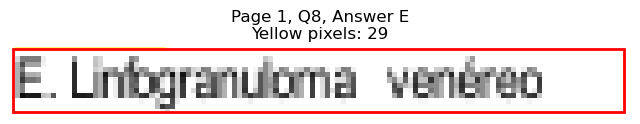


Page 1, Q8 - Selected Answer: D (based on yellow pixel count)




Page 1, Q9 - A: Detected box: x0=129.1, y0=627.5, x1=199.7, y1=639.6
Page 1, Q9, A: Yellow pixels: 0
Page 1, Q9, A: Total non-white pixels: 357
Page 1, Q9, A: Yellow percentage: 0.0%


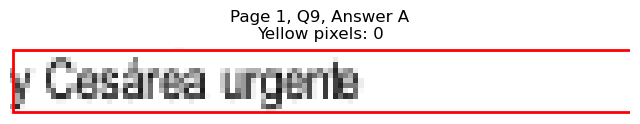

Page 1, Q9 - B: Detected box: x0=128.3, y0=639.5, x1=182.5, y1=651.6
Page 1, Q9, B: Yellow pixels: 0
Page 1, Q9, B: Total non-white pixels: 266
Page 1, Q9, B: Yellow percentage: 0.0%


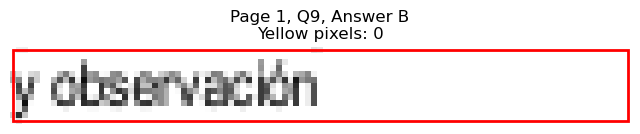

Page 1, Q9 - C: Detected box: x0=129.1, y0=651.5, x1=207.4, y1=663.6
Page 1, Q9, C: Yellow pixels: 686
Page 1, Q9, C: Total non-white pixels: 988
Page 1, Q9, C: Yellow percentage: 69.4%


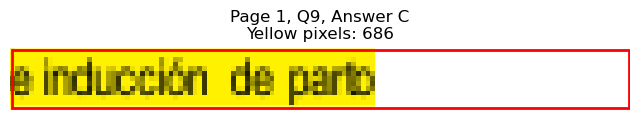

Page 1, Q9 - D: Detected box: x0=322.9, y0=627.5, x1=473.8, y1=639.6
Page 1, Q9, D: Yellow pixels: 0
Page 1, Q9, D: Total non-white pixels: 733
Page 1, Q9, D: Yellow percentage: 0.0%


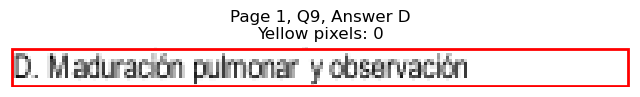

Page 1, Q9 - E: Detected box: x0=322.9, y0=639.5, x1=467.8, y1=651.6
Page 1, Q9, E: Yellow pixels: 0
Page 1, Q9, E: Total non-white pixels: 710
Page 1, Q9, E: Yellow percentage: 0.0%


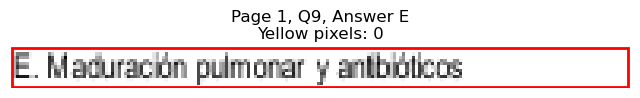


Page 1, Q9 - Selected Answer: C (based on yellow pixel count)




Page 1, Q10 - A: Detected box: x0=82.6, y0=700.3, x1=227.6, y1=712.3
Page 1, Q10, A: Yellow pixels: 0
Page 1, Q10, A: Total non-white pixels: 683
Page 1, Q10, A: Yellow percentage: 0.0%


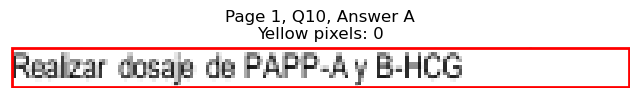

Page 1, Q10 - B: Detected box: x0=141.0, y0=712.3, x1=255.4, y1=724.4
Page 1, Q10, B: Yellow pixels: 1066
Page 1, Q10, B: Total non-white pixels: 1781
Page 1, Q10, B: Yellow percentage: 59.9%


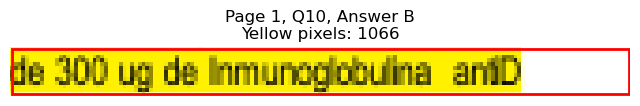

Page 1, Q10 - C: Detected box: x0=71.3, y0=724.3, x1=218.5, y1=736.4
Page 1, Q10, C: Yellow pixels: 4
Page 1, Q10, C: Total non-white pixels: 891
Page 1, Q10, C: Yellow percentage: 0.4%


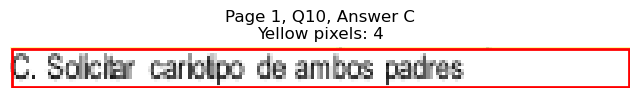

Page 1, Q10 - D: Detected box: x0=312.4, y0=700.3, x1=458.7, y1=712.3
Page 1, Q10, D: Yellow pixels: 0
Page 1, Q10, D: Total non-white pixels: 694
Page 1, Q10, D: Yellow percentage: 0.0%


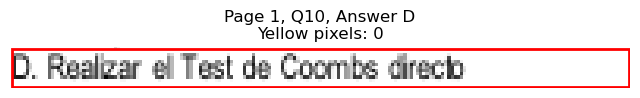

Page 1, Q10 - E: Detected box: x0=312.4, y0=712.3, x1=402.5, y1=724.4
Page 1, Q10, E: Yellow pixels: 0
Page 1, Q10, E: Total non-white pixels: 658
Page 1, Q10, E: Yellow percentage: 0.0%


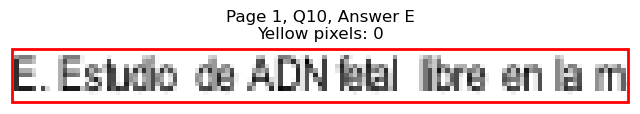


Page 1, Q10 - Selected Answer: B (based on yellow pixel count)





Page 2: Found 10 questions
Page 2, Q1 - A: Detected box: x0=82.6, y0=121.5, x1=160.7, y1=133.6
Page 2, Q1, A: Yellow pixels: 0
Page 2, Q1, A: Total non-white pixels: 381
Page 2, Q1, A: Yellow percentage: 0.0%


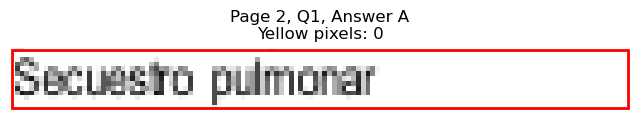

Page 2, Q1 - B: Detected box: x0=71.3, y0=133.5, x1=187.8, y1=145.6
Page 2, Q1, B: Yellow pixels: 0
Page 2, Q1, B: Total non-white pixels: 746
Page 2, Q1, B: Yellow percentage: 0.0%


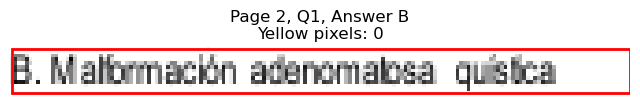

Page 2, Q1 - C: Detected box: x0=71.3, y0=145.6, x1=154.7, y1=157.6
Page 2, Q1, C: Yellow pixels: 0
Page 2, Q1, C: Total non-white pixels: 380
Page 2, Q1, C: Yellow percentage: 0.0%


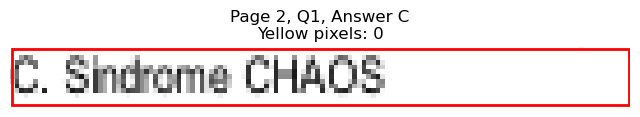

Page 2, Q1 - D: Detected box: x0=322.9, y0=121.5, x1=412.3, y1=133.6
Page 2, Q1, D: Yellow pixels: 1117
Page 2, Q1, D: Total non-white pixels: 1664
Page 2, Q1, D: Yellow percentage: 67.1%


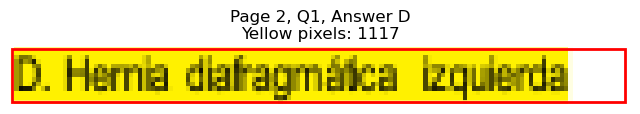

Page 2, Q1 - E: Detected box: x0=322.9, y0=133.5, x1=411.5, y1=145.6
Page 2, Q1, E: Yellow pixels: 126
Page 2, Q1, E: Total non-white pixels: 745
Page 2, Q1, E: Yellow percentage: 16.9%


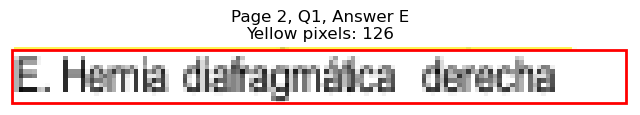


Page 2, Q1 - Selected Answer: D (based on yellow pixel count)




Page 2, Q2 - A: Detected box: x0=82.6, y0=193.6, x1=114.3, y1=205.6
Page 2, Q2, A: Yellow pixels: 0
Page 2, Q2, A: Total non-white pixels: 186
Page 2, Q2, A: Yellow percentage: 0.0%


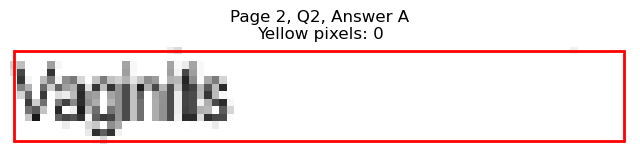

Page 2, Q2 - B: Detected box: x0=71.3, y0=205.6, x1=137.5, y1=217.7
Page 2, Q2, B: Yellow pixels: 0
Page 2, Q2, B: Total non-white pixels: 350
Page 2, Q2, B: Yellow percentage: 0.0%


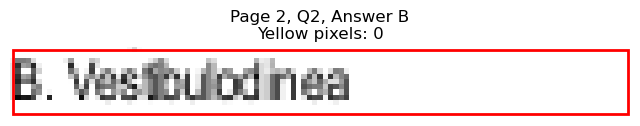

Page 2, Q2 - C: Detected box: x0=71.3, y0=217.6, x1=123.3, y1=229.7
Page 2, Q2, C: Yellow pixels: 395
Page 2, Q2, C: Total non-white pixels: 650
Page 2, Q2, C: Yellow percentage: 60.8%


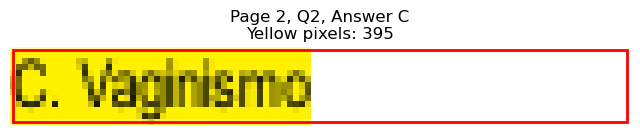

Page 2, Q2 - D: Detected box: x0=322.9, y0=193.6, x1=359.0, y1=205.6
Page 2, Q2, D: Yellow pixels: 0
Page 2, Q2, D: Total non-white pixels: 181
Page 2, Q2, D: Yellow percentage: 0.0%


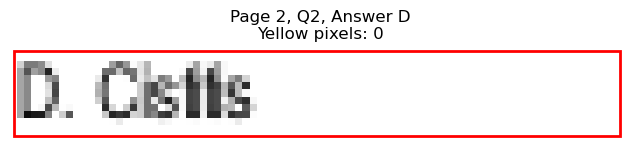

Page 2, Q2 - E: Detected box: x0=322.9, y0=205.6, x1=388.3, y1=217.7
Page 2, Q2, E: Yellow pixels: 0
Page 2, Q2, E: Total non-white pixels: 315
Page 2, Q2, E: Yellow percentage: 0.0%


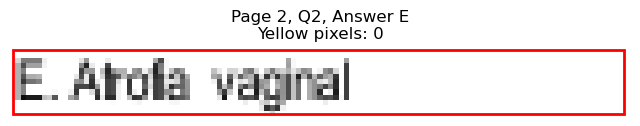


Page 2, Q2 - Selected Answer: C (based on yellow pixel count)




Page 2, Q3 - A: Detected box: x0=82.6, y0=253.6, x1=119.5, y1=265.7
Page 2, Q3, A: Yellow pixels: 0
Page 2, Q3, A: Total non-white pixels: 202
Page 2, Q3, A: Yellow percentage: 0.0%


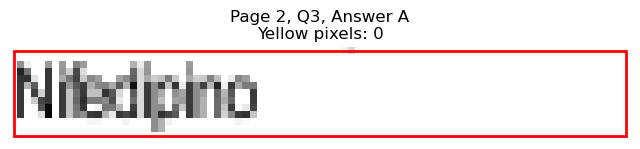

Page 2, Q3 - B: Detected box: x0=71.3, y0=265.7, x1=133.0, y1=277.7
Page 2, Q3, B: Yellow pixels: 0
Page 2, Q3, B: Total non-white pixels: 319
Page 2, Q3, B: Yellow percentage: 0.0%


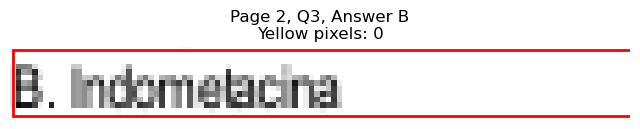

Page 2, Q3 - C: Detected box: x0=71.3, y0=277.7, x1=116.5, y1=289.7
Page 2, Q3, C: Yellow pixels: 351
Page 2, Q3, C: Total non-white pixels: 572
Page 2, Q3, C: Yellow percentage: 61.4%


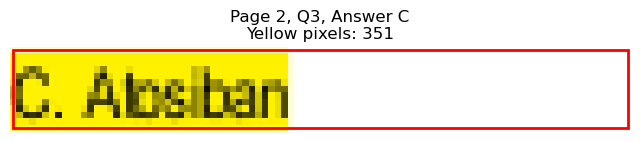

Page 2, Q3 - D: Detected box: x0=322.9, y0=253.6, x1=368.0, y1=265.7
Page 2, Q3, D: Yellow pixels: 0
Page 2, Q3, D: Total non-white pixels: 235
Page 2, Q3, D: Yellow percentage: 0.0%


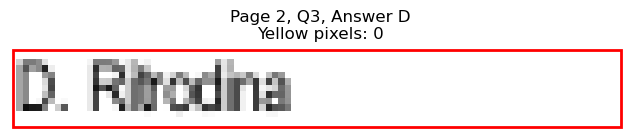

Page 2, Q3 - E: Detected box: x0=322.9, y0=265.7, x1=375.5, y1=277.7
Page 2, Q3, E: Yellow pixels: 0
Page 2, Q3, E: Total non-white pixels: 263
Page 2, Q3, E: Yellow percentage: 0.0%


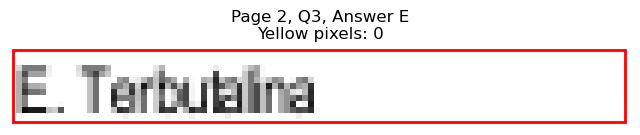


Page 2, Q3 - Selected Answer: C (based on yellow pixel count)




Page 2, Q4 - A: Detected box: x0=82.6, y0=314.5, x1=201.2, y1=326.5
Page 2, Q4, A: Yellow pixels: 0
Page 2, Q4, A: Total non-white pixels: 574
Page 2, Q4, A: Yellow percentage: 0.0%


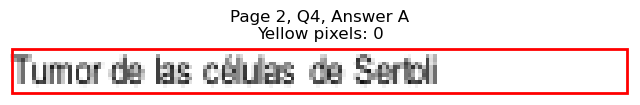

Page 2, Q4 - B: Detected box: x0=71.3, y0=326.5, x1=169.7, y1=338.5
Page 2, Q4, B: Yellow pixels: 0
Page 2, Q4, B: Total non-white pixels: 489
Page 2, Q4, B: Yellow percentage: 0.0%


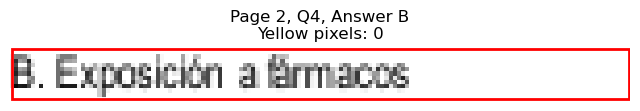

Page 2, Q4 - C: Detected box: x0=71.3, y0=338.5, x1=172.0, y1=350.5
Page 2, Q4, C: Yellow pixels: 0
Page 2, Q4, C: Total non-white pixels: 454
Page 2, Q4, C: Yellow percentage: 0.0%


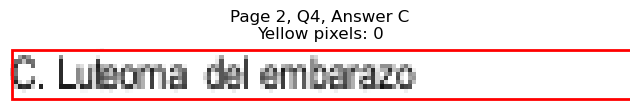

Page 2, Q4 - D: Detected box: x0=322.9, y0=314.5, x1=462.7, y1=326.5
Page 2, Q4, D: Yellow pixels: 1206
Page 2, Q4, D: Total non-white pixels: 1807
Page 2, Q4, D: Yellow percentage: 66.7%


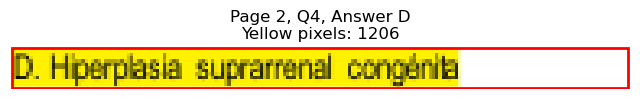

Page 2, Q4 - E: Detected box: x0=322.9, y0=326.5, x1=418.3, y1=338.5
Page 2, Q4, E: Yellow pixels: 137
Page 2, Q4, E: Total non-white pixels: 601
Page 2, Q4, E: Yellow percentage: 22.8%


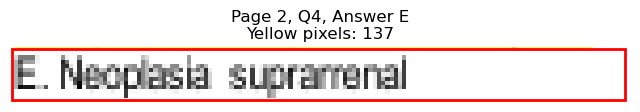


Page 2, Q4 - Selected Answer: D (based on yellow pixel count)




Page 2, Q5 - A: Detected box: x0=82.6, y0=374.5, x1=156.3, y1=386.6
Page 2, Q5, A: Yellow pixels: 0
Page 2, Q5, A: Total non-white pixels: 381
Page 2, Q5, A: Yellow percentage: 0.0%


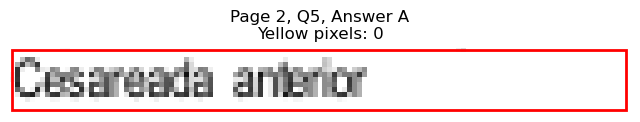

Page 2, Q5 - B: Detected box: x0=71.3, y0=386.5, x1=129.2, y1=398.6
Page 2, Q5, B: Yellow pixels: 0
Page 2, Q5, B: Total non-white pixels: 452
Page 2, Q5, B: Yellow percentage: 0.0%


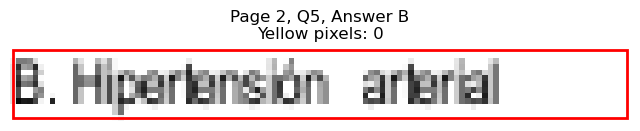

Page 2, Q5 - C: Detected box: x0=71.3, y0=398.5, x1=167.5, y1=410.6
Page 2, Q5, C: Yellow pixels: 0
Page 2, Q5, C: Total non-white pixels: 469
Page 2, Q5, C: Yellow percentage: 0.0%


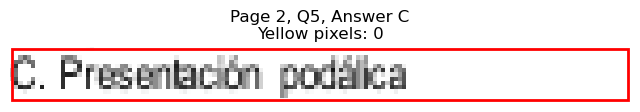

Page 2, Q5 - D: Detected box: x0=322.9, y0=374.5, x1=381.5, y1=386.6
Page 2, Q5, D: Yellow pixels: 0
Page 2, Q5, D: Total non-white pixels: 419
Page 2, Q5, D: Yellow percentage: 0.0%


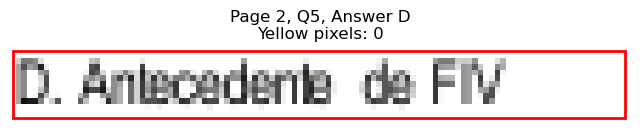

Page 2, Q5 - E: Detected box: x0=322.9, y0=386.5, x1=409.4, y1=398.6
Page 2, Q5, E: Yellow pixels: 674
Page 2, Q5, E: Total non-white pixels: 1118
Page 2, Q5, E: Yellow percentage: 60.3%


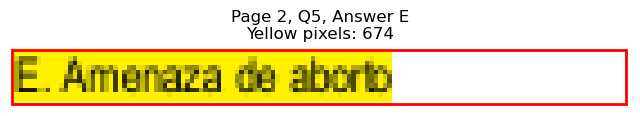


Page 2, Q5 - Selected Answer: E (based on yellow pixel count)




Page 2, Q6 - A: Detected box: x0=82.6, y0=446.6, x1=143.5, y1=458.6
Page 2, Q6, A: Yellow pixels: 0
Page 2, Q6, A: Total non-white pixels: 296
Page 2, Q6, A: Yellow percentage: 0.0%


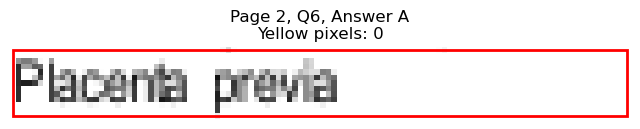

Page 2, Q6 - B: Detected box: x0=149.3, y0=458.6, x1=235.9, y1=470.6
Page 2, Q6, B: Yellow pixels: 671
Page 2, Q6, B: Total non-white pixels: 1105
Page 2, Q6, B: Yellow percentage: 60.7%


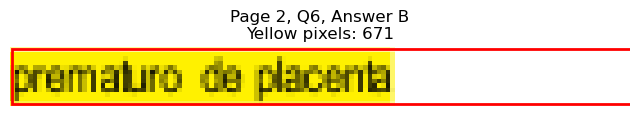

Page 2, Q6 - C: Detected box: x0=71.3, y0=470.6, x1=136.7, y1=482.6
Page 2, Q6, C: Yellow pixels: 116
Page 2, Q6, C: Total non-white pixels: 416
Page 2, Q6, C: Yellow percentage: 27.9%


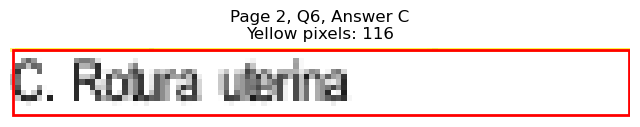

Page 2, Q6 - D: Detected box: x0=322.9, y0=446.6, x1=447.5, y1=458.6
Page 2, Q6, D: Yellow pixels: 0
Page 2, Q6, D: Total non-white pixels: 600
Page 2, Q6, D: Yellow percentage: 0.0%


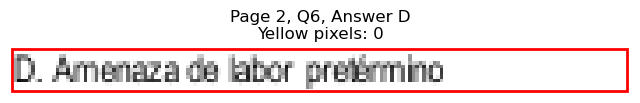

Page 2, Q6 - E: Detected box: x0=322.9, y0=458.6, x1=405.5, y1=470.6
Page 2, Q6, E: Yellow pixels: 0
Page 2, Q6, E: Total non-white pixels: 396
Page 2, Q6, E: Yellow percentage: 0.0%


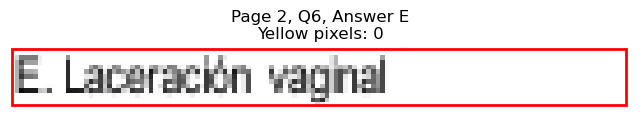


Page 2, Q6 - Selected Answer: B (based on yellow pixel count)




Page 2, Q7 - A: Detected box: x0=82.6, y0=519.4, x1=132.2, y1=531.4
Page 2, Q7, A: Yellow pixels: 0
Page 2, Q7, A: Total non-white pixels: 258
Page 2, Q7, A: Yellow percentage: 0.0%


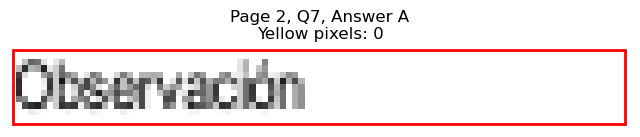

Page 2, Q7 - B: Detected box: x0=71.3, y0=531.4, x1=167.6, y1=543.5
Page 2, Q7, B: Yellow pixels: 828
Page 2, Q7, B: Total non-white pixels: 1235
Page 2, Q7, B: Yellow percentage: 67.0%


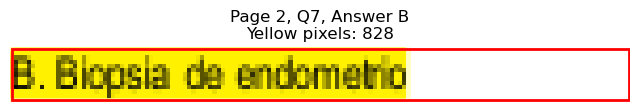

Page 2, Q7 - C: Detected box: x0=71.3, y0=543.4, x1=142.0, y1=555.5
Page 2, Q7, C: Yellow pixels: 93
Page 2, Q7, C: Total non-white pixels: 434
Page 2, Q7, C: Yellow percentage: 21.4%


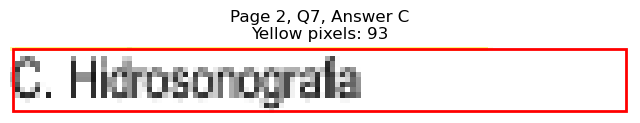

Page 2, Q7 - D: Detected box: x0=322.9, y0=519.4, x1=382.4, y1=531.4
Page 2, Q7, D: Yellow pixels: 0
Page 2, Q7, D: Total non-white pixels: 291
Page 2, Q7, D: Yellow percentage: 0.0%


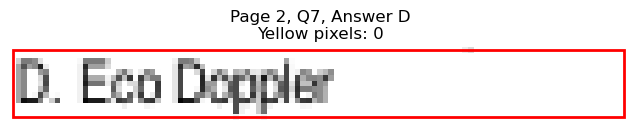

Page 2, Q7 - E: Detected box: x0=322.9, y0=531.4, x1=437.9, y1=543.5
Page 2, Q7, E: Yellow pixels: 0
Page 2, Q7, E: Total non-white pixels: 587
Page 2, Q7, E: Yellow percentage: 0.0%


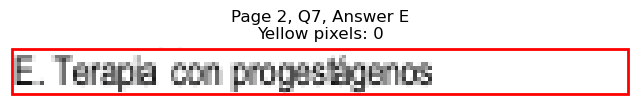


Page 2, Q7 - Selected Answer: B (based on yellow pixel count)




Page 2, Q8 - A: Detected box: x0=82.6, y0=579.4, x1=129.2, y1=591.5
Page 2, Q8, A: Yellow pixels: 0
Page 2, Q8, A: Total non-white pixels: 216
Page 2, Q8, A: Yellow percentage: 0.0%


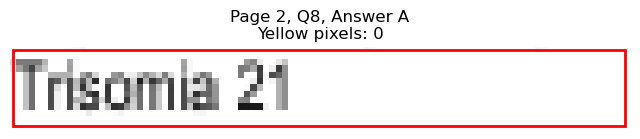

Page 2, Q8 - B: Detected box: x0=71.3, y0=591.5, x1=156.2, y1=603.5
Page 2, Q8, B: Yellow pixels: 0
Page 2, Q8, B: Total non-white pixels: 427
Page 2, Q8, B: Yellow percentage: 0.0%


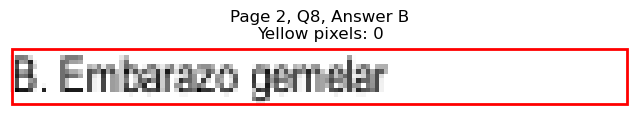

Page 2, Q8 - C: Detected box: x0=71.3, y0=603.5, x1=180.4, y1=615.5
Page 2, Q8, C: Yellow pixels: 938
Page 2, Q8, C: Total non-white pixels: 1391
Page 2, Q8, C: Yellow percentage: 67.4%


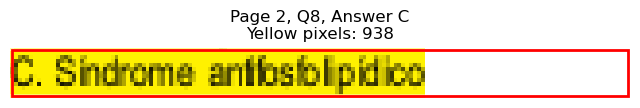

Page 2, Q8 - D: Detected box: x0=322.9, y0=579.4, x1=403.2, y1=591.5
Page 2, Q8, D: Yellow pixels: 0
Page 2, Q8, D: Total non-white pixels: 386
Page 2, Q8, D: Yellow percentage: 0.0%


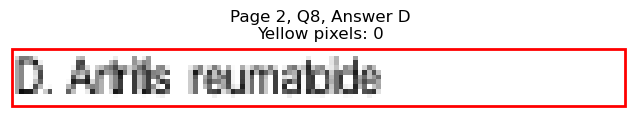

Page 2, Q8 - E: Detected box: x0=322.9, y0=591.5, x1=381.5, y1=603.5
Page 2, Q8, E: Yellow pixels: 0
Page 2, Q8, E: Total non-white pixels: 288
Page 2, Q8, E: Yellow percentage: 0.0%


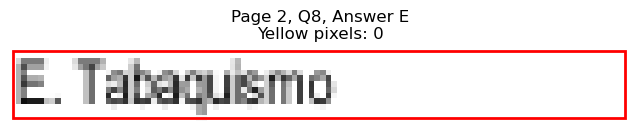


Page 2, Q8 - Selected Answer: C (based on yellow pixel count)




Page 2, Q9 - A: Detected box: x0=82.6, y0=639.5, x1=125.5, y1=651.6
Page 2, Q9, A: Yellow pixels: 0
Page 2, Q9, A: Total non-white pixels: 215
Page 2, Q9, A: Yellow percentage: 0.0%


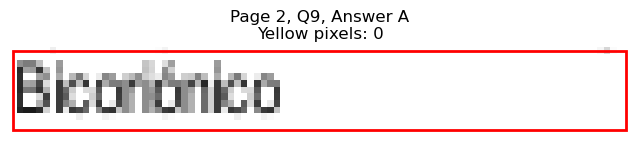

Page 2, Q9 - B: Detected box: x0=71.3, y0=651.5, x1=139.1, y1=663.6
Page 2, Q9, B: Yellow pixels: 597
Page 2, Q9, B: Total non-white pixels: 858
Page 2, Q9, B: Yellow percentage: 69.6%


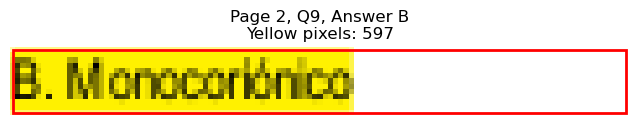

Page 2, Q9 - C: Detected box: x0=71.3, y0=663.5, x1=133.7, y1=675.6
Page 2, Q9, C: Yellow pixels: 66
Page 2, Q9, C: Total non-white pixels: 360
Page 2, Q9, C: Yellow percentage: 18.3%


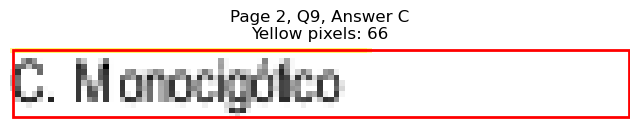

Page 2, Q9 - D: Detected box: x0=322.9, y0=639.5, x1=371.0, y1=651.6
Page 2, Q9, D: Yellow pixels: 0
Page 2, Q9, D: Total non-white pixels: 260
Page 2, Q9, D: Yellow percentage: 0.0%


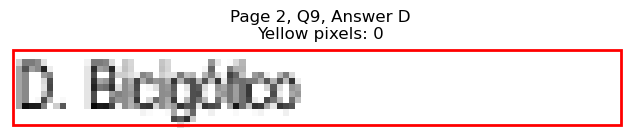

Page 2, Q9 - E: Detected box: x0=322.9, y0=651.5, x1=408.5, y1=663.6
Page 2, Q9, E: Yellow pixels: 0
Page 2, Q9, E: Total non-white pixels: 411
Page 2, Q9, E: Yellow percentage: 0.0%


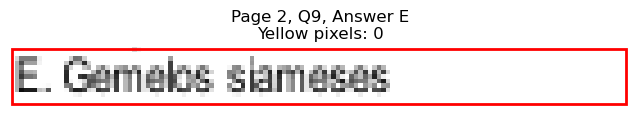


Page 2, Q9 - Selected Answer: B (based on yellow pixel count)




Page 2, Q10 - A: Detected box: x0=82.6, y0=700.3, x1=114.3, y1=712.3
Page 2, Q10, A: Yellow pixels: 0
Page 2, Q10, A: Total non-white pixels: 159
Page 2, Q10, A: Yellow percentage: 0.0%


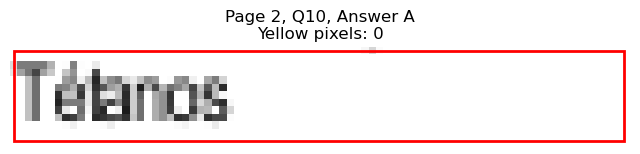

Page 2, Q10 - B: Detected box: x0=71.3, y0=712.3, x1=114.2, y1=724.4
Page 2, Q10, B: Yellow pixels: 0
Page 2, Q10, B: Total non-white pixels: 267
Page 2, Q10, B: Yellow percentage: 0.0%


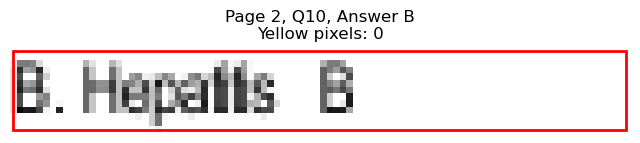

Page 2, Q10 - C: Detected box: x0=71.3, y0=724.3, x1=114.3, y1=736.4
Page 2, Q10, C: Yellow pixels: 330
Page 2, Q10, C: Total non-white pixels: 533
Page 2, Q10, C: Yellow percentage: 61.9%


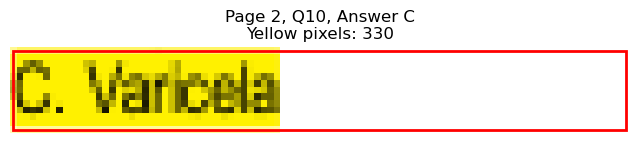

Page 2, Q10 - D: Detected box: x0=322.9, y0=700.3, x1=368.8, y1=712.3
Page 2, Q10, D: Yellow pixels: 0
Page 2, Q10, D: Total non-white pixels: 215
Page 2, Q10, D: Yellow percentage: 0.0%


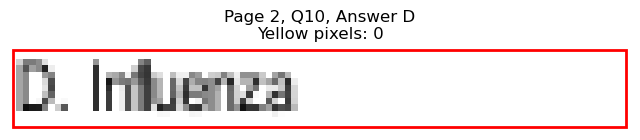

Page 2, Q10 - E: Detected box: x0=322.9, y0=712.3, x1=360.6, y1=724.4
Page 2, Q10, E: Yellow pixels: 0
Page 2, Q10, E: Total non-white pixels: 163
Page 2, Q10, E: Yellow percentage: 0.0%


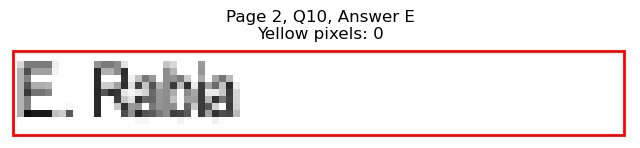


Page 2, Q10 - Selected Answer: C (based on yellow pixel count)





Page 3: Found 10 questions
Page 3, Q1 - A: Detected box: x0=71.3, y0=109.5, x1=79.7, y1=121.6
Page 3, Q1, A: Yellow pixels: 0
Page 3, Q1, A: Total non-white pixels: 49
Page 3, Q1, A: Yellow percentage: 0.0%


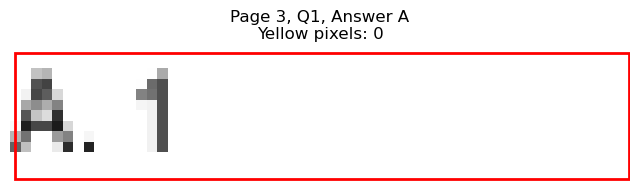

Page 3, Q1 - B: Detected box: x0=71.3, y0=724.3, x1=88.7, y1=736.4
Page 3, Q1, B: Yellow pixels: 132
Page 3, Q1, B: Total non-white pixels: 208
Page 3, Q1, B: Yellow percentage: 63.5%


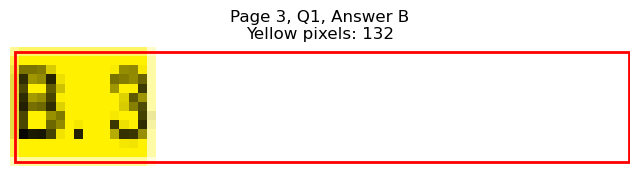

Page 3, Q1 - C: Detected box: x0=71.3, y0=133.5, x1=89.5, y1=145.6
Page 3, Q1, C: Yellow pixels: 0
Page 3, Q1, C: Total non-white pixels: 57
Page 3, Q1, C: Yellow percentage: 0.0%


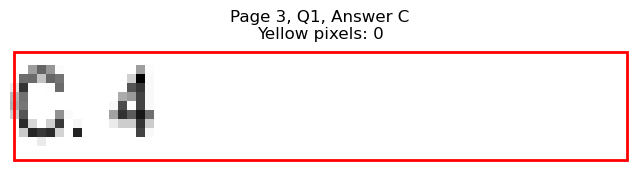

Page 3, Q1 - D: Detected box: x0=322.9, y0=109.5, x1=341.1, y1=121.6
Page 3, Q1, D: Yellow pixels: 150
Page 3, Q1, D: Total non-white pixels: 221
Page 3, Q1, D: Yellow percentage: 67.9%


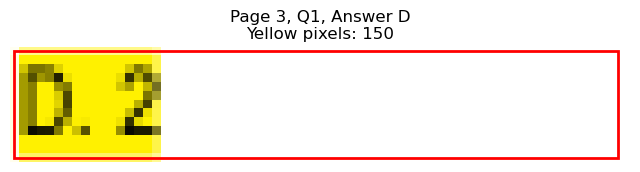

Page 3, Q1 - E: Detected box: x0=322.9, y0=121.5, x1=340.3, y1=133.6
Page 3, Q1, E: Yellow pixels: 16
Page 3, Q1, E: Total non-white pixels: 81
Page 3, Q1, E: Yellow percentage: 19.8%


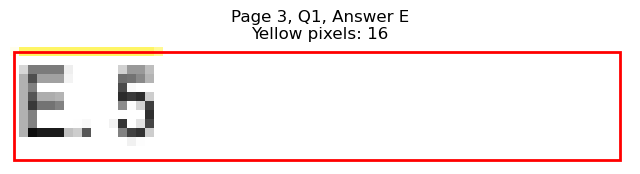


Page 3, Q1 - Selected Answer: D (based on yellow pixel count)




Page 3, Q2 - A: Detected box: x0=150.9, y0=169.6, x1=228.2, y1=181.6
Page 3, Q2, A: Yellow pixels: 0
Page 3, Q2, A: Total non-white pixels: 341
Page 3, Q2, A: Yellow percentage: 0.0%


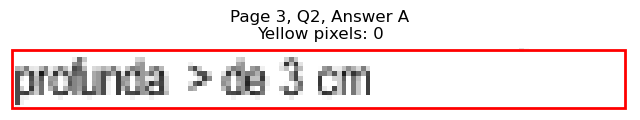

Page 3, Q2 - B: Detected box: x0=71.3, y0=181.6, x1=228.2, y1=193.6
Page 3, Q2, B: Yellow pixels: 0
Page 3, Q2, B: Total non-white pixels: 744
Page 3, Q2, B: Yellow percentage: 0.0%


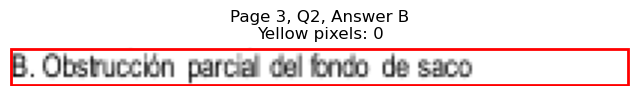

Page 3, Q2 - C: Detected box: x0=71.3, y0=193.6, x1=250.7, y1=205.6
Page 3, Q2, C: Yellow pixels: 0
Page 3, Q2, C: Total non-white pixels: 832
Page 3, Q2, C: Yellow percentage: 0.0%


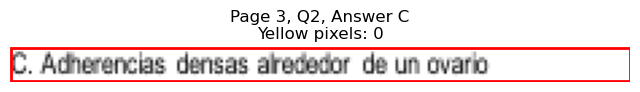

Page 3, Q2 - D: Detected box: x0=322.9, y0=169.6, x1=486.0, y1=181.6
Page 3, Q2, D: Yellow pixels: 1369
Page 3, Q2, D: Total non-white pixels: 2106
Page 3, Q2, D: Yellow percentage: 65.0%


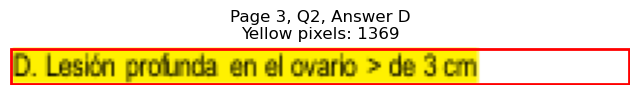

Page 3, Q2 - E: Detected box: x0=322.9, y0=181.6, x1=509.0, y1=193.6
Page 3, Q2, E: Yellow pixels: 161
Page 3, Q2, E: Total non-white pixels: 1073
Page 3, Q2, E: Yellow percentage: 15.0%


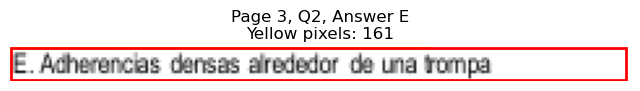


Page 3, Q2 - Selected Answer: D (based on yellow pixel count)




Page 3, Q3 - A: Detected box: x0=82.6, y0=229.6, x1=241.0, y1=241.7
Page 3, Q3, A: Yellow pixels: 0
Page 3, Q3, A: Total non-white pixels: 784
Page 3, Q3, A: Yellow percentage: 0.0%


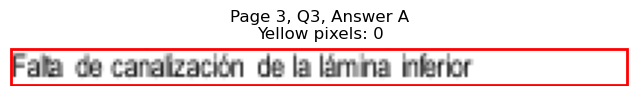

Page 3, Q3 - B: Detected box: x0=71.3, y0=241.6, x1=217.8, y1=253.7
Page 3, Q3, B: Yellow pixels: 0
Page 3, Q3, B: Total non-white pixels: 700
Page 3, Q3, B: Yellow percentage: 0.0%


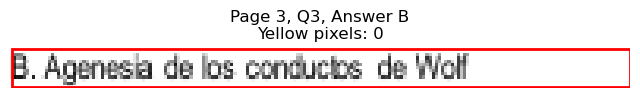

Page 3, Q3 - C: Detected box: x0=71.3, y0=253.6, x1=201.4, y1=265.7
Page 3, Q3, C: Yellow pixels: 1046
Page 3, Q3, C: Total non-white pixels: 1668
Page 3, Q3, C: Yellow percentage: 62.7%


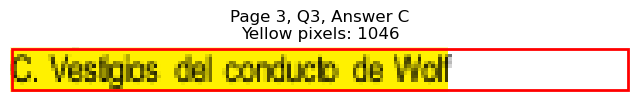

Page 3, Q3 - D: Detected box: x0=322.9, y0=229.6, x1=476.8, y1=241.7
Page 3, Q3, D: Yellow pixels: 0
Page 3, Q3, D: Total non-white pixels: 731
Page 3, Q3, D: Yellow percentage: 0.0%


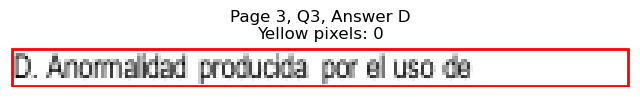

Page 3, Q3 - E: Detected box: x0=420.4, y0=253.6, x1=509.0, y1=265.7
Page 3, Q3, E: Yellow pixels: 0
Page 3, Q3, E: Total non-white pixels: 429
Page 3, Q3, E: Yellow percentage: 0.0%


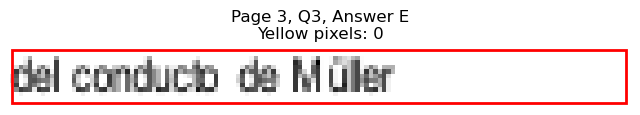


Page 3, Q3 - Selected Answer: C (based on yellow pixel count)




Page 3, Q4 - A: Detected box: x0=82.6, y0=302.5, x1=133.1, y1=314.5
Page 3, Q4, A: Yellow pixels: 0
Page 3, Q4, A: Total non-white pixels: 258
Page 3, Q4, A: Yellow percentage: 0.0%


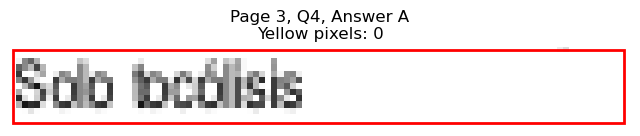

Page 3, Q4 - B: Detected box: x0=71.3, y0=314.5, x1=185.5, y1=326.5
Page 3, Q4, B: Yellow pixels: 0
Page 3, Q4, B: Total non-white pixels: 546
Page 3, Q4, B: Yellow percentage: 0.0%


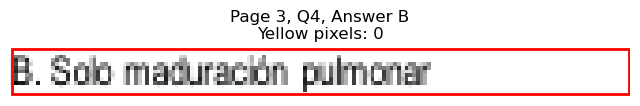

Page 3, Q4 - C: Detected box: x0=71.3, y0=326.5, x1=139.0, y1=338.5
Page 3, Q4, C: Yellow pixels: 0
Page 3, Q4, C: Total non-white pixels: 570
Page 3, Q4, C: Yellow percentage: 0.0%


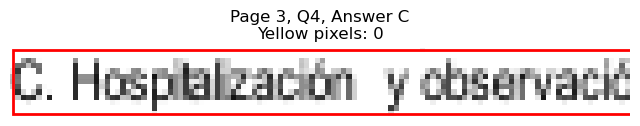

Page 3, Q4 - D: Detected box: x0=322.9, y0=302.5, x1=408.5, y1=314.5
Page 3, Q4, D: Yellow pixels: 0
Page 3, Q4, D: Total non-white pixels: 419
Page 3, Q4, D: Yellow percentage: 0.0%


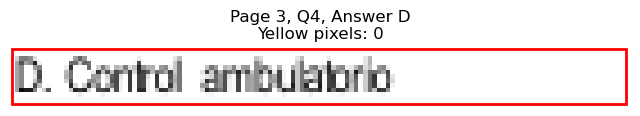

Page 3, Q4 - E: Detected box: x0=322.9, y0=314.5, x1=456.7, y1=326.5
Page 3, Q4, E: Yellow pixels: 1161
Page 3, Q4, E: Total non-white pixels: 1729
Page 3, Q4, E: Yellow percentage: 67.1%


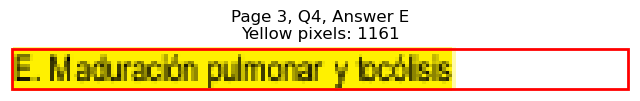


Page 3, Q4 - Selected Answer: E (based on yellow pixel count)




Page 3, Q5 - A: Detected box: x0=82.6, y0=362.5, x1=109.0, y1=374.6
Page 3, Q5, A: Yellow pixels: 217
Page 3, Q5, A: Total non-white pixels: 329
Page 3, Q5, A: Yellow percentage: 66.0%


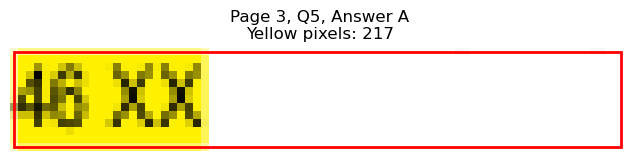

Page 3, Q5 - B: Detected box: x0=71.3, y0=374.5, x1=114.2, y1=386.6
Page 3, Q5, B: Yellow pixels: 23
Page 3, Q5, B: Total non-white pixels: 220
Page 3, Q5, B: Yellow percentage: 10.5%


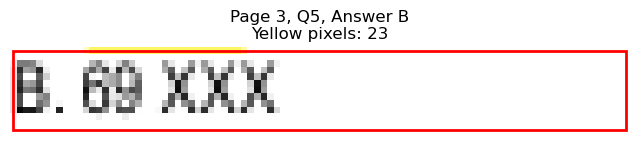

Page 3, Q5 - C: Detected box: x0=71.3, y0=386.5, x1=114.9, y1=398.6
Page 3, Q5, C: Yellow pixels: 0
Page 3, Q5, C: Total non-white pixels: 181
Page 3, Q5, C: Yellow percentage: 0.0%


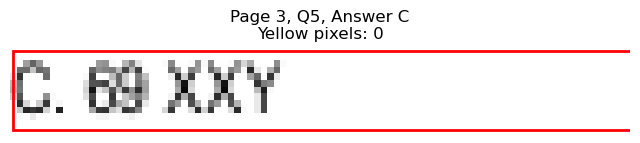

Page 3, Q5 - D: Detected box: x0=322.9, y0=362.5, x1=357.5, y1=374.6
Page 3, Q5, D: Yellow pixels: 0
Page 3, Q5, D: Total non-white pixels: 149
Page 3, Q5, D: Yellow percentage: 0.0%


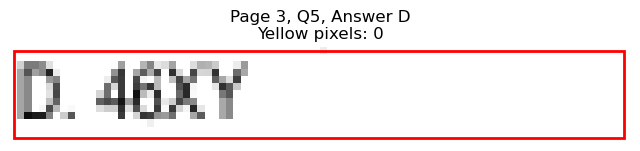

Page 3, Q5 - E: Detected box: x0=322.9, y0=374.5, x1=358.3, y1=386.6
Page 3, Q5, E: Yellow pixels: 0
Page 3, Q5, E: Total non-white pixels: 156
Page 3, Q5, E: Yellow percentage: 0.0%


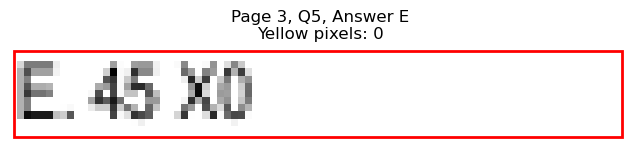


Page 3, Q5 - Selected Answer: A (based on yellow pixel count)




Page 3, Q6 - A: Detected box: x0=124.6, y0=434.6, x1=203.5, y1=446.6
Page 3, Q6, A: Yellow pixels: 0
Page 3, Q6, A: Total non-white pixels: 406
Page 3, Q6, A: Yellow percentage: 0.0%


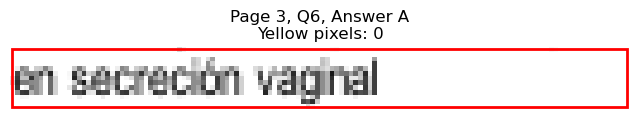

Page 3, Q6 - B: Detected box: x0=71.3, y0=446.6, x1=186.3, y1=458.6
Page 3, Q6, B: Yellow pixels: 0
Page 3, Q6, B: Total non-white pixels: 556
Page 3, Q6, B: Yellow percentage: 0.0%


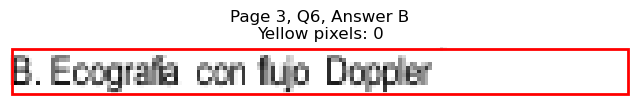

Page 3, Q6 - C: Detected box: x0=71.3, y0=458.6, x1=187.0, y1=470.6
Page 3, Q6, C: Yellow pixels: 0
Page 3, Q6, C: Total non-white pixels: 535
Page 3, Q6, C: Yellow percentage: 0.0%


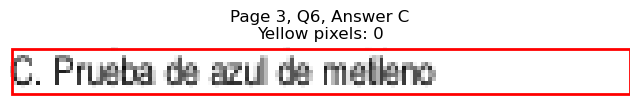

Page 3, Q6 - D: Detected box: x0=322.9, y0=434.6, x1=383.8, y1=446.6
Page 3, Q6, D: Yellow pixels: 691
Page 3, Q6, D: Total non-white pixels: 1157
Page 3, Q6, D: Yellow percentage: 59.7%


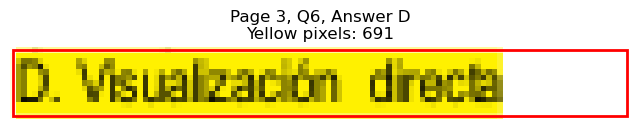

Page 3, Q6 - E: Detected box: x0=322.9, y0=446.6, x1=399.5, y1=458.6
Page 3, Q6, E: Yellow pixels: 88
Page 3, Q6, E: Total non-white pixels: 473
Page 3, Q6, E: Yellow percentage: 18.6%


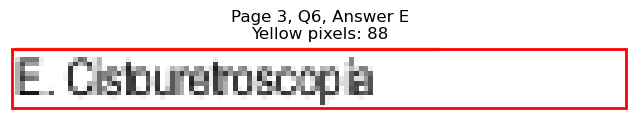


Page 3, Q6 - Selected Answer: D (based on yellow pixel count)




Page 3, Q7 - A: Detected box: x0=82.6, y0=507.4, x1=184.7, y1=519.4
Page 3, Q7, A: Yellow pixels: 0
Page 3, Q7, A: Total non-white pixels: 507
Page 3, Q7, A: Yellow percentage: 0.0%


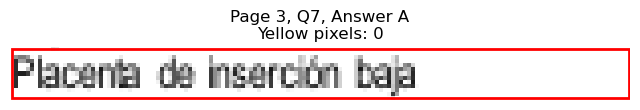

Page 3, Q7 - B: Detected box: x0=71.3, y0=519.4, x1=151.7, y1=531.4
Page 3, Q7, B: Yellow pixels: 0
Page 3, Q7, B: Total non-white pixels: 405
Page 3, Q7, B: Yellow percentage: 0.0%


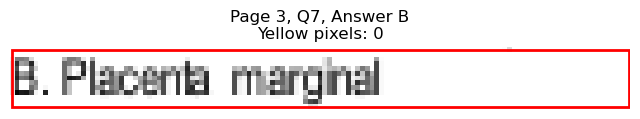

Page 3, Q7 - C: Detected box: x0=71.3, y0=531.4, x1=163.7, y1=543.5
Page 3, Q7, C: Yellow pixels: 0
Page 3, Q7, C: Total non-white pixels: 430
Page 3, Q7, C: Yellow percentage: 0.0%


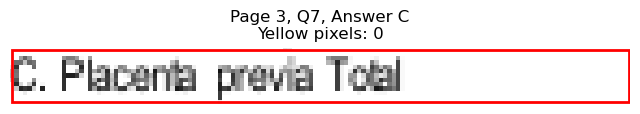

Page 3, Q7 - D: Detected box: x0=322.9, y0=507.4, x1=422.0, y1=519.4
Page 3, Q7, D: Yellow pixels: 0
Page 3, Q7, D: Total non-white pixels: 498
Page 3, Q7, D: Yellow percentage: 0.0%


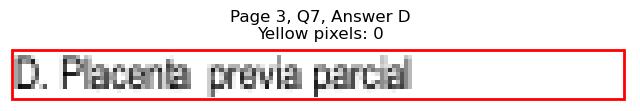

Page 3, Q7 - E: Detected box: x0=322.9, y0=519.4, x1=419.9, y1=531.4
Page 3, Q7, E: Yellow pixels: 841
Page 3, Q7, E: Total non-white pixels: 1248
Page 3, Q7, E: Yellow percentage: 67.4%


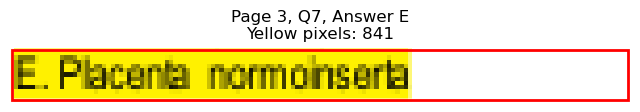


Page 3, Q7 - Selected Answer: E (based on yellow pixel count)




Page 3, Q8 - A: Detected box: x0=82.6, y0=579.4, x1=169.8, y1=591.5
Page 3, Q8, A: Yellow pixels: 0
Page 3, Q8, A: Total non-white pixels: 445
Page 3, Q8, A: Yellow percentage: 0.0%


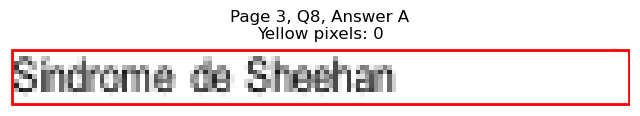

Page 3, Q8 - B: Detected box: x0=131.3, y0=591.5, x1=194.6, y1=603.5
Page 3, Q8, B: Yellow pixels: 537
Page 3, Q8, B: Total non-white pixels: 806
Page 3, Q8, B: Yellow percentage: 66.6%


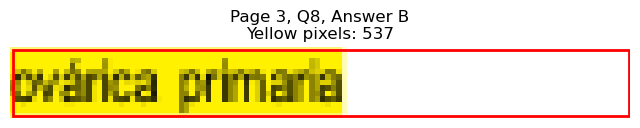

Page 3, Q8 - C: Detected box: x0=71.3, y0=603.5, x1=142.0, y1=615.5
Page 3, Q8, C: Yellow pixels: 121
Page 3, Q8, C: Total non-white pixels: 724
Page 3, Q8, C: Yellow percentage: 16.7%


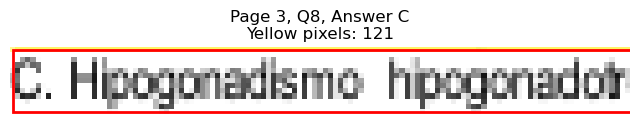

Page 3, Q8 - D: Detected box: x0=322.9, y0=579.4, x1=427.2, y1=591.5
Page 3, Q8, D: Yellow pixels: 0
Page 3, Q8, D: Total non-white pixels: 497
Page 3, Q8, D: Yellow percentage: 0.0%


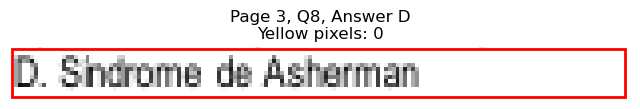

Page 3, Q8 - E: Detected box: x0=322.9, y0=591.5, x1=410.8, y1=603.5
Page 3, Q8, E: Yellow pixels: 0
Page 3, Q8, E: Total non-white pixels: 428
Page 3, Q8, E: Yellow percentage: 0.0%


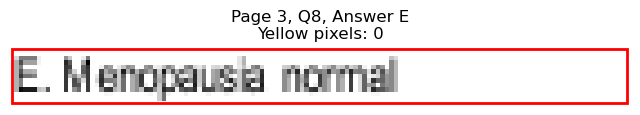


Page 3, Q8 - Selected Answer: B (based on yellow pixel count)




Page 3, Q9 - A: Detected box: x0=82.6, y0=639.5, x1=123.2, y1=651.6
Page 3, Q9, A: Yellow pixels: 0
Page 3, Q9, A: Total non-white pixels: 221
Page 3, Q9, A: Yellow percentage: 0.0%


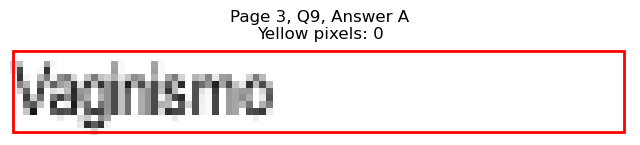

Page 3, Q9 - B: Detected box: x0=71.3, y0=651.5, x1=172.7, y1=663.6
Page 3, Q9, B: Yellow pixels: 0
Page 3, Q9, B: Total non-white pixels: 509
Page 3, Q9, B: Yellow percentage: 0.0%


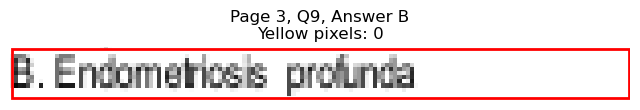

Page 3, Q9 - C: Detected box: x0=71.3, y0=663.5, x1=148.0, y1=675.6
Page 3, Q9, C: Yellow pixels: 0
Page 3, Q9, C: Total non-white pixels: 370
Page 3, Q9, C: Yellow percentage: 0.0%


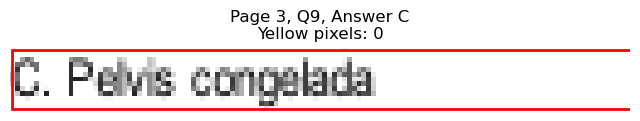

Page 3, Q9 - D: Detected box: x0=322.9, y0=639.5, x1=386.1, y1=651.6
Page 3, Q9, D: Yellow pixels: 532
Page 3, Q9, D: Total non-white pixels: 806
Page 3, Q9, D: Yellow percentage: 66.0%


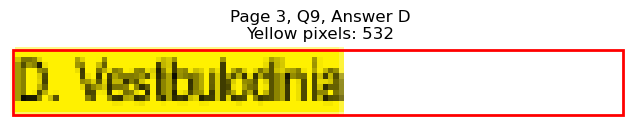

Page 3, Q9 - E: Detected box: x0=322.9, y0=651.5, x1=455.0, y1=663.6
Page 3, Q9, E: Yellow pixels: 61
Page 3, Q9, E: Total non-white pixels: 875
Page 3, Q9, E: Yellow percentage: 7.0%


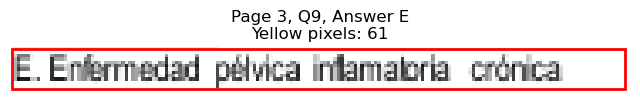


Page 3, Q9 - Selected Answer: D (based on yellow pixel count)




Page 3, Q10 - A: Detected box: x0=71.3, y0=712.3, x1=79.7, y1=724.4
Page 3, Q10, A: Yellow pixels: 0
Page 3, Q10, A: Total non-white pixels: 60
Page 3, Q10, A: Yellow percentage: 0.0%


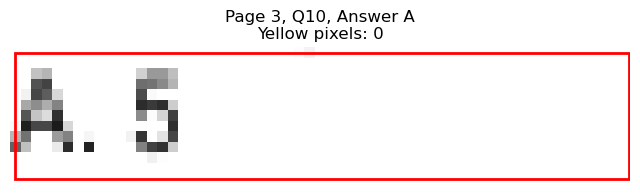

Page 3, Q10 - B: Detected box: x0=71.3, y0=724.3, x1=88.7, y1=736.4
Page 3, Q10, B: Yellow pixels: 132
Page 3, Q10, B: Total non-white pixels: 208
Page 3, Q10, B: Yellow percentage: 63.5%


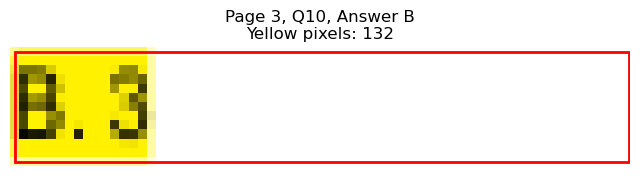

Page 3, Q10 - C: Detected box: x0=71.3, y0=736.4, x1=89.5, y1=748.4
Page 3, Q10, C: Yellow pixels: 0
Page 3, Q10, C: Total non-white pixels: 67
Page 3, Q10, C: Yellow percentage: 0.0%


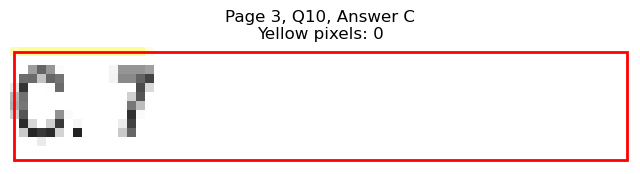

Page 3, Q10 - D: Detected box: x0=322.9, y0=712.3, x1=341.0, y1=724.4
Page 3, Q10, D: Yellow pixels: 0
Page 3, Q10, D: Total non-white pixels: 63
Page 3, Q10, D: Yellow percentage: 0.0%


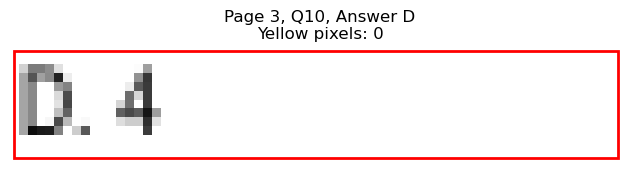

Page 3, Q10 - E: Detected box: x0=322.9, y0=724.3, x1=343.3, y1=736.4
Page 3, Q10, E: Yellow pixels: 0
Page 3, Q10, E: Total non-white pixels: 61
Page 3, Q10, E: Yellow percentage: 0.0%


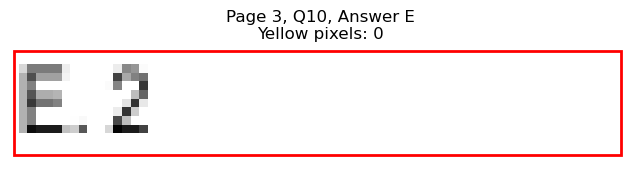


Page 3, Q10 - Selected Answer: B (based on yellow pixel count)





Page 4: Found 10 questions
Page 4, Q1 - A: Detected box: x0=82.6, y0=109.5, x1=130.8, y1=121.6
Page 4, Q1, A: Yellow pixels: 0
Page 4, Q1, A: Total non-white pixels: 239
Page 4, Q1, A: Yellow percentage: 0.0%


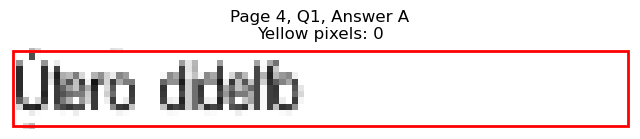

Page 4, Q1 - B: Detected box: x0=71.3, y0=121.5, x1=142.0, y1=133.6
Page 4, Q1, B: Yellow pixels: 0
Page 4, Q1, B: Total non-white pixels: 357
Page 4, Q1, B: Yellow percentage: 0.0%


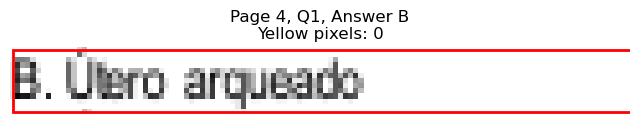

Page 4, Q1 - C: Detected box: x0=71.3, y0=133.5, x1=135.3, y1=145.6
Page 4, Q1, C: Yellow pixels: 525
Page 4, Q1, C: Total non-white pixels: 806
Page 4, Q1, C: Yellow percentage: 65.1%


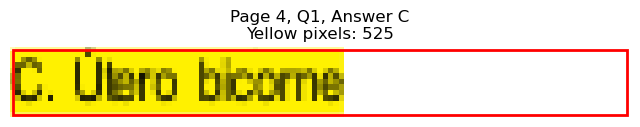

Page 4, Q1 - D: Detected box: x0=322.9, y0=109.5, x1=379.3, y1=121.6
Page 4, Q1, D: Yellow pixels: 0
Page 4, Q1, D: Total non-white pixels: 277
Page 4, Q1, D: Yellow percentage: 0.0%


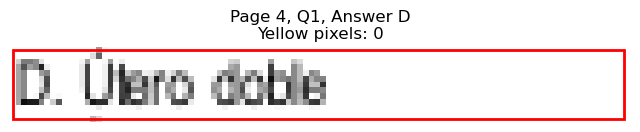

Page 4, Q1 - E: Detected box: x0=322.9, y0=121.5, x1=399.5, y1=133.6
Page 4, Q1, E: Yellow pixels: 0
Page 4, Q1, E: Total non-white pixels: 378
Page 4, Q1, E: Yellow percentage: 0.0%


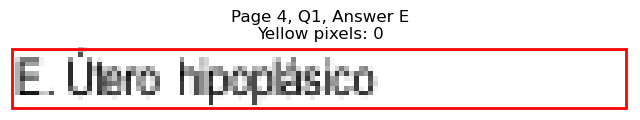


Page 4, Q1 - Selected Answer: C (based on yellow pixel count)




Page 4, Q2 - A: Detected box: x0=82.6, y0=181.6, x1=191.5, y1=193.6
Page 4, Q2, A: Yellow pixels: 0
Page 4, Q2, A: Total non-white pixels: 496
Page 4, Q2, A: Yellow percentage: 0.0%


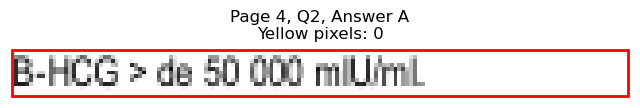

Page 4, Q2 - B: Detected box: x0=71.3, y0=193.6, x1=167.5, y1=205.6
Page 4, Q2, B: Yellow pixels: 1135
Page 4, Q2, B: Total non-white pixels: 1781
Page 4, Q2, B: Yellow percentage: 63.7%


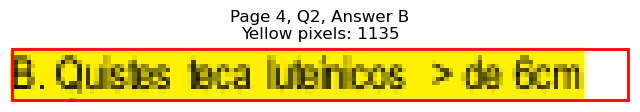

Page 4, Q2 - C: Detected box: x0=71.3, y0=205.6, x1=235.0, y1=217.7
Page 4, Q2, C: Yellow pixels: 135
Page 4, Q2, C: Total non-white pixels: 922
Page 4, Q2, C: Yellow percentage: 14.6%


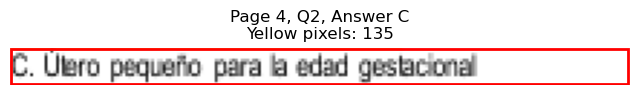

Page 4, Q2 - D: Detected box: x0=322.9, y0=181.6, x1=452.2, y1=193.6
Page 4, Q2, D: Yellow pixels: 0
Page 4, Q2, D: Total non-white pixels: 614
Page 4, Q2, D: Yellow percentage: 0.0%


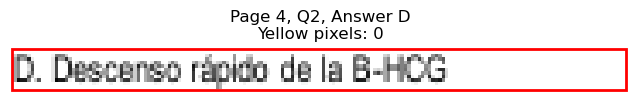

Page 4, Q2 - E: Detected box: x0=322.9, y0=193.6, x1=380.8, y1=205.6
Page 4, Q2, E: Yellow pixels: 0
Page 4, Q2, E: Total non-white pixels: 280
Page 4, Q2, E: Yellow percentage: 0.0%


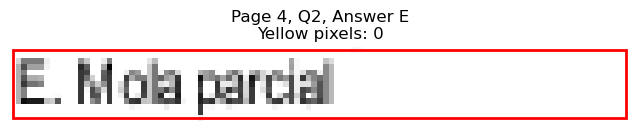


Page 4, Q2 - Selected Answer: B (based on yellow pixel count)




Page 4, Q3 - A: Detected box: x0=82.6, y0=253.6, x1=191.5, y1=265.7
Page 4, Q3, A: Yellow pixels: 0
Page 4, Q3, A: Total non-white pixels: 545
Page 4, Q3, A: Yellow percentage: 0.0%


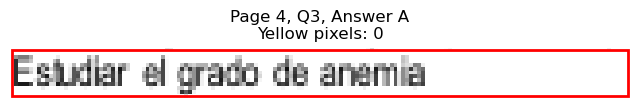

Page 4, Q3 - B: Detected box: x0=71.3, y0=265.7, x1=171.3, y1=277.7
Page 4, Q3, B: Yellow pixels: 0
Page 4, Q3, B: Total non-white pixels: 470
Page 4, Q3, B: Yellow percentage: 0.0%


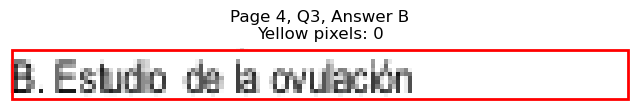

Page 4, Q3 - C: Detected box: x0=71.3, y0=277.7, x1=162.3, y1=289.7
Page 4, Q3, C: Yellow pixels: 721
Page 4, Q3, C: Total non-white pixels: 1157
Page 4, Q3, C: Yellow percentage: 62.3%


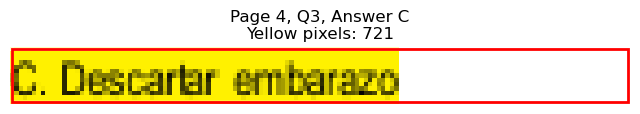

Page 4, Q3 - D: Detected box: x0=322.9, y0=253.6, x1=462.6, y1=265.7
Page 4, Q3, D: Yellow pixels: 0
Page 4, Q3, D: Total non-white pixels: 692
Page 4, Q3, D: Yellow percentage: 0.0%


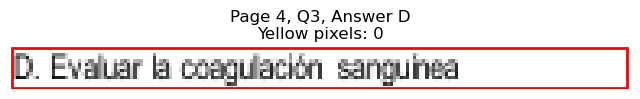

Page 4, Q3 - E: Detected box: x0=322.9, y0=265.7, x1=424.3, y1=277.7
Page 4, Q3, E: Yellow pixels: 0
Page 4, Q3, E: Total non-white pixels: 494
Page 4, Q3, E: Yellow percentage: 0.0%


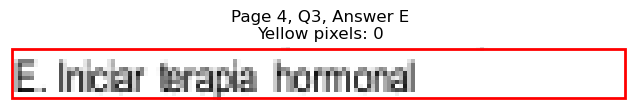


Page 4, Q3 - Selected Answer: C (based on yellow pixel count)




Page 4, Q4 - A: Detected box: x0=71.3, y0=326.5, x1=79.7, y1=338.5
Page 4, Q4, A: Yellow pixels: 0
Page 4, Q4, A: Total non-white pixels: 48
Page 4, Q4, A: Yellow percentage: 0.0%


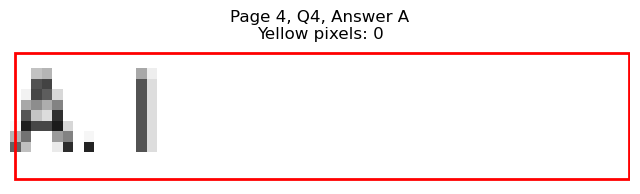

Page 4, Q4 - B: Detected box: x0=71.3, y0=338.5, x1=91.0, y1=350.5
Page 4, Q4, B: Yellow pixels: 0
Page 4, Q4, B: Total non-white pixels: 82
Page 4, Q4, B: Yellow percentage: 0.0%


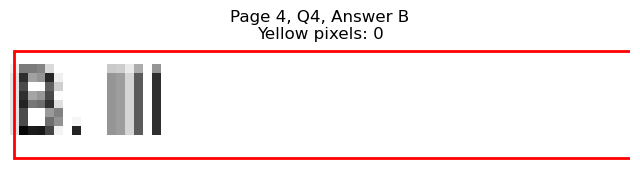

Page 4, Q4 - C: Detected box: x0=71.3, y0=350.5, x1=92.5, y1=362.5
Page 4, Q4, C: Yellow pixels: 0
Page 4, Q4, C: Total non-white pixels: 73
Page 4, Q4, C: Yellow percentage: 0.0%


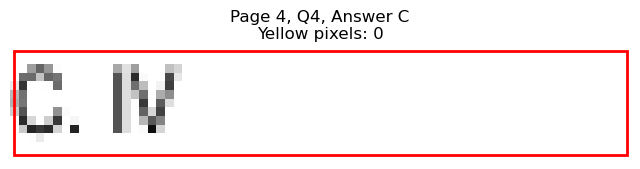

Page 4, Q4 - D: Detected box: x0=322.9, y0=326.5, x1=341.0, y1=338.5
Page 4, Q4, D: Yellow pixels: 0
Page 4, Q4, D: Total non-white pixels: 71
Page 4, Q4, D: Yellow percentage: 0.0%


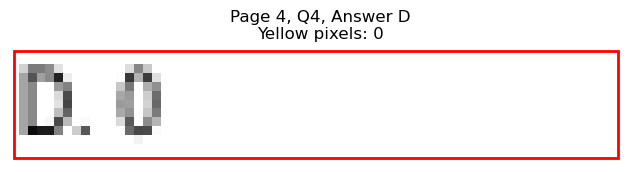

Page 4, Q4 - E: Detected box: x0=322.9, y0=338.5, x1=340.3, y1=350.5
Page 4, Q4, E: Yellow pixels: 138
Page 4, Q4, E: Total non-white pixels: 208
Page 4, Q4, E: Yellow percentage: 66.3%


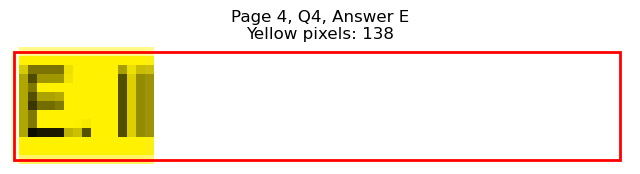


Page 4, Q4 - Selected Answer: E (based on yellow pixel count)




Page 4, Q5 - A: Detected box: x0=82.6, y0=398.5, x1=225.2, y1=410.6
Page 4, Q5, A: Yellow pixels: 0
Page 4, Q5, A: Total non-white pixels: 701
Page 4, Q5, A: Yellow percentage: 0.0%


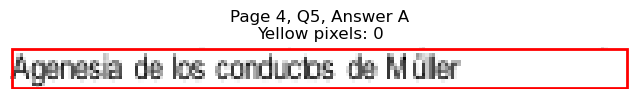

Page 4, Q5 - B: Detected box: x0=71.3, y0=410.5, x1=261.4, y1=422.6
Page 4, Q5, B: Yellow pixels: 0
Page 4, Q5, B: Total non-white pixels: 961
Page 4, Q5, B: Yellow percentage: 0.0%


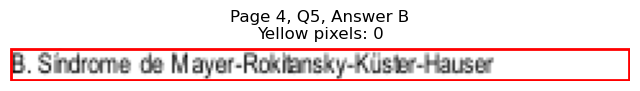

Page 4, Q5 - C: Detected box: x0=71.3, y0=422.5, x1=158.5, y1=434.6
Page 4, Q5, C: Yellow pixels: 0
Page 4, Q5, C: Total non-white pixels: 434
Page 4, Q5, C: Yellow percentage: 0.0%


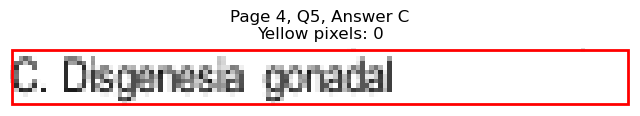

Page 4, Q5 - D: Detected box: x0=322.9, y0=398.5, x1=422.7, y1=410.6
Page 4, Q5, D: Yellow pixels: 0
Page 4, Q5, D: Total non-white pixels: 477
Page 4, Q5, D: Yellow percentage: 0.0%


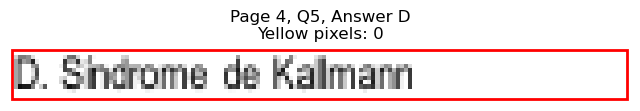

Page 4, Q5 - E: Detected box: x0=388.1, y0=410.5, x1=454.5, y1=422.6
Page 4, Q5, E: Yellow pixels: 497
Page 4, Q5, E: Total non-white pixels: 845
Page 4, Q5, E: Yellow percentage: 58.8%


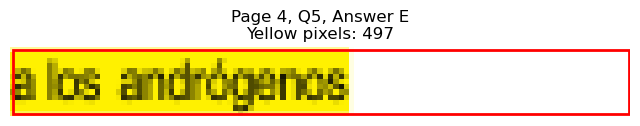


Page 4, Q5 - Selected Answer: E (based on yellow pixel count)




Page 4, Q6 - A: Detected box: x0=82.6, y0=458.6, x1=121.0, y1=470.6
Page 4, Q6, A: Yellow pixels: 0
Page 4, Q6, A: Total non-white pixels: 225
Page 4, Q6, A: Yellow percentage: 0.0%


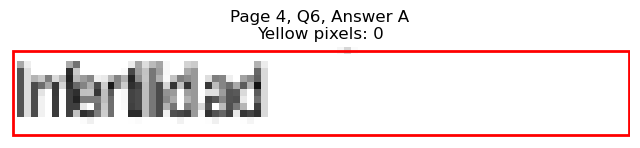

Page 4, Q6 - B: Detected box: x0=71.3, y0=470.6, x1=119.5, y1=482.6
Page 4, Q6, B: Yellow pixels: 0
Page 4, Q6, B: Total non-white pixels: 247
Page 4, Q6, B: Yellow percentage: 0.0%


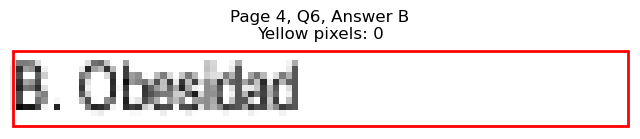

Page 4, Q6 - C: Detected box: x0=71.3, y0=483.4, x1=157.1, y1=495.4
Page 4, Q6, C: Yellow pixels: 746
Page 4, Q6, C: Total non-white pixels: 1092
Page 4, Q6, C: Yellow percentage: 68.3%


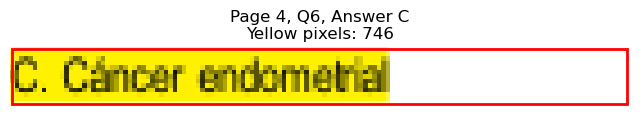

Page 4, Q6 - D: Detected box: x0=322.9, y0=458.6, x1=426.5, y1=470.6
Page 4, Q6, D: Yellow pixels: 0
Page 4, Q6, D: Total non-white pixels: 494
Page 4, Q6, D: Yellow percentage: 0.0%


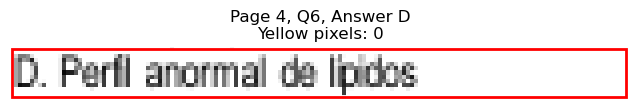

Page 4, Q6 - E: Detected box: x0=322.9, y0=470.6, x1=377.0, y1=482.6
Page 4, Q6, E: Yellow pixels: 0
Page 4, Q6, E: Total non-white pixels: 499
Page 4, Q6, E: Yellow percentage: 0.0%


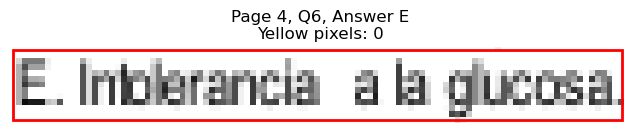


Page 4, Q6 - Selected Answer: C (based on yellow pixel count)




Page 4, Q7 - A: Detected box: x0=82.6, y0=519.4, x1=99.2, y1=531.4
Page 4, Q7, A: Yellow pixels: 0
Page 4, Q7, A: Total non-white pixels: 58
Page 4, Q7, A: Yellow percentage: 0.0%


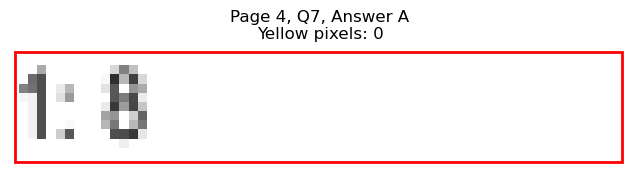

Page 4, Q7 - B: Detected box: x0=71.3, y0=531.4, x1=98.5, y1=543.5
Page 4, Q7, B: Yellow pixels: 0
Page 4, Q7, B: Total non-white pixels: 85
Page 4, Q7, B: Yellow percentage: 0.0%


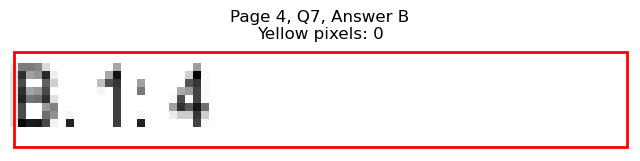

Page 4, Q7 - C: Detected box: x0=71.3, y0=543.4, x1=103.0, y1=555.5
Page 4, Q7, C: Yellow pixels: 0
Page 4, Q7, C: Total non-white pixels: 106
Page 4, Q7, C: Yellow percentage: 0.0%


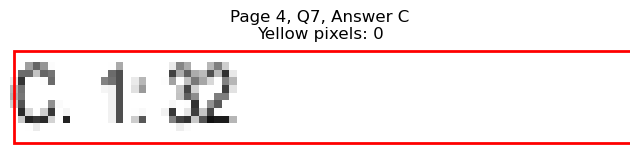

Page 4, Q7 - D: Detected box: x0=322.9, y0=519.4, x1=350.0, y1=531.4
Page 4, Q7, D: Yellow pixels: 0
Page 4, Q7, D: Total non-white pixels: 94
Page 4, Q7, D: Yellow percentage: 0.0%


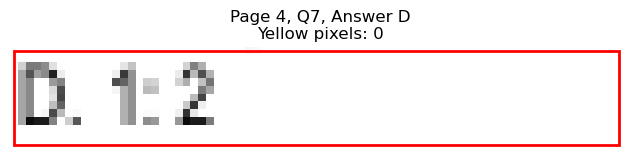

Page 4, Q7 - E: Detected box: x0=322.9, y0=531.4, x1=354.6, y1=543.5
Page 4, Q7, E: Yellow pixels: 289
Page 4, Q7, E: Total non-white pixels: 403
Page 4, Q7, E: Yellow percentage: 71.7%


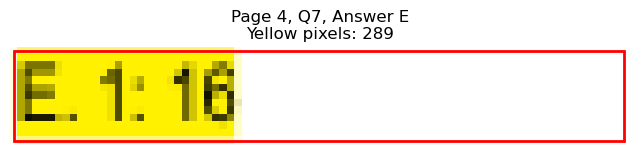


Page 4, Q7 - Selected Answer: E (based on yellow pixel count)




Page 4, Q8 - A: Detected box: x0=82.6, y0=591.5, x1=181.1, y1=603.5
Page 4, Q8, A: Yellow pixels: 0
Page 4, Q8, A: Total non-white pixels: 519
Page 4, Q8, A: Yellow percentage: 0.0%


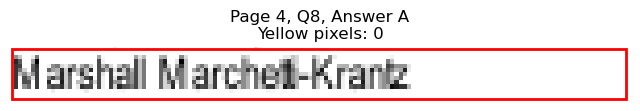

Page 4, Q8 - B: Detected box: x0=71.3, y0=603.5, x1=106.8, y1=615.5
Page 4, Q8, B: Yellow pixels: 304
Page 4, Q8, B: Total non-white pixels: 442
Page 4, Q8, B: Yellow percentage: 68.8%


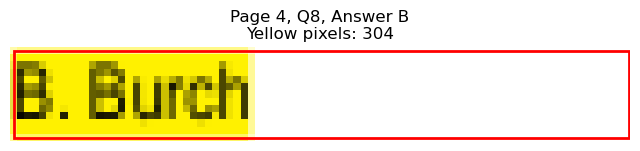

Page 4, Q8 - C: Detected box: x0=71.3, y0=615.5, x1=115.0, y1=627.5
Page 4, Q8, C: Yellow pixels: 33
Page 4, Q8, C: Total non-white pixels: 222
Page 4, Q8, C: Yellow percentage: 14.9%


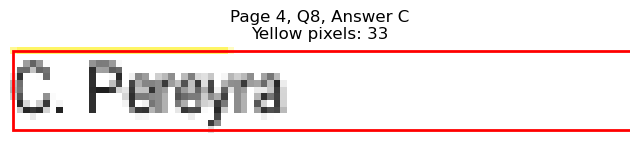

Page 4, Q8 - D: Detected box: x0=322.9, y0=591.5, x1=390.5, y1=603.5
Page 4, Q8, D: Yellow pixels: 0
Page 4, Q8, D: Total non-white pixels: 335
Page 4, Q8, D: Yellow percentage: 0.0%


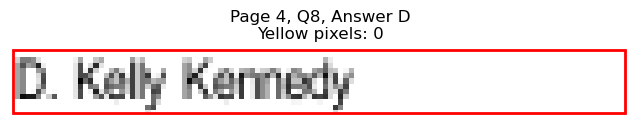

Page 4, Q8 - E: Detected box: x0=322.9, y0=603.5, x1=359.8, y1=615.5
Page 4, Q8, E: Yellow pixels: 0
Page 4, Q8, E: Total non-white pixels: 177
Page 4, Q8, E: Yellow percentage: 0.0%


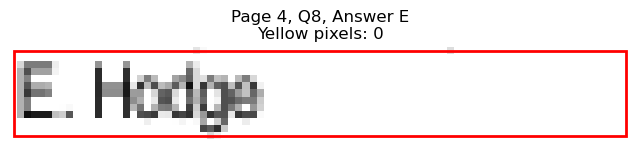


Page 4, Q8 - Selected Answer: B (based on yellow pixel count)




Page 4, Q9 - A: Detected box: x0=120.2, y0=651.5, x1=265.0, y1=663.6
Page 4, Q9, A: Yellow pixels: 0
Page 4, Q9, A: Total non-white pixels: 668
Page 4, Q9, A: Yellow percentage: 0.0%


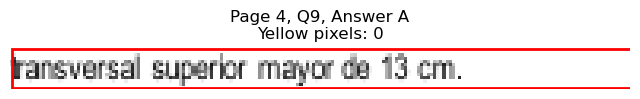

Page 4, Q9 - B: Detected box: x0=71.3, y0=663.5, x1=150.2, y1=675.6
Page 4, Q9, B: Yellow pixels: 0
Page 4, Q9, B: Total non-white pixels: 516
Page 4, Q9, B: Yellow percentage: 0.0%


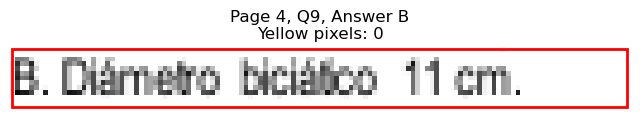

Page 4, Q9 - C: Detected box: x0=71.3, y0=676.3, x1=163.0, y1=688.3
Page 4, Q9, C: Yellow pixels: 1196
Page 4, Q9, C: Total non-white pixels: 1859
Page 4, Q9, C: Yellow percentage: 64.3%


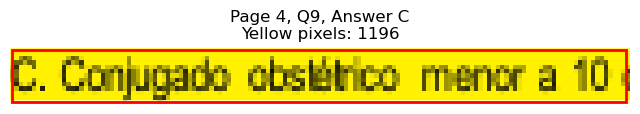

Page 4, Q9 - D: Detected box: x0=322.9, y0=651.5, x1=416.1, y1=663.6
Page 4, Q9, D: Yellow pixels: 0
Page 4, Q9, D: Total non-white pixels: 549
Page 4, Q9, D: Yellow percentage: 0.0%


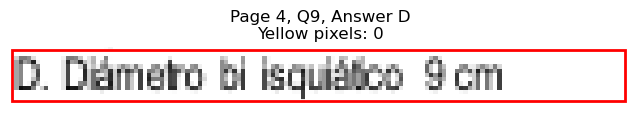

Page 4, Q9 - E: Detected box: x0=377.6, y0=663.5, x1=479.8, y1=675.6
Page 4, Q9, E: Yellow pixels: 0
Page 4, Q9, E: Total non-white pixels: 458
Page 4, Q9, E: Yellow percentage: 0.0%


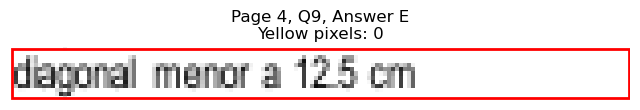


Page 4, Q9 - Selected Answer: C (based on yellow pixel count)




Page 4, Q10 - A: Detected box: x0=82.6, y0=724.3, x1=124.8, y1=736.4
Page 4, Q10, A: Yellow pixels: 0
Page 4, Q10, A: Total non-white pixels: 226
Page 4, Q10, A: Yellow percentage: 0.0%


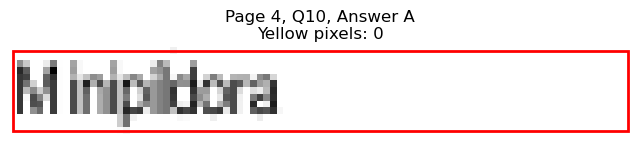

Page 4, Q10 - B: Detected box: x0=71.3, y0=736.4, x1=167.5, y1=748.4
Page 4, Q10, B: Yellow pixels: 0
Page 4, Q10, B: Total non-white pixels: 489
Page 4, Q10, B: Yellow percentage: 0.0%


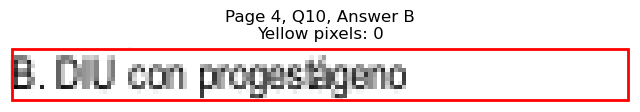

Page 4, Q10 - C: Detected box: x0=71.3, y0=748.4, x1=184.0, y1=760.4
Page 4, Q10, C: Yellow pixels: 0
Page 4, Q10, C: Total non-white pixels: 574
Page 4, Q10, C: Yellow percentage: 0.0%


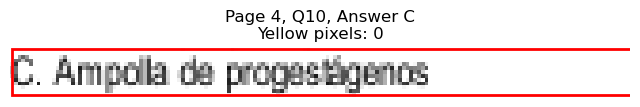

Page 4, Q10 - D: Detected box: x0=322.9, y0=724.3, x1=362.0, y1=736.4
Page 4, Q10, D: Yellow pixels: 0
Page 4, Q10, D: Total non-white pixels: 187
Page 4, Q10, D: Yellow percentage: 0.0%


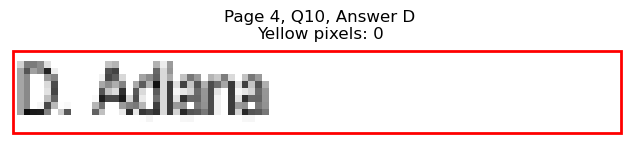

Page 4, Q10 - E: Detected box: x0=322.9, y0=736.4, x1=414.7, y1=748.4
Page 4, Q10, E: Yellow pixels: 797
Page 4, Q10, E: Total non-white pixels: 1183
Page 4, Q10, E: Yellow percentage: 67.4%


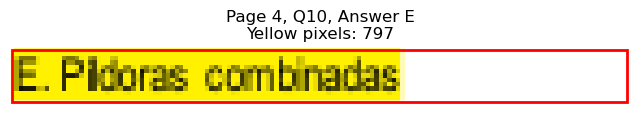


Page 4, Q10 - Selected Answer: E (based on yellow pixel count)





Page 5: Found 10 questions
Page 5, Q1 - A: Detected box: x0=82.6, y0=109.5, x1=185.5, y1=121.6
Page 5, Q1, A: Yellow pixels: 0
Page 5, Q1, A: Total non-white pixels: 516
Page 5, Q1, A: Yellow percentage: 0.0%


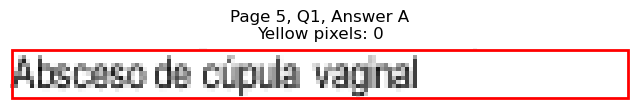

Page 5, Q1 - B: Detected box: x0=71.3, y0=121.5, x1=193.9, y1=133.6
Page 5, Q1, B: Yellow pixels: 1091
Page 5, Q1, B: Total non-white pixels: 1573
Page 5, Q1, B: Yellow percentage: 69.4%


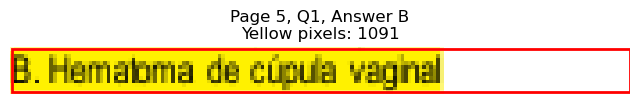

Page 5, Q1 - C: Detected box: x0=114.8, y0=133.5, x1=183.2, y1=145.6
Page 5, Q1, C: Yellow pixels: 77
Page 5, Q1, C: Total non-white pixels: 420
Page 5, Q1, C: Yellow percentage: 18.3%


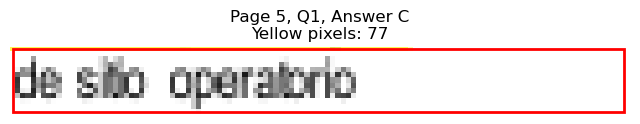

Page 5, Q1 - D: Detected box: x0=322.9, y0=109.5, x1=397.3, y1=121.6
Page 5, Q1, D: Yellow pixels: 0
Page 5, Q1, D: Total non-white pixels: 368
Page 5, Q1, D: Yellow percentage: 0.0%


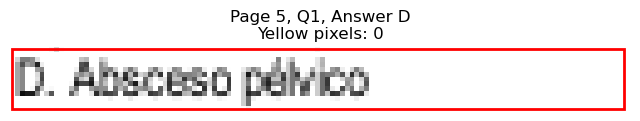

Page 5, Q1 - E: Detected box: x0=322.9, y0=121.5, x1=450.5, y1=133.6
Page 5, Q1, E: Yellow pixels: 0
Page 5, Q1, E: Total non-white pixels: 627
Page 5, Q1, E: Yellow percentage: 0.0%


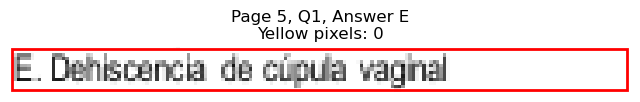


Page 5, Q1 - Selected Answer: B (based on yellow pixel count)




Page 5, Q2 - A: Detected box: x0=82.6, y0=181.6, x1=204.2, y1=193.6
Page 5, Q2, A: Yellow pixels: 0
Page 5, Q2, A: Total non-white pixels: 655
Page 5, Q2, A: Yellow percentage: 0.0%


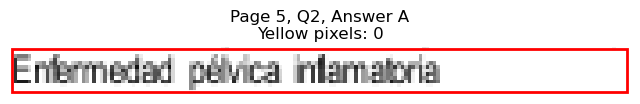

Page 5, Q2 - B: Detected box: x0=71.3, y0=193.6, x1=136.8, y1=205.6
Page 5, Q2, B: Yellow pixels: 503
Page 5, Q2, B: Total non-white pixels: 832
Page 5, Q2, B: Yellow percentage: 60.5%


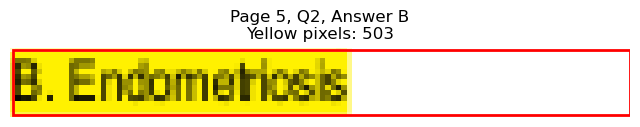

Page 5, Q2 - C: Detected box: x0=71.3, y0=205.6, x1=166.7, y1=217.7
Page 5, Q2, C: Yellow pixels: 63
Page 5, Q2, C: Total non-white pixels: 533
Page 5, Q2, C: Yellow percentage: 11.8%


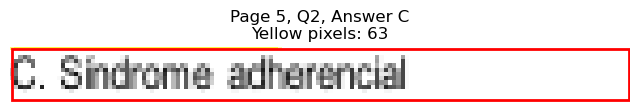

Page 5, Q2 - D: Detected box: x0=322.9, y0=181.6, x1=431.0, y1=193.6
Page 5, Q2, D: Yellow pixels: 0
Page 5, Q2, D: Total non-white pixels: 536
Page 5, Q2, D: Yellow percentage: 0.0%


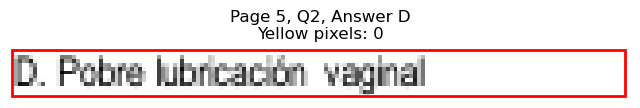

Page 5, Q2 - E: Detected box: x0=322.9, y0=193.6, x1=395.1, y1=205.6
Page 5, Q2, E: Yellow pixels: 0
Page 5, Q2, E: Total non-white pixels: 364
Page 5, Q2, E: Yellow percentage: 0.0%


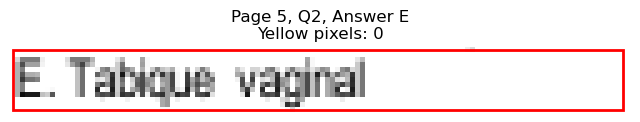


Page 5, Q2 - Selected Answer: B (based on yellow pixel count)




Page 5, Q3 - A: Detected box: x0=82.6, y0=253.6, x1=180.2, y1=265.7
Page 5, Q3, A: Yellow pixels: 0
Page 5, Q3, A: Total non-white pixels: 572
Page 5, Q3, A: Yellow percentage: 0.0%


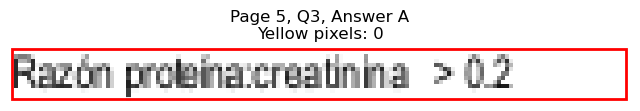

Page 5, Q3 - B: Detected box: x0=71.3, y0=265.7, x1=174.4, y1=277.7
Page 5, Q3, B: Yellow pixels: 833
Page 5, Q3, B: Total non-white pixels: 1313
Page 5, Q3, B: Yellow percentage: 63.4%


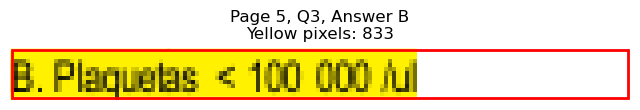

Page 5, Q3 - C: Detected box: x0=71.3, y0=277.7, x1=121.0, y1=289.7
Page 5, Q3, C: Yellow pixels: 99
Page 5, Q3, C: Total non-white pixels: 476
Page 5, Q3, C: Yellow percentage: 20.8%


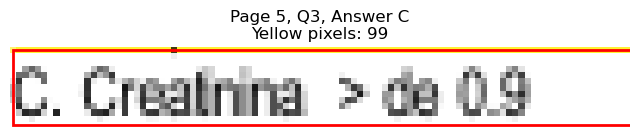

Page 5, Q3 - D: Detected box: x0=322.9, y0=253.6, x1=514.2, y1=265.7
Page 5, Q3, D: Yellow pixels: 0
Page 5, Q3, D: Total non-white pixels: 931
Page 5, Q3, D: Yellow percentage: 0.0%


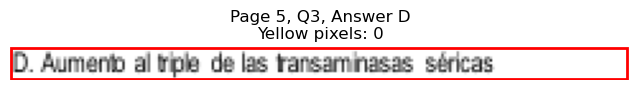

Page 5, Q3 - E: Detected box: x0=322.9, y0=265.7, x1=395.8, y1=277.7
Page 5, Q3, E: Yellow pixels: 0
Page 5, Q3, E: Total non-white pixels: 571
Page 5, Q3, E: Yellow percentage: 0.0%


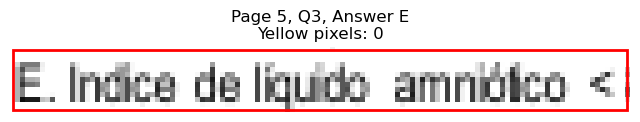


Page 5, Q3 - Selected Answer: B (based on yellow pixel count)




Page 5, Q4 - A: Detected box: x0=82.6, y0=314.5, x1=122.5, y1=326.5
Page 5, Q4, A: Yellow pixels: 0
Page 5, Q4, A: Total non-white pixels: 206
Page 5, Q4, A: Yellow percentage: 0.0%


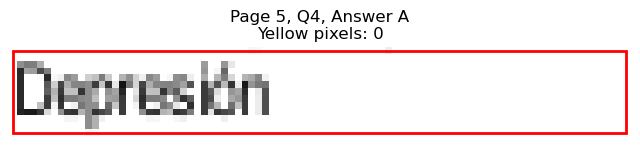

Page 5, Q4 - B: Detected box: x0=71.3, y0=326.5, x1=118.0, y1=338.5
Page 5, Q4, B: Yellow pixels: 0
Page 5, Q4, B: Total non-white pixels: 223
Page 5, Q4, B: Yellow percentage: 0.0%


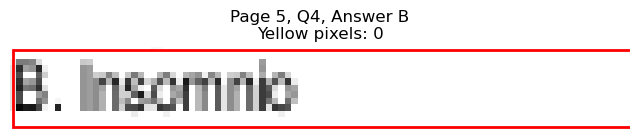

Page 5, Q4 - C: Detected box: x0=71.3, y0=338.5, x1=151.8, y1=350.5
Page 5, Q4, C: Yellow pixels: 709
Page 5, Q4, C: Total non-white pixels: 1027
Page 5, Q4, C: Yellow percentage: 69.0%


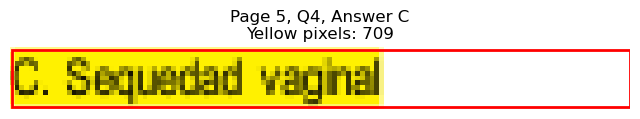

Page 5, Q4 - D: Detected box: x0=322.9, y0=314.5, x1=374.8, y1=326.5
Page 5, Q4, D: Yellow pixels: 0
Page 5, Q4, D: Total non-white pixels: 275
Page 5, Q4, D: Yellow percentage: 0.0%


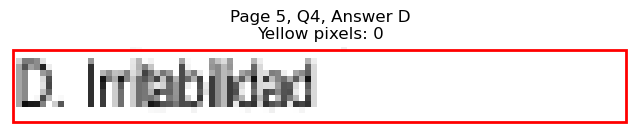

Page 5, Q4 - E: Detected box: x0=322.9, y0=326.5, x1=371.8, y1=338.5
Page 5, Q4, E: Yellow pixels: 0
Page 5, Q4, E: Total non-white pixels: 223
Page 5, Q4, E: Yellow percentage: 0.0%


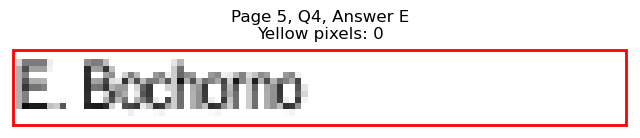


Page 5, Q4 - Selected Answer: C (based on yellow pixel count)




Page 5, Q5 - A: Detected box: x0=82.6, y0=374.5, x1=127.0, y1=386.6
Page 5, Q5, A: Yellow pixels: 0
Page 5, Q5, A: Total non-white pixels: 238
Page 5, Q5, A: Yellow percentage: 0.0%


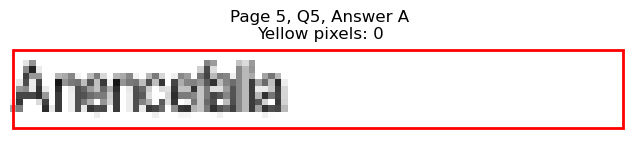

Page 5, Q5 - B: Detected box: x0=71.3, y0=386.5, x1=112.7, y1=398.6
Page 5, Q5, B: Yellow pixels: 0
Page 5, Q5, B: Total non-white pixels: 195
Page 5, Q5, B: Yellow percentage: 0.0%


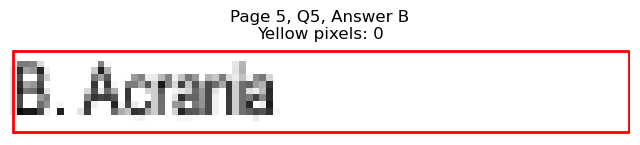

Page 5, Q5 - C: Detected box: x0=71.3, y0=398.5, x1=129.3, y1=410.6
Page 5, Q5, C: Yellow pixels: 498
Page 5, Q5, C: Total non-white pixels: 728
Page 5, Q5, C: Yellow percentage: 68.4%


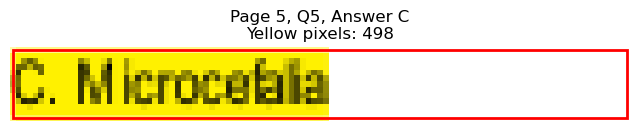

Page 5, Q5 - D: Detected box: x0=322.9, y0=374.5, x1=386.8, y1=386.6
Page 5, Q5, D: Yellow pixels: 0
Page 5, Q5, D: Total non-white pixels: 327
Page 5, Q5, D: Yellow percentage: 0.0%


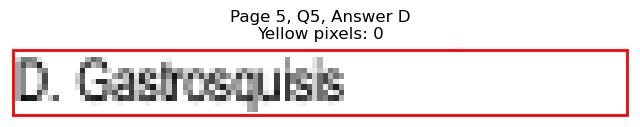

Page 5, Q5 - E: Detected box: x0=322.9, y0=386.5, x1=400.3, y1=398.6
Page 5, Q5, E: Yellow pixels: 0
Page 5, Q5, E: Total non-white pixels: 413
Page 5, Q5, E: Yellow percentage: 0.0%


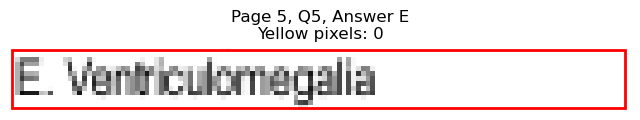


Page 5, Q5 - Selected Answer: C (based on yellow pixel count)




Page 5, Q6 - A: Detected box: x0=82.6, y0=434.6, x1=142.8, y1=446.6
Page 5, Q6, A: Yellow pixels: 450
Page 5, Q6, A: Total non-white pixels: 769
Page 5, Q6, A: Yellow percentage: 58.5%


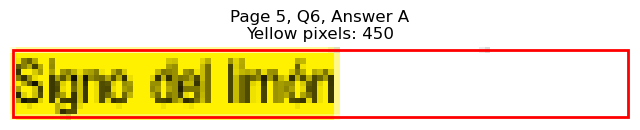

Page 5, Q6 - B: Detected box: x0=71.3, y0=446.6, x1=146.5, y1=458.6
Page 5, Q6, B: Yellow pixels: 57
Page 5, Q6, B: Total non-white pixels: 433
Page 5, Q6, B: Yellow percentage: 13.2%


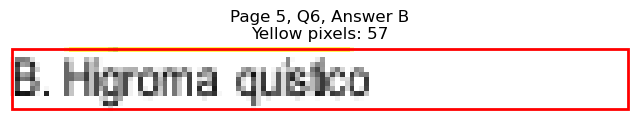

Page 5, Q6 - C: Detected box: x0=71.3, y0=458.6, x1=160.0, y1=470.6
Page 5, Q6, C: Yellow pixels: 0
Page 5, Q6, C: Total non-white pixels: 429
Page 5, Q6, C: Yellow percentage: 0.0%


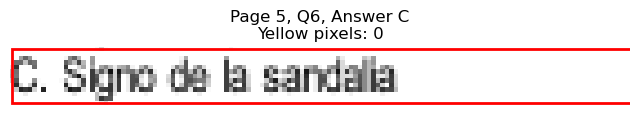

Page 5, Q6 - D: Detected box: x0=322.9, y0=434.6, x1=403.3, y1=446.6
Page 5, Q6, D: Yellow pixels: 0
Page 5, Q6, D: Total non-white pixels: 357
Page 5, Q6, D: Yellow percentage: 0.0%


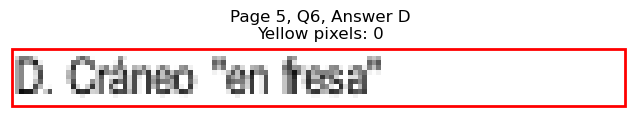

Page 5, Q6 - E: Detected box: x0=322.9, y0=446.6, x1=436.3, y1=458.6
Page 5, Q6, E: Yellow pixels: 0
Page 5, Q6, E: Total non-white pixels: 544
Page 5, Q6, E: Yellow percentage: 0.0%


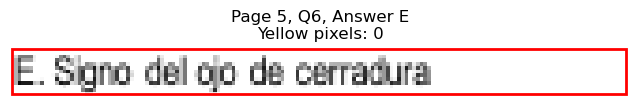


Page 5, Q6 - Selected Answer: A (based on yellow pixel count)




Page 5, Q7 - A: Detected box: x0=82.6, y0=519.4, x1=175.7, y1=531.4
Page 5, Q7, A: Yellow pixels: 0
Page 5, Q7, A: Total non-white pixels: 466
Page 5, Q7, A: Yellow percentage: 0.0%


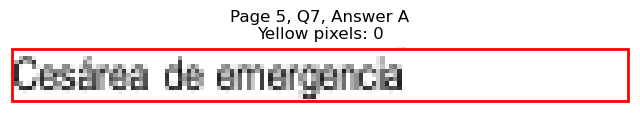

Page 5, Q7 - B: Detected box: x0=71.3, y0=531.4, x1=131.5, y1=543.5
Page 5, Q7, B: Yellow pixels: 0
Page 5, Q7, B: Total non-white pixels: 290
Page 5, Q7, B: Yellow percentage: 0.0%


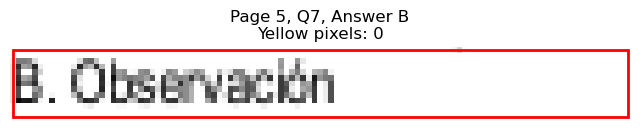

Page 5, Q7 - C: Detected box: x0=71.3, y0=543.4, x1=145.8, y1=555.5
Page 5, Q7, C: Yellow pixels: 656
Page 5, Q7, C: Total non-white pixels: 949
Page 5, Q7, C: Yellow percentage: 69.1%


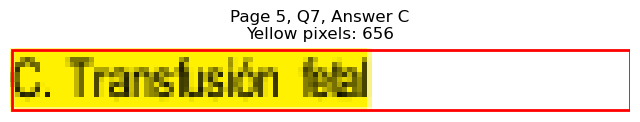

Page 5, Q7 - D: Detected box: x0=322.9, y0=519.4, x1=407.8, y1=531.4
Page 5, Q7, D: Yellow pixels: 0
Page 5, Q7, D: Total non-white pixels: 392
Page 5, Q7, D: Yellow percentage: 0.0%


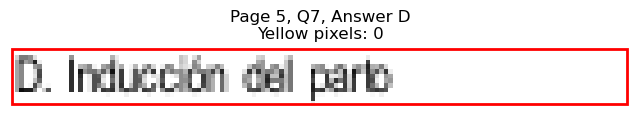

Page 5, Q7 - E: Detected box: x0=322.9, y0=531.4, x1=434.8, y1=543.5
Page 5, Q7, E: Yellow pixels: 0
Page 5, Q7, E: Total non-white pixels: 575
Page 5, Q7, E: Yellow percentage: 0.0%


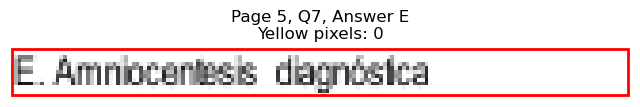


Page 5, Q7 - Selected Answer: C (based on yellow pixel count)




Page 5, Q8 - A: Detected box: x0=82.6, y0=591.5, x1=91.7, y1=603.5
Page 5, Q8, A: Yellow pixels: 0
Page 5, Q8, A: Total non-white pixels: 48
Page 5, Q8, A: Yellow percentage: 0.0%


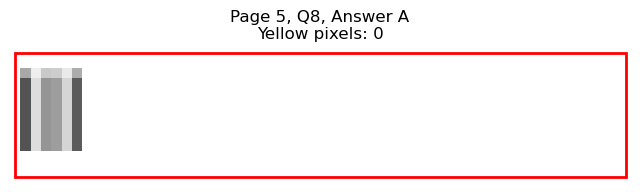

Page 5, Q8 - B: Detected box: x0=71.3, y0=603.5, x1=91.7, y1=615.5
Page 5, Q8, B: Yellow pixels: 0
Page 5, Q8, B: Total non-white pixels: 86
Page 5, Q8, B: Yellow percentage: 0.0%


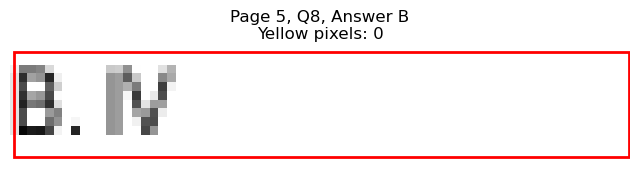

Page 5, Q8 - C: Detected box: x0=71.3, y0=615.5, x1=89.5, y1=627.5
Page 5, Q8, C: Yellow pixels: 0
Page 5, Q8, C: Total non-white pixels: 57
Page 5, Q8, C: Yellow percentage: 0.0%


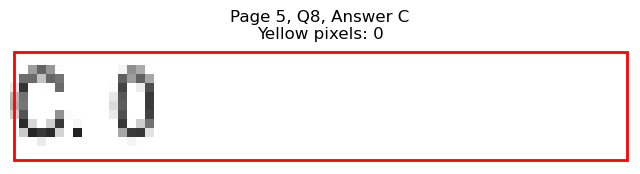

Page 5, Q8 - D: Detected box: x0=322.9, y0=591.5, x1=341.1, y1=603.5
Page 5, Q8, D: Yellow pixels: 157
Page 5, Q8, D: Total non-white pixels: 225
Page 5, Q8, D: Yellow percentage: 69.8%


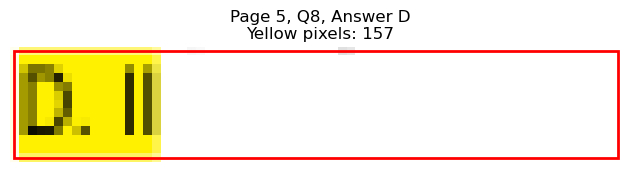

Page 5, Q8 - E: Detected box: x0=322.9, y0=603.5, x1=338.0, y1=615.5
Page 5, Q8, E: Yellow pixels: 16
Page 5, Q8, E: Total non-white pixels: 70
Page 5, Q8, E: Yellow percentage: 22.9%


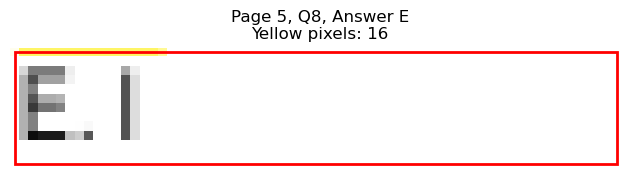


Page 5, Q8 - Selected Answer: D (based on yellow pixel count)




Page 5, Q9 - A: Detected box: x0=82.6, y0=651.5, x1=253.7, y1=663.6
Page 5, Q9, A: Yellow pixels: 0
Page 5, Q9, A: Total non-white pixels: 829
Page 5, Q9, A: Yellow percentage: 0.0%


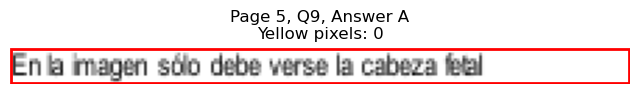

Page 5, Q9 - B: Detected box: x0=71.3, y0=663.5, x1=203.4, y1=675.6
Page 5, Q9, B: Yellow pixels: 0
Page 5, Q9, B: Total non-white pixels: 620
Page 5, Q9, B: Yellow percentage: 0.0%


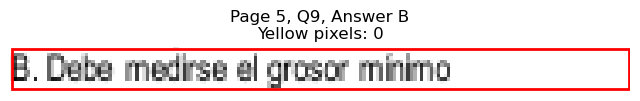

Page 5, Q9 - C: Detected box: x0=71.3, y0=676.3, x1=187.7, y1=688.3
Page 5, Q9, C: Yellow pixels: 0
Page 5, Q9, C: Total non-white pixels: 547
Page 5, Q9, C: Yellow percentage: 0.0%


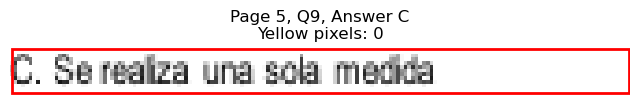

Page 5, Q9 - D: Detected box: x0=322.9, y0=651.5, x1=513.8, y1=663.6
Page 5, Q9, D: Yellow pixels: 1761
Page 5, Q9, D: Total non-white pixels: 2470
Page 5, Q9, D: Yellow percentage: 71.3%


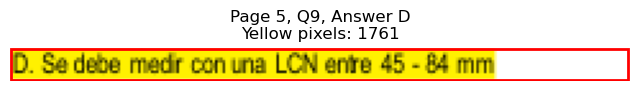

Page 5, Q9 - E: Detected box: x0=360.4, y0=663.5, x1=470.0, y1=675.6
Page 5, Q9, E: Yellow pixels: 151
Page 5, Q9, E: Total non-white pixels: 724
Page 5, Q9, E: Yellow percentage: 20.9%


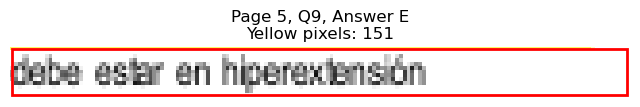


Page 5, Q9 - Selected Answer: D (based on yellow pixel count)




Page 5, Q10 - A: Detected box: x0=150.1, y0=736.4, x1=236.7, y1=748.4
Page 5, Q10, A: Yellow pixels: 737
Page 5, Q10, A: Total non-white pixels: 1105
Page 5, Q10, A: Yellow percentage: 66.7%


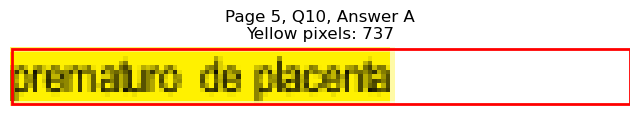

Page 5, Q10 - B: Detected box: x0=71.3, y0=748.4, x1=136.7, y1=760.4
Page 5, Q10, B: Yellow pixels: 104
Page 5, Q10, B: Total non-white pixels: 421
Page 5, Q10, B: Yellow percentage: 24.7%


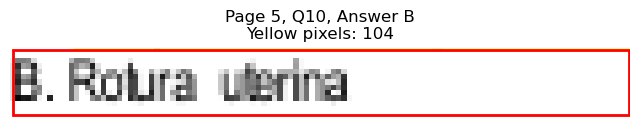

Page 5, Q10 - C: Detected box: x0=71.3, y0=760.4, x1=193.7, y1=772.4
Page 5, Q10, C: Yellow pixels: 0
Page 5, Q10, C: Total non-white pixels: 581
Page 5, Q10, C: Yellow percentage: 0.0%


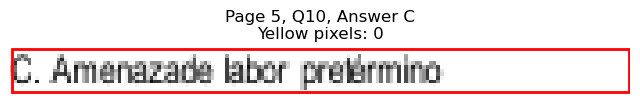

Page 5, Q10 - D: Detected box: x0=322.9, y0=736.4, x1=415.2, y1=748.4
Page 5, Q10, D: Yellow pixels: 0
Page 5, Q10, D: Total non-white pixels: 425
Page 5, Q10, D: Yellow percentage: 0.0%


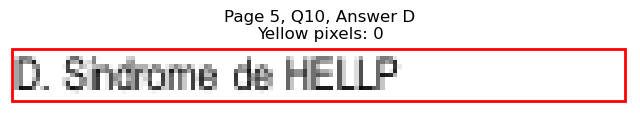

Page 5, Q10 - E: Detected box: x0=322.9, y0=748.4, x1=397.4, y1=760.4
Page 5, Q10, E: Yellow pixels: 0
Page 5, Q10, E: Total non-white pixels: 344
Page 5, Q10, E: Yellow percentage: 0.0%


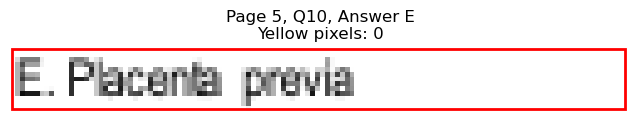


Page 5, Q10 - Selected Answer: A (based on yellow pixel count)





Page 6: Found 10 questions
Page 6, Q1 - A: Detected box: x0=82.6, y0=96.8, x1=254.0, y1=108.8
Page 6, Q1, A: Yellow pixels: 1356
Page 6, Q1, A: Total non-white pixels: 2215
Page 6, Q1, A: Yellow percentage: 61.2%


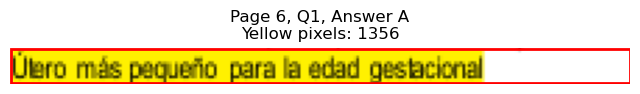

Page 6, Q1 - B: Detected box: x0=71.3, y0=109.5, x1=184.0, y1=121.6
Page 6, Q1, B: Yellow pixels: 151
Page 6, Q1, B: Total non-white pixels: 709
Page 6, Q1, B: Yellow percentage: 21.3%


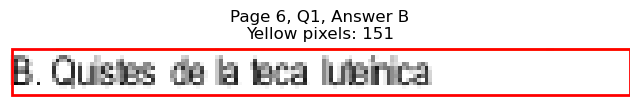

Page 6, Q1 - C: Detected box: x0=71.3, y0=121.5, x1=124.0, y1=133.6
Page 6, Q1, C: Yellow pixels: 0
Page 6, Q1, C: Total non-white pixels: 421
Page 6, Q1, C: Yellow percentage: 0.0%


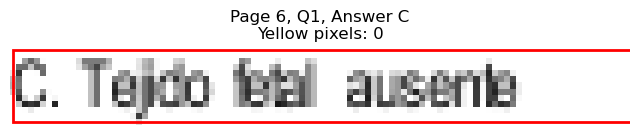

Page 6, Q1 - D: Detected box: x0=322.9, y0=96.8, x1=436.3, y1=108.8
Page 6, Q1, D: Yellow pixels: 0
Page 6, Q1, D: Total non-white pixels: 578
Page 6, Q1, D: Yellow percentage: 0.0%


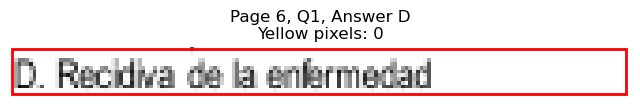

Page 6, Q1 - E: Detected box: x0=322.9, y0=109.5, x1=402.6, y1=121.6
Page 6, Q1, E: Yellow pixels: 0
Page 6, Q1, E: Total non-white pixels: 594
Page 6, Q1, E: Yellow percentage: 0.0%


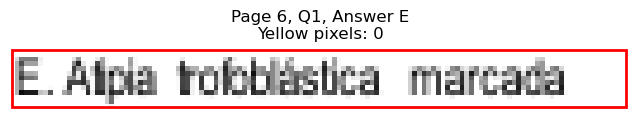


Page 6, Q1 - Selected Answer: A (based on yellow pixel count)




Page 6, Q2 - A: Detected box: x0=82.6, y0=169.6, x1=124.8, y1=181.6
Page 6, Q2, A: Yellow pixels: 0
Page 6, Q2, A: Total non-white pixels: 214
Page 6, Q2, A: Yellow percentage: 0.0%


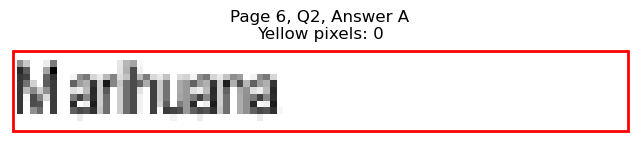

Page 6, Q2 - B: Detected box: x0=71.3, y0=181.6, x1=112.0, y1=193.6
Page 6, Q2, B: Yellow pixels: 0
Page 6, Q2, B: Total non-white pixels: 196
Page 6, Q2, B: Yellow percentage: 0.0%


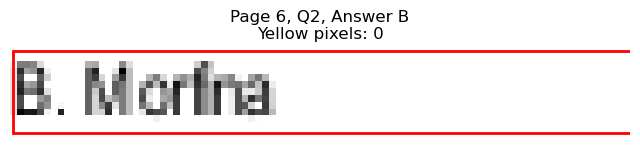

Page 6, Q2 - C: Detected box: x0=71.3, y0=193.6, x1=128.5, y1=205.6
Page 6, Q2, C: Yellow pixels: 0
Page 6, Q2, C: Total non-white pixels: 277
Page 6, Q2, C: Yellow percentage: 0.0%


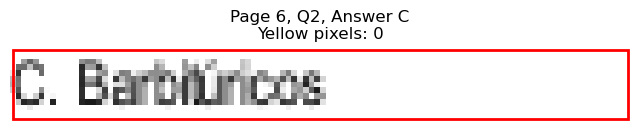

Page 6, Q2 - D: Detected box: x0=322.9, y0=169.6, x1=363.6, y1=181.6
Page 6, Q2, D: Yellow pixels: 307
Page 6, Q2, D: Total non-white pixels: 521
Page 6, Q2, D: Yellow percentage: 58.9%


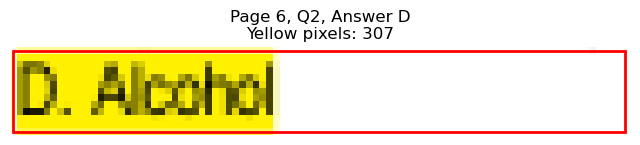

Page 6, Q2 - E: Detected box: x0=322.9, y0=181.6, x1=363.5, y1=193.6
Page 6, Q2, E: Yellow pixels: 38
Page 6, Q2, E: Total non-white pixels: 226
Page 6, Q2, E: Yellow percentage: 16.8%


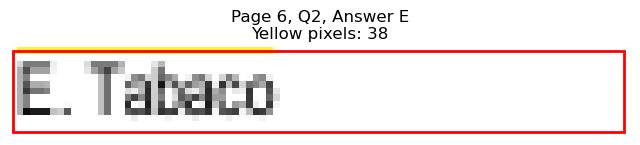


Page 6, Q2 - Selected Answer: D (based on yellow pixel count)




Page 6, Q3 - A: Detected box: x0=82.6, y0=229.6, x1=127.0, y1=241.7
Page 6, Q3, A: Yellow pixels: 0
Page 6, Q3, A: Total non-white pixels: 225
Page 6, Q3, A: Yellow percentage: 0.0%


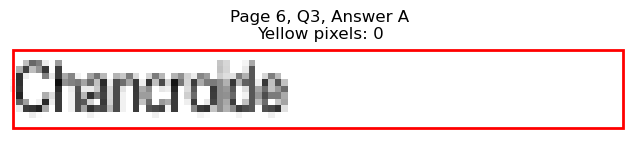

Page 6, Q3 - B: Detected box: x0=71.3, y0=241.6, x1=156.3, y1=253.7
Page 6, Q3, B: Yellow pixels: 651
Page 6, Q3, B: Total non-white pixels: 1079
Page 6, Q3, B: Yellow percentage: 60.3%


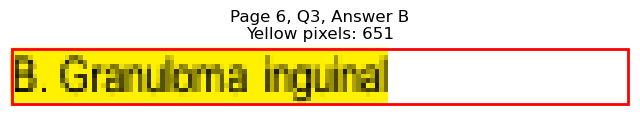

Page 6, Q3 - C: Detected box: x0=71.3, y0=253.6, x1=103.0, y1=265.7
Page 6, Q3, C: Yellow pixels: 82
Page 6, Q3, C: Total non-white pixels: 225
Page 6, Q3, C: Yellow percentage: 36.4%


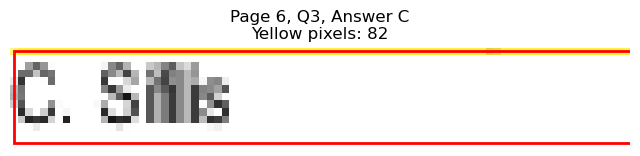

Page 6, Q3 - D: Detected box: x0=322.9, y0=229.6, x1=389.0, y1=241.7
Page 6, Q3, D: Yellow pixels: 0
Page 6, Q3, D: Total non-white pixels: 342
Page 6, Q3, D: Yellow percentage: 0.0%


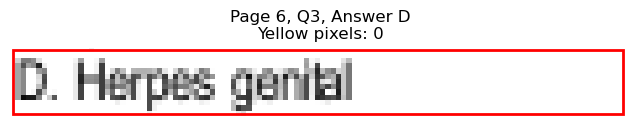

Page 6, Q3 - E: Detected box: x0=322.9, y0=241.6, x1=391.3, y1=253.7
Page 6, Q3, E: Yellow pixels: 0
Page 6, Q3, E: Total non-white pixels: 495
Page 6, Q3, E: Yellow percentage: 0.0%


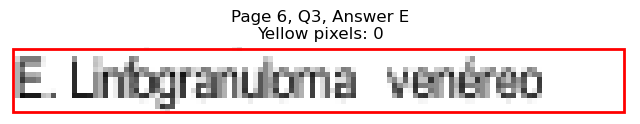


Page 6, Q3 - Selected Answer: B (based on yellow pixel count)




Page 6, Q4 - A: Detected box: x0=82.6, y0=289.7, x1=124.7, y1=301.8
Page 6, Q4, A: Yellow pixels: 0
Page 6, Q4, A: Total non-white pixels: 199
Page 6, Q4, A: Yellow percentage: 0.0%


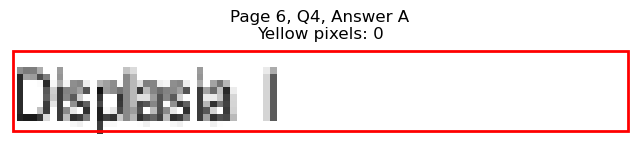

Page 6, Q4 - B: Detected box: x0=71.3, y0=302.5, x1=136.7, y1=314.5
Page 6, Q4, B: Yellow pixels: 0
Page 6, Q4, B: Total non-white pixels: 331
Page 6, Q4, B: Yellow percentage: 0.0%


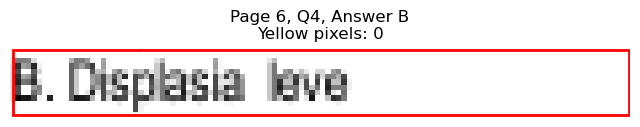

Page 6, Q4 - C: Detected box: x0=71.3, y0=314.5, x1=167.6, y1=326.5
Page 6, Q4, C: Yellow pixels: 847
Page 6, Q4, C: Total non-white pixels: 1235
Page 6, Q4, C: Yellow percentage: 68.6%


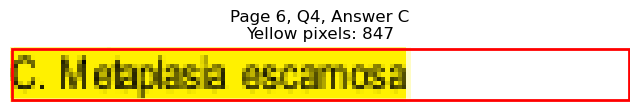

Page 6, Q4 - D: Detected box: x0=322.9, y0=289.7, x1=360.5, y1=301.8
Page 6, Q4, D: Yellow pixels: 0
Page 6, Q4, D: Total non-white pixels: 164
Page 6, Q4, D: Yellow percentage: 0.0%


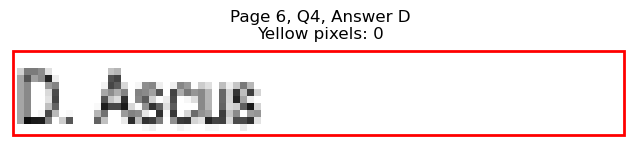

Page 6, Q4 - E: Detected box: x0=322.9, y0=302.5, x1=355.3, y1=314.5
Page 6, Q4, E: Yellow pixels: 0
Page 6, Q4, E: Total non-white pixels: 120
Page 6, Q4, E: Yellow percentage: 0.0%


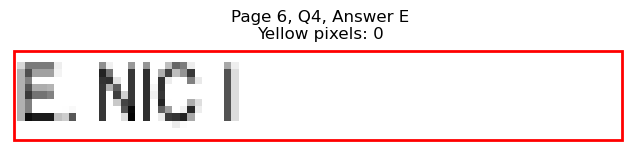


Page 6, Q4 - Selected Answer: C (based on yellow pixel count)




Page 6, Q5 - A: Detected box: x0=82.6, y0=350.5, x1=208.9, y1=362.5
Page 6, Q5, A: Yellow pixels: 1132
Page 6, Q5, A: Total non-white pixels: 1625
Page 6, Q5, A: Yellow percentage: 69.7%


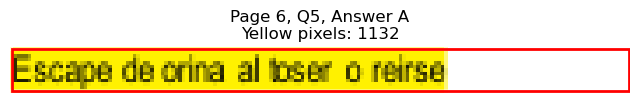

Page 6, Q5 - B: Detected box: x0=71.3, y0=362.5, x1=192.2, y1=374.6
Page 6, Q5, B: Yellow pixels: 123
Page 6, Q5, B: Total non-white pixels: 722
Page 6, Q5, B: Yellow percentage: 17.0%


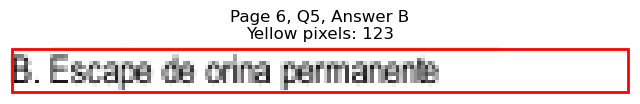

Page 6, Q5 - C: Detected box: x0=71.3, y0=374.5, x1=149.5, y1=386.6
Page 6, Q5, C: Yellow pixels: 0
Page 6, Q5, C: Total non-white pixels: 356
Page 6, Q5, C: Yellow percentage: 0.0%


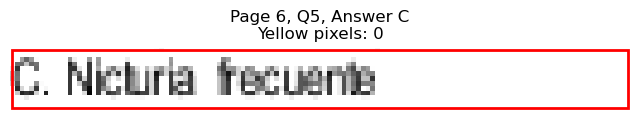

Page 6, Q5 - D: Detected box: x0=322.9, y0=350.5, x1=378.5, y1=362.5
Page 6, Q5, D: Yellow pixels: 0
Page 6, Q5, D: Total non-white pixels: 288
Page 6, Q5, D: Yellow percentage: 0.0%


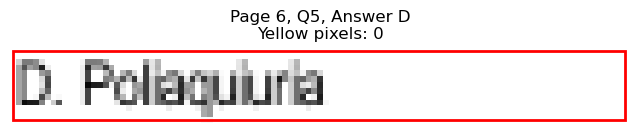

Page 6, Q5 - E: Detected box: x0=322.9, y0=362.5, x1=523.3, y1=374.6
Page 6, Q5, E: Yellow pixels: 0
Page 6, Q5, E: Total non-white pixels: 968
Page 6, Q5, E: Yellow percentage: 0.0%


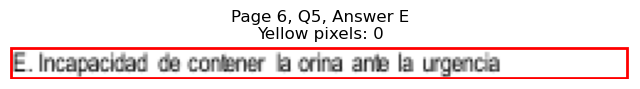


Page 6, Q5 - Selected Answer: A (based on yellow pixel count)




Page 6, Q6 - A: Detected box: x0=82.6, y0=422.5, x1=175.9, y1=434.6
Page 6, Q6, A: Yellow pixels: 729
Page 6, Q6, A: Total non-white pixels: 1198
Page 6, Q6, A: Yellow percentage: 60.9%


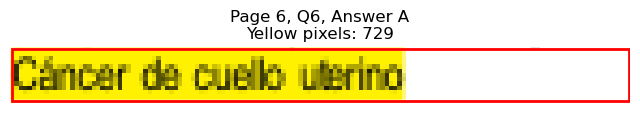

Page 6, Q6 - B: Detected box: x0=71.3, y0=434.6, x1=166.7, y1=446.6
Page 6, Q6, B: Yellow pixels: 90
Page 6, Q6, B: Total non-white pixels: 551
Page 6, Q6, B: Yellow percentage: 16.3%


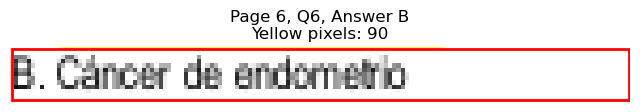

Page 6, Q6 - C: Detected box: x0=71.3, y0=446.6, x1=154.0, y1=458.6
Page 6, Q6, C: Yellow pixels: 0
Page 6, Q6, C: Total non-white pixels: 403
Page 6, Q6, C: Yellow percentage: 0.0%


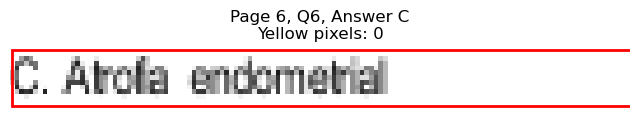

Page 6, Q6 - D: Detected box: x0=322.9, y0=422.5, x1=406.3, y1=434.6
Page 6, Q6, D: Yellow pixels: 0
Page 6, Q6, D: Total non-white pixels: 412
Page 6, Q6, D: Yellow percentage: 0.0%


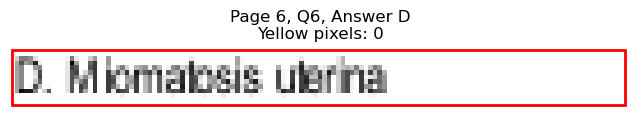

Page 6, Q6 - E: Detected box: x0=322.9, y0=434.6, x1=425.0, y1=446.6
Page 6, Q6, E: Yellow pixels: 0
Page 6, Q6, E: Total non-white pixels: 522
Page 6, Q6, E: Yellow percentage: 0.0%


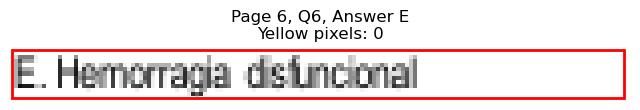


Page 6, Q6 - Selected Answer: A (based on yellow pixel count)




Page 6, Q7 - A: Detected box: x0=82.6, y0=483.4, x1=160.0, y1=495.4
Page 6, Q7, A: Yellow pixels: 0
Page 6, Q7, A: Total non-white pixels: 405
Page 6, Q7, A: Yellow percentage: 0.0%


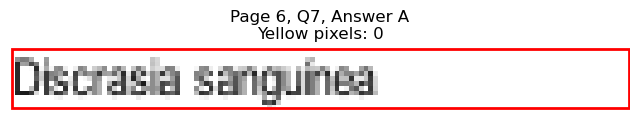

Page 6, Q7 - B: Detected box: x0=71.3, y0=495.4, x1=136.7, y1=507.4
Page 6, Q7, B: Yellow pixels: 0
Page 6, Q7, B: Total non-white pixels: 321
Page 6, Q7, B: Yellow percentage: 0.0%


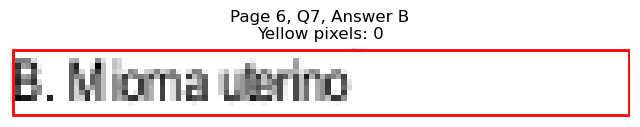

Page 6, Q7 - C: Detected box: x0=71.3, y0=507.4, x1=146.5, y1=519.4
Page 6, Q7, C: Yellow pixels: 0
Page 6, Q7, C: Total non-white pixels: 316
Page 6, Q7, C: Yellow percentage: 0.0%


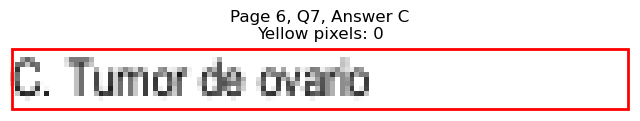

Page 6, Q7 - D: Detected box: x0=322.9, y0=483.4, x1=381.6, y1=495.4
Page 6, Q7, D: Yellow pixels: 503
Page 6, Q7, D: Total non-white pixels: 754
Page 6, Q7, D: Yellow percentage: 66.7%


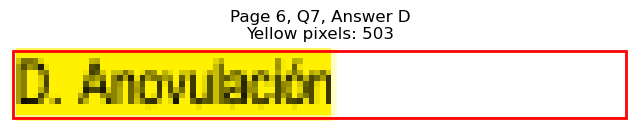

Page 6, Q7 - E: Detected box: x0=322.9, y0=495.4, x1=413.8, y1=507.4
Page 6, Q7, E: Yellow pixels: 56
Page 6, Q7, E: Total non-white pixels: 513
Page 6, Q7, E: Yellow percentage: 10.9%


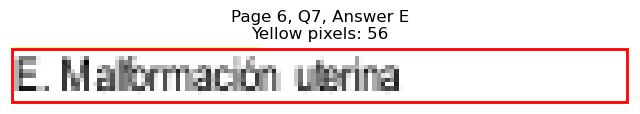


Page 6, Q7 - Selected Answer: D (based on yellow pixel count)




Page 6, Q8 - A: Detected box: x0=82.6, y0=543.4, x1=239.5, y1=555.5
Page 6, Q8, A: Yellow pixels: 0
Page 6, Q8, A: Total non-white pixels: 742
Page 6, Q8, A: Yellow percentage: 0.0%


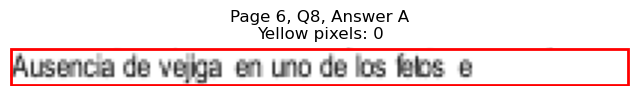

Page 6, Q8 - B: Detected box: x0=71.3, y0=567.5, x1=261.5, y1=579.5
Page 6, Q8, B: Yellow pixels: 0
Page 6, Q8, B: Total non-white pixels: 936
Page 6, Q8, B: Yellow percentage: 0.0%


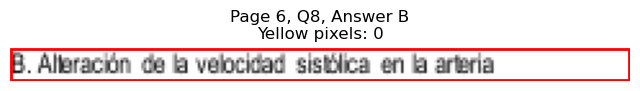

Page 6, Q8 - C: Detected box: x0=71.3, y0=591.5, x1=184.7, y1=603.5
Page 6, Q8, C: Yellow pixels: 0
Page 6, Q8, C: Total non-white pixels: 504
Page 6, Q8, C: Yellow percentage: 0.0%


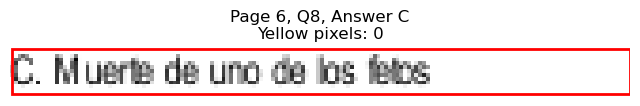

Page 6, Q8 - D: Detected box: x0=322.9, y0=543.4, x1=460.3, y1=555.5
Page 6, Q8, D: Yellow pixels: 0
Page 6, Q8, D: Total non-white pixels: 632
Page 6, Q8, D: Yellow percentage: 0.0%


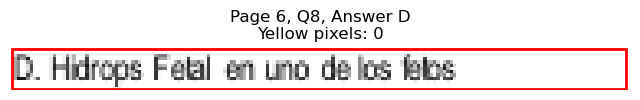

Page 6, Q8 - E: Detected box: x0=322.9, y0=555.4, x1=431.8, y1=567.5
Page 6, Q8, E: Yellow pixels: 1428
Page 6, Q8, E: Total non-white pixels: 2054
Page 6, Q8, E: Yellow percentage: 69.5%


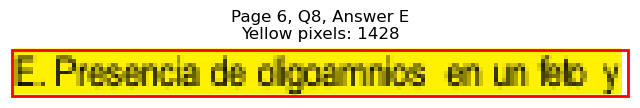


Page 6, Q8 - Selected Answer: E (based on yellow pixel count)




Page 6, Q9 - A: Detected box: x0=82.6, y0=627.5, x1=130.8, y1=639.6
Page 6, Q9, A: Yellow pixels: 0
Page 6, Q9, A: Total non-white pixels: 237
Page 6, Q9, A: Yellow percentage: 0.0%


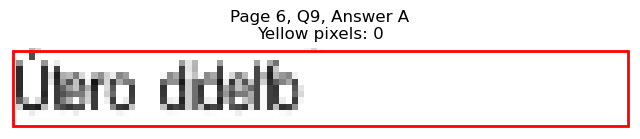

Page 6, Q9 - B: Detected box: x0=71.3, y0=639.5, x1=148.0, y1=651.6
Page 6, Q9, B: Yellow pixels: 0
Page 6, Q9, B: Total non-white pixels: 392
Page 6, Q9, B: Yellow percentage: 0.0%


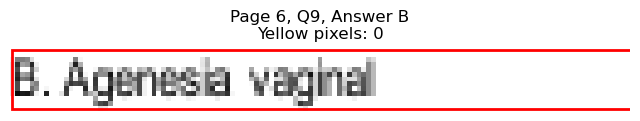

Page 6, Q9 - C: Detected box: x0=71.3, y0=651.5, x1=187.9, y1=663.6
Page 6, Q9, C: Yellow pixels: 1054
Page 6, Q9, C: Total non-white pixels: 1495
Page 6, Q9, C: Yellow percentage: 70.5%


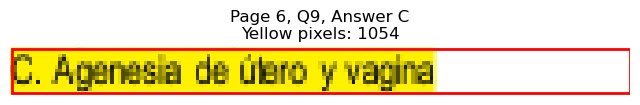

Page 6, Q9 - D: Detected box: x0=322.9, y0=627.5, x1=395.1, y1=639.6
Page 6, Q9, D: Yellow pixels: 0
Page 6, Q9, D: Total non-white pixels: 365
Page 6, Q9, D: Yellow percentage: 0.0%


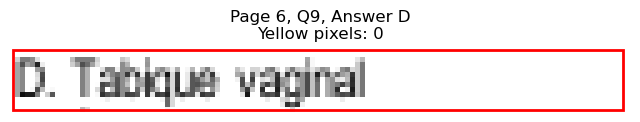

Page 6, Q9 - E: Detected box: x0=322.9, y0=639.5, x1=386.0, y1=651.6
Page 6, Q9, E: Yellow pixels: 0
Page 6, Q9, E: Total non-white pixels: 285
Page 6, Q9, E: Yellow percentage: 0.0%


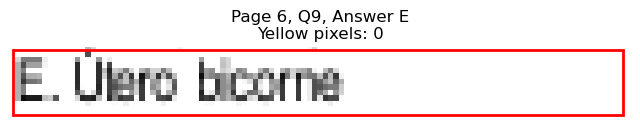


Page 6, Q9 - Selected Answer: C (based on yellow pixel count)




Page 6, Q10 - A: Detected box: x0=82.6, y0=700.3, x1=166.0, y1=712.3
Page 6, Q10, A: Yellow pixels: 0
Page 6, Q10, A: Total non-white pixels: 408
Page 6, Q10, A: Yellow percentage: 0.0%


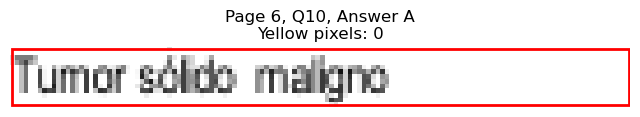

Page 6, Q10 - B: Detected box: x0=71.3, y0=712.3, x1=138.2, y1=724.4
Page 6, Q10, B: Yellow pixels: 0
Page 6, Q10, B: Total non-white pixels: 475
Page 6, Q10, B: Yellow percentage: 0.0%


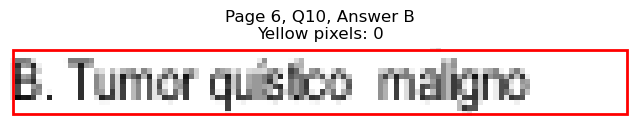

Page 6, Q10 - C: Detected box: x0=71.3, y0=724.3, x1=148.0, y1=736.4
Page 6, Q10, C: Yellow pixels: 0
Page 6, Q10, C: Total non-white pixels: 344
Page 6, Q10, C: Yellow percentage: 0.0%


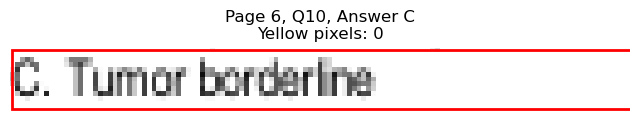

Page 6, Q10 - D: Detected box: x0=322.9, y0=700.3, x1=390.6, y1=712.3
Page 6, Q10, D: Yellow pixels: 507
Page 6, Q10, D: Total non-white pixels: 873
Page 6, Q10, D: Yellow percentage: 58.1%


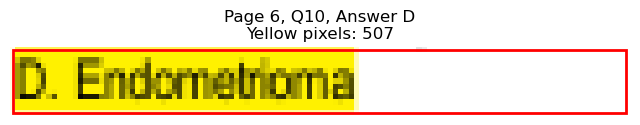

Page 6, Q10 - E: Detected box: x0=322.9, y0=712.3, x1=397.3, y1=724.4
Page 6, Q10, E: Yellow pixels: 0
Page 6, Q10, E: Total non-white pixels: 430
Page 6, Q10, E: Yellow percentage: 0.0%


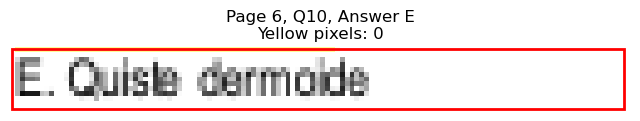


Page 6, Q10 - Selected Answer: D (based on yellow pixel count)





Page 7: Found 10 questions
Page 7, Q1 - A: Detected box: x0=82.6, y0=121.5, x1=175.8, y1=133.6
Page 7, Q1, A: Yellow pixels: 0
Page 7, Q1, A: Total non-white pixels: 661
Page 7, Q1, A: Yellow percentage: 0.0%


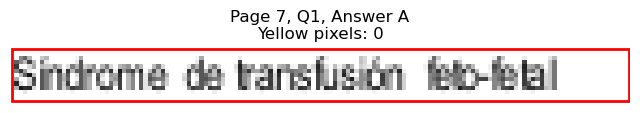

Page 7, Q1 - B: Detected box: x0=71.3, y0=133.5, x1=179.5, y1=145.6
Page 7, Q1, B: Yellow pixels: 0
Page 7, Q1, B: Total non-white pixels: 522
Page 7, Q1, B: Yellow percentage: 0.0%


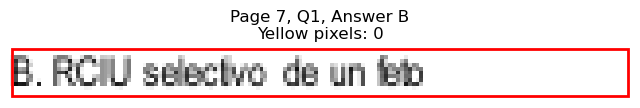

Page 7, Q1 - C: Detected box: x0=71.3, y0=145.6, x1=135.2, y1=157.6
Page 7, Q1, C: Yellow pixels: 0
Page 7, Q1, C: Total non-white pixels: 302
Page 7, Q1, C: Yellow percentage: 0.0%


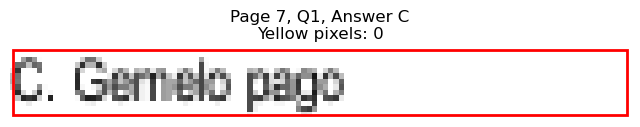

Page 7, Q1 - D: Detected box: x0=322.9, y0=121.5, x1=402.6, y1=133.6
Page 7, Q1, D: Yellow pixels: 697
Page 7, Q1, D: Total non-white pixels: 1027
Page 7, Q1, D: Yellow percentage: 67.9%


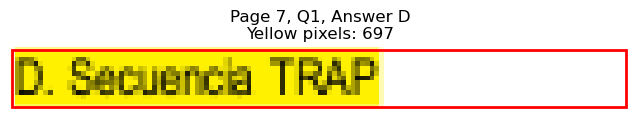

Page 7, Q1 - E: Detected box: x0=322.9, y0=133.5, x1=398.1, y1=145.6
Page 7, Q1, E: Yellow pixels: 77
Page 7, Q1, E: Total non-white pixels: 670
Page 7, Q1, E: Yellow percentage: 11.5%


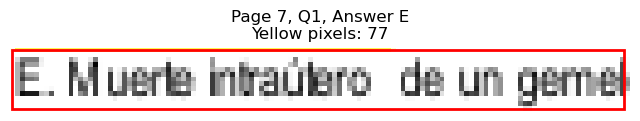


Page 7, Q1 - Selected Answer: D (based on yellow pixel count)




Page 7, Q2 - A: Detected box: x0=82.6, y0=193.6, x1=198.2, y1=205.6
Page 7, Q2, A: Yellow pixels: 0
Page 7, Q2, A: Total non-white pixels: 711
Page 7, Q2, A: Yellow percentage: 0.0%


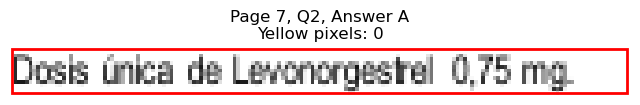

Page 7, Q2 - B: Detected box: x0=71.3, y0=205.6, x1=197.5, y1=217.7
Page 7, Q2, B: Yellow pixels: 1276
Page 7, Q2, B: Total non-white pixels: 2030
Page 7, Q2, B: Yellow percentage: 62.9%


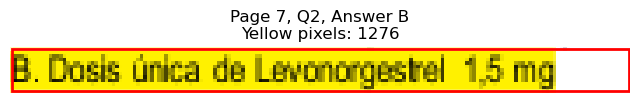

Page 7, Q2 - C: Detected box: x0=71.3, y0=217.6, x1=173.5, y1=229.7
Page 7, Q2, C: Yellow pixels: 153
Page 7, Q2, C: Total non-white pixels: 876
Page 7, Q2, C: Yellow percentage: 17.5%


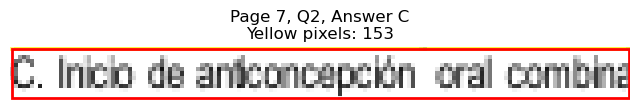

Page 7, Q2 - D: Detected box: x0=322.9, y0=193.6, x1=463.2, y1=205.6
Page 7, Q2, D: Yellow pixels: 0
Page 7, Q2, D: Total non-white pixels: 648
Page 7, Q2, D: Yellow percentage: 0.0%


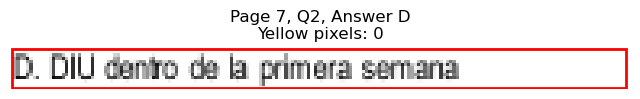

Page 7, Q2 - E: Detected box: x0=389.6, y0=205.6, x1=462.5, y1=217.7
Page 7, Q2, E: Yellow pixels: 0
Page 7, Q2, E: Total non-white pixels: 337
Page 7, Q2, E: Yellow percentage: 0.0%


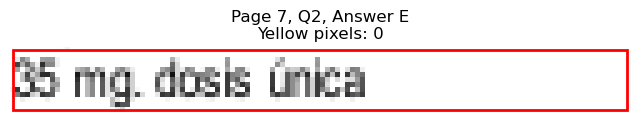


Page 7, Q2 - Selected Answer: B (based on yellow pixel count)




Page 7, Q3 - A: Detected box: x0=82.6, y0=277.7, x1=152.5, y1=289.7
Page 7, Q3, A: Yellow pixels: 0
Page 7, Q3, A: Total non-white pixels: 329
Page 7, Q3, A: Yellow percentage: 0.0%


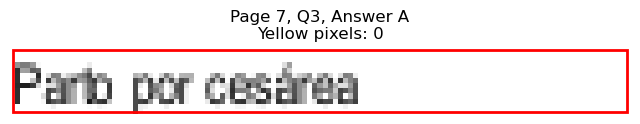

Page 7, Q3 - B: Detected box: x0=71.3, y0=289.7, x1=213.9, y1=301.8
Page 7, Q3, B: Yellow pixels: 0
Page 7, Q3, B: Total non-white pixels: 652
Page 7, Q3, B: Yellow percentage: 0.0%


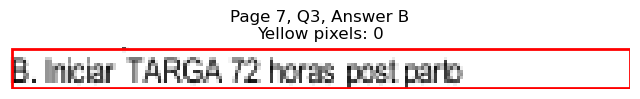

Page 7, Q3 - C: Detected box: x0=71.3, y0=302.5, x1=146.5, y1=314.5
Page 7, Q3, C: Yellow pixels: 0
Page 7, Q3, C: Total non-white pixels: 472
Page 7, Q3, C: Yellow percentage: 0.0%


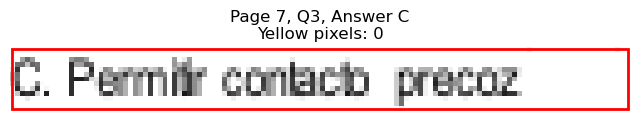

Page 7, Q3 - D: Detected box: x0=322.9, y0=277.7, x1=471.7, y1=289.7
Page 7, Q3, D: Yellow pixels: 1195
Page 7, Q3, D: Total non-white pixels: 1924
Page 7, Q3, D: Yellow percentage: 62.1%


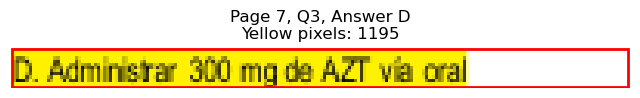

Page 7, Q3 - E: Detected box: x0=322.9, y0=289.7, x1=464.8, y1=301.8
Page 7, Q3, E: Yellow pixels: 142
Page 7, Q3, E: Total non-white pixels: 838
Page 7, Q3, E: Yellow percentage: 16.9%


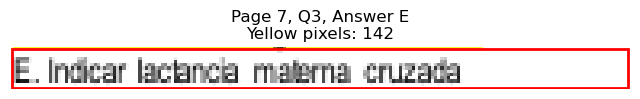


Page 7, Q3 - Selected Answer: D (based on yellow pixel count)




Page 7, Q4 - A: Detected box: x0=71.3, y0=350.5, x1=79.7, y1=362.5
Page 7, Q4, A: Yellow pixels: 0
Page 7, Q4, A: Total non-white pixels: 62
Page 7, Q4, A: Yellow percentage: 0.0%


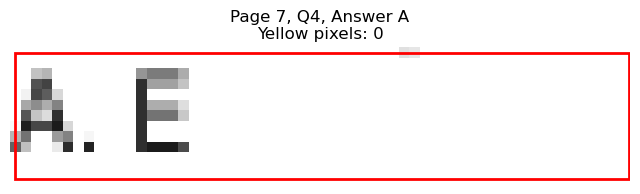

Page 7, Q4 - B: Detected box: x0=71.3, y0=362.5, x1=90.2, y1=374.6
Page 7, Q4, B: Yellow pixels: 0
Page 7, Q4, B: Total non-white pixels: 81
Page 7, Q4, B: Yellow percentage: 0.0%


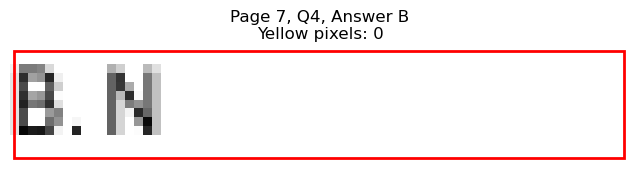

Page 7, Q4 - C: Detected box: x0=71.3, y0=374.5, x1=87.2, y1=386.6
Page 7, Q4, C: Yellow pixels: 0
Page 7, Q4, C: Total non-white pixels: 46
Page 7, Q4, C: Yellow percentage: 0.0%


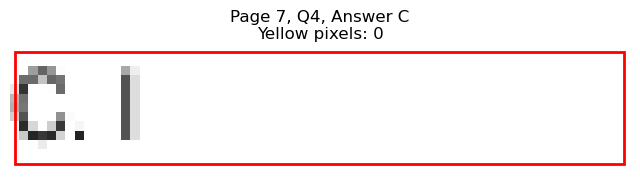

Page 7, Q4 - D: Detected box: x0=322.9, y0=350.5, x1=344.8, y1=362.5
Page 7, Q4, D: Yellow pixels: 189
Page 7, Q4, D: Total non-white pixels: 273
Page 7, Q4, D: Yellow percentage: 69.2%


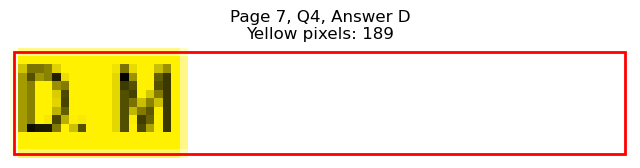

Page 7, Q4 - E: Detected box: x0=322.9, y0=362.5, x1=342.5, y1=374.6
Page 7, Q4, E: Yellow pixels: 19
Page 7, Q4, E: Total non-white pixels: 93
Page 7, Q4, E: Yellow percentage: 20.4%


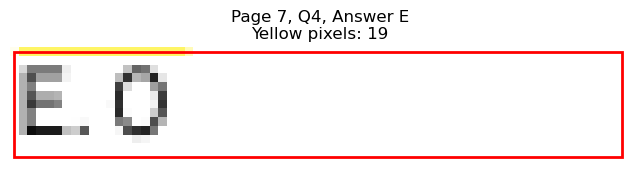


Page 7, Q4 - Selected Answer: D (based on yellow pixel count)




Page 7, Q5 - A: Detected box: x0=82.6, y0=410.5, x1=193.0, y1=422.6
Page 7, Q5, A: Yellow pixels: 0
Page 7, Q5, A: Total non-white pixels: 572
Page 7, Q5, A: Yellow percentage: 0.0%


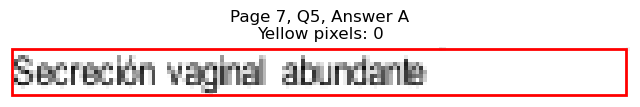

Page 7, Q5 - B: Detected box: x0=71.3, y0=422.5, x1=182.5, y1=434.6
Page 7, Q5, B: Yellow pixels: 0
Page 7, Q5, B: Total non-white pixels: 538
Page 7, Q5, B: Yellow percentage: 0.0%


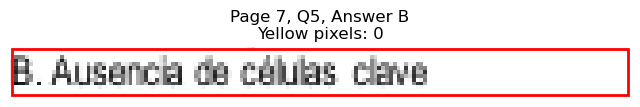

Page 7, Q5 - C: Detected box: x0=71.3, y0=434.6, x1=170.6, y1=446.6
Page 7, Q5, C: Yellow pixels: 786
Page 7, Q5, C: Total non-white pixels: 1274
Page 7, Q5, C: Yellow percentage: 61.7%


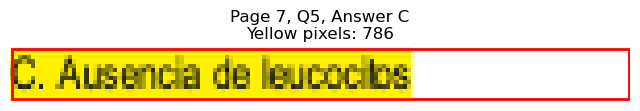

Page 7, Q5 - D: Detected box: x0=322.9, y0=410.5, x1=427.3, y1=422.6
Page 7, Q5, D: Yellow pixels: 0
Page 7, Q5, D: Total non-white pixels: 501
Page 7, Q5, D: Yellow percentage: 0.0%


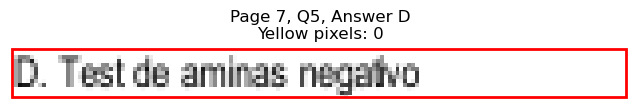

Page 7, Q5 - E: Detected box: x0=322.9, y0=422.5, x1=394.3, y1=434.6
Page 7, Q5, E: Yellow pixels: 0
Page 7, Q5, E: Total non-white pixels: 307
Page 7, Q5, E: Yellow percentage: 0.0%


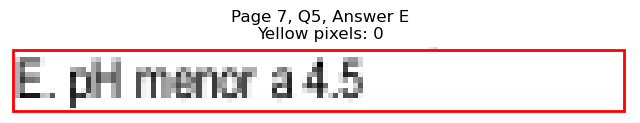


Page 7, Q5 - Selected Answer: C (based on yellow pixel count)




Page 7, Q6 - A: Detected box: x0=82.6, y0=483.4, x1=94.0, y1=495.4
Page 7, Q6, A: Yellow pixels: 0
Page 7, Q6, A: Total non-white pixels: 50
Page 7, Q6, A: Yellow percentage: 0.0%


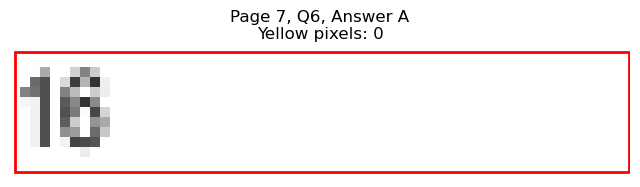

Page 7, Q6 - B: Detected box: x0=71.3, y0=495.4, x1=93.2, y1=507.4
Page 7, Q6, B: Yellow pixels: 0
Page 7, Q6, B: Total non-white pixels: 96
Page 7, Q6, B: Yellow percentage: 0.0%


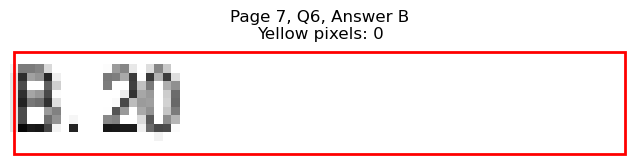

Page 7, Q6 - C: Detected box: x0=71.3, y0=507.4, x1=94.0, y1=519.4
Page 7, Q6, C: Yellow pixels: 0
Page 7, Q6, C: Total non-white pixels: 80
Page 7, Q6, C: Yellow percentage: 0.0%


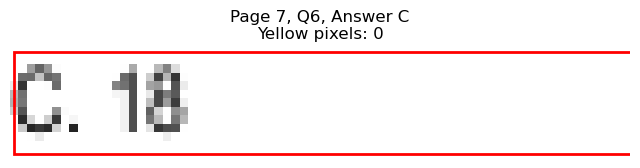

Page 7, Q6 - D: Detected box: x0=322.9, y0=483.4, x1=345.6, y1=495.4
Page 7, Q6, D: Yellow pixels: 188
Page 7, Q6, D: Total non-white pixels: 286
Page 7, Q6, D: Yellow percentage: 65.7%


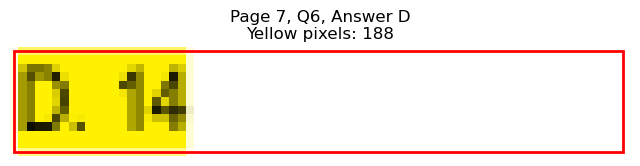

Page 7, Q6 - E: Detected box: x0=322.9, y0=495.4, x1=344.8, y1=507.4
Page 7, Q6, E: Yellow pixels: 20
Page 7, Q6, E: Total non-white pixels: 106
Page 7, Q6, E: Yellow percentage: 18.9%


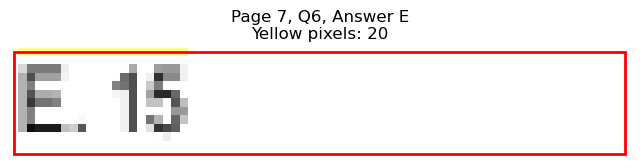


Page 7, Q6 - Selected Answer: D (based on yellow pixel count)




Page 7, Q7 - A: Detected box: x0=82.6, y0=543.4, x1=121.0, y1=555.5
Page 7, Q7, A: Yellow pixels: 290
Page 7, Q7, A: Total non-white pixels: 482
Page 7, Q7, A: Yellow percentage: 60.2%


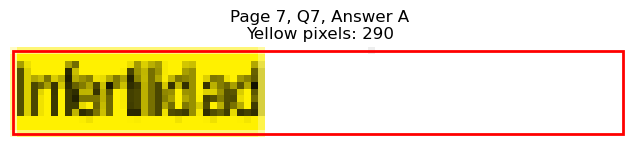

Page 7, Q7 - B: Detected box: x0=71.3, y0=555.4, x1=136.7, y1=567.5
Page 7, Q7, B: Yellow pixels: 35
Page 7, Q7, B: Total non-white pixels: 364
Page 7, Q7, B: Yellow percentage: 9.6%


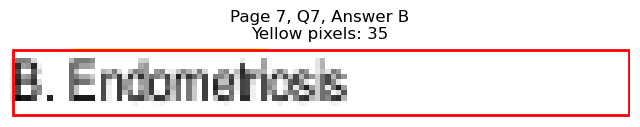

Page 7, Q7 - C: Detected box: x0=71.3, y0=567.5, x1=130.0, y1=579.5
Page 7, Q7, C: Yellow pixels: 0
Page 7, Q7, C: Total non-white pixels: 274
Page 7, Q7, C: Yellow percentage: 0.0%


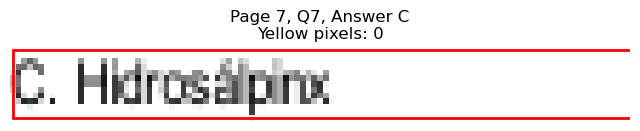

Page 7, Q7 - D: Detected box: x0=322.9, y0=543.4, x1=400.2, y1=555.5
Page 7, Q7, D: Yellow pixels: 0
Page 7, Q7, D: Total non-white pixels: 373
Page 7, Q7, D: Yellow percentage: 0.0%


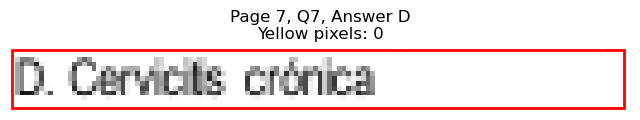

Page 7, Q7 - E: Detected box: x0=322.9, y0=555.4, x1=380.8, y1=567.5
Page 7, Q7, E: Yellow pixels: 0
Page 7, Q7, E: Total non-white pixels: 435
Page 7, Q7, E: Yellow percentage: 0.0%


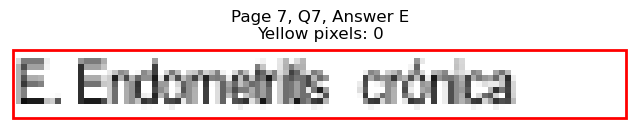


Page 7, Q7 - Selected Answer: A (based on yellow pixel count)




Page 7, Q8 - A: Detected box: x0=82.6, y0=615.5, x1=205.1, y1=627.5
Page 7, Q8, A: Yellow pixels: 1042
Page 7, Q8, A: Total non-white pixels: 1573
Page 7, Q8, A: Yellow percentage: 66.2%


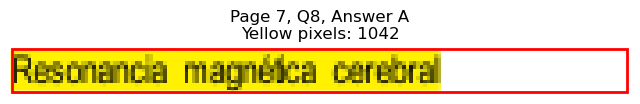

Page 7, Q8 - B: Detected box: x0=71.3, y0=627.5, x1=148.7, y1=639.6
Page 7, Q8, B: Yellow pixels: 116
Page 7, Q8, B: Total non-white pixels: 507
Page 7, Q8, B: Yellow percentage: 22.9%


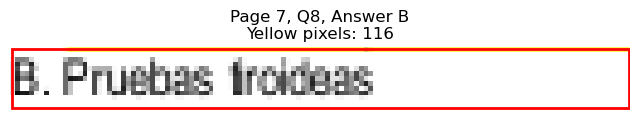

Page 7, Q8 - C: Detected box: x0=71.3, y0=639.5, x1=167.5, y1=651.6
Page 7, Q8, C: Yellow pixels: 0
Page 7, Q8, C: Total non-white pixels: 451
Page 7, Q8, C: Yellow percentage: 0.0%


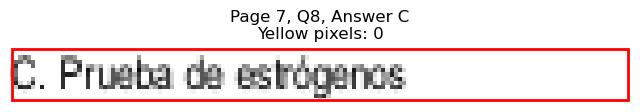

Page 7, Q8 - D: Detected box: x0=322.9, y0=615.5, x1=434.0, y1=627.5
Page 7, Q8, D: Yellow pixels: 0
Page 7, Q8, D: Total non-white pixels: 572
Page 7, Q8, D: Yellow percentage: 0.0%


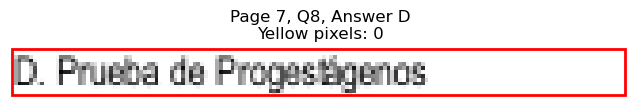

Page 7, Q8 - E: Detected box: x0=322.9, y0=627.5, x1=383.0, y1=639.6
Page 7, Q8, E: Yellow pixels: 0
Page 7, Q8, E: Total non-white pixels: 295
Page 7, Q8, E: Yellow percentage: 0.0%


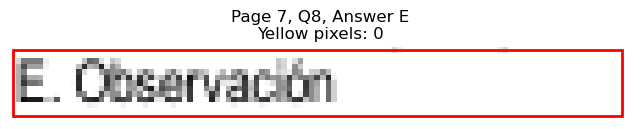


Page 7, Q8 - Selected Answer: A (based on yellow pixel count)




Page 7, Q9 - A: Detected box: x0=141.8, y0=676.3, x1=268.7, y1=688.3
Page 7, Q9, A: Yellow pixels: 0
Page 7, Q9, A: Total non-white pixels: 578
Page 7, Q9, A: Yellow percentage: 0.0%


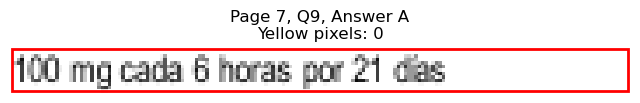

Page 7, Q9 - B: Detected box: x0=71.3, y0=688.3, x1=260.4, y1=700.3
Page 7, Q9, B: Yellow pixels: 0
Page 7, Q9, B: Total non-white pixels: 899
Page 7, Q9, B: Yellow percentage: 0.0%


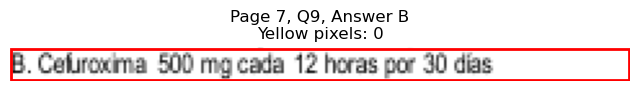

Page 7, Q9 - C: Detected box: x0=71.3, y0=700.3, x1=266.5, y1=712.3
Page 7, Q9, C: Yellow pixels: 0
Page 7, Q9, C: Total non-white pixels: 899
Page 7, Q9, C: Yellow percentage: 0.0%


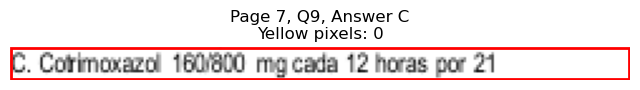

Page 7, Q9 - D: Detected box: x0=392.6, y0=676.3, x1=495.5, y1=688.3
Page 7, Q9, D: Yellow pixels: 936
Page 7, Q9, D: Total non-white pixels: 1534
Page 7, Q9, D: Yellow percentage: 61.0%


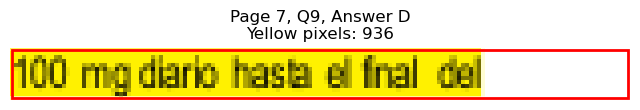

Page 7, Q9 - E: Detected box: x0=392.6, y0=700.3, x1=524.7, y1=712.3
Page 7, Q9, E: Yellow pixels: 0
Page 7, Q9, E: Total non-white pixels: 623
Page 7, Q9, E: Yellow percentage: 0.0%


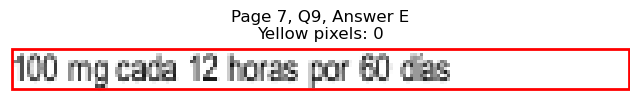


Page 7, Q9 - Selected Answer: D (based on yellow pixel count)




Page 7, Q10 - A: Detected box: x0=82.6, y0=748.4, x1=104.5, y1=760.4
Page 7, Q10, A: Yellow pixels: 0
Page 7, Q10, A: Total non-white pixels: 111
Page 7, Q10, A: Yellow percentage: 0.0%


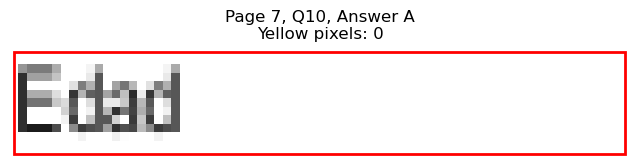

Page 7, Q10 - B: Detected box: x0=71.3, y0=760.4, x1=119.5, y1=772.4
Page 7, Q10, B: Yellow pixels: 0
Page 7, Q10, B: Total non-white pixels: 247
Page 7, Q10, B: Yellow percentage: 0.0%


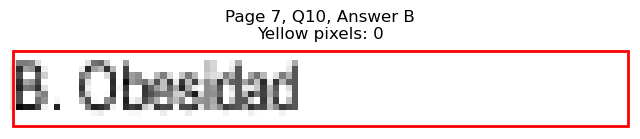

Page 7, Q10 - C: Detected box: x0=71.3, y0=772.4, x1=134.5, y1=784.4
Page 7, Q10, C: Yellow pixels: 0
Page 7, Q10, C: Total non-white pixels: 300
Page 7, Q10, C: Yellow percentage: 0.0%


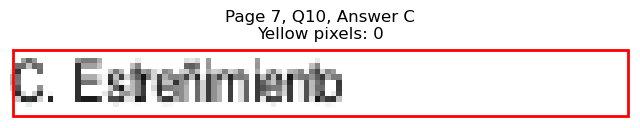

Page 7, Q10 - D: Detected box: x0=322.9, y0=748.4, x1=365.1, y1=760.4
Page 7, Q10, D: Yellow pixels: 354
Page 7, Q10, D: Total non-white pixels: 533
Page 7, Q10, D: Yellow percentage: 66.4%


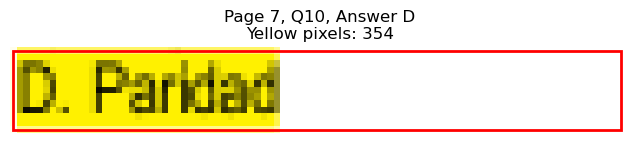

Page 7, Q10 - E: Detected box: x0=322.9, y0=760.4, x1=353.2, y1=772.4
Page 7, Q10, E: Yellow pixels: 39
Page 7, Q10, E: Total non-white pixels: 186
Page 7, Q10, E: Yellow percentage: 21.0%


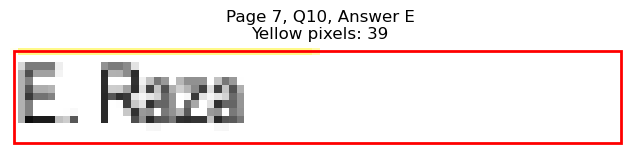


Page 7, Q10 - Selected Answer: D (based on yellow pixel count)





Page 8: Found 10 questions
Page 8, Q1 - A: Detected box: x0=82.6, y0=121.5, x1=125.6, y1=133.6
Page 8, Q1, A: Yellow pixels: 0
Page 8, Q1, A: Total non-white pixels: 231
Page 8, Q1, A: Yellow percentage: 0.0%


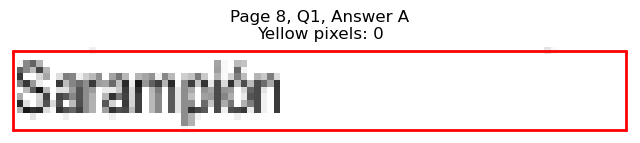

Page 8, Q1 - B: Detected box: x0=71.3, y0=133.5, x1=114.3, y1=145.6
Page 8, Q1, B: Yellow pixels: 317
Page 8, Q1, B: Total non-white pixels: 533
Page 8, Q1, B: Yellow percentage: 59.5%


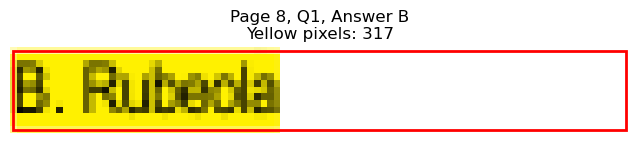

Page 8, Q1 - C: Detected box: x0=71.3, y0=145.6, x1=114.2, y1=157.6
Page 8, Q1, C: Yellow pixels: 41
Page 8, Q1, C: Total non-white pixels: 237
Page 8, Q1, C: Yellow percentage: 17.3%


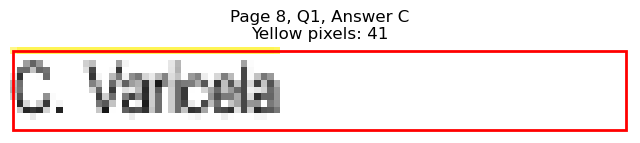

Page 8, Q1 - D: Detected box: x0=322.9, y0=121.5, x1=366.5, y1=133.6
Page 8, Q1, D: Yellow pixels: 0
Page 8, Q1, D: Total non-white pixels: 217
Page 8, Q1, D: Yellow percentage: 0.0%


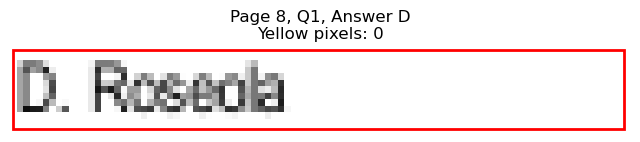

Page 8, Q1 - E: Detected box: x0=322.9, y0=133.5, x1=364.3, y1=145.6
Page 8, Q1, E: Yellow pixels: 0
Page 8, Q1, E: Total non-white pixels: 197
Page 8, Q1, E: Yellow percentage: 0.0%


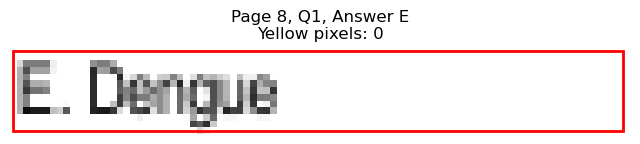


Page 8, Q1 - Selected Answer: B (based on yellow pixel count)




Page 8, Q2 - A: Detected box: x0=82.6, y0=181.6, x1=234.4, y1=193.6
Page 8, Q2, A: Yellow pixels: 0
Page 8, Q2, A: Total non-white pixels: 803
Page 8, Q2, A: Yellow percentage: 0.0%


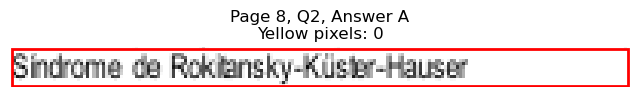

Page 8, Q2 - B: Detected box: x0=71.3, y0=193.6, x1=160.8, y1=205.6
Page 8, Q2, B: Yellow pixels: 712
Page 8, Q2, B: Total non-white pixels: 1146
Page 8, Q2, B: Yellow percentage: 62.1%


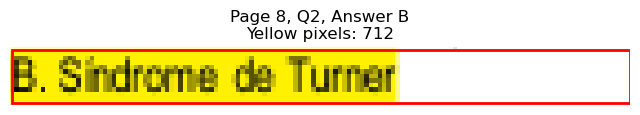

Page 8, Q2 - C: Detected box: x0=71.3, y0=205.6, x1=225.2, y1=217.7
Page 8, Q2, C: Yellow pixels: 87
Page 8, Q2, C: Total non-white pixels: 833
Page 8, Q2, C: Yellow percentage: 10.4%


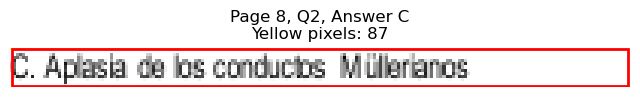

Page 8, Q2 - D: Detected box: x0=322.9, y0=181.6, x1=447.6, y1=193.6
Page 8, Q2, D: Yellow pixels: 0
Page 8, Q2, D: Total non-white pixels: 651
Page 8, Q2, D: Yellow percentage: 0.0%


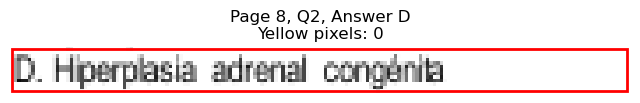

Page 8, Q2 - E: Detected box: x0=322.9, y0=193.6, x1=417.5, y1=205.6
Page 8, Q2, E: Yellow pixels: 0
Page 8, Q2, E: Total non-white pixels: 448
Page 8, Q2, E: Yellow percentage: 0.0%


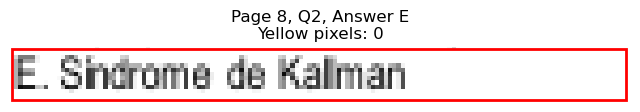


Page 8, Q2 - Selected Answer: B (based on yellow pixel count)




Page 8, Q3 - A: Detected box: x0=82.6, y0=253.6, x1=159.2, y1=265.7
Page 8, Q3, A: Yellow pixels: 0
Page 8, Q3, A: Total non-white pixels: 371
Page 8, Q3, A: Yellow percentage: 0.0%


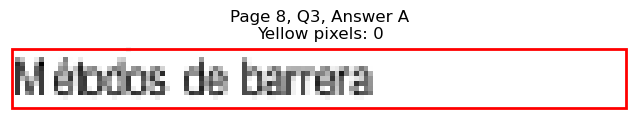

Page 8, Q3 - B: Detected box: x0=71.3, y0=265.7, x1=155.4, y1=277.7
Page 8, Q3, B: Yellow pixels: 0
Page 8, Q3, B: Total non-white pixels: 357
Page 8, Q3, B: Yellow percentage: 0.0%


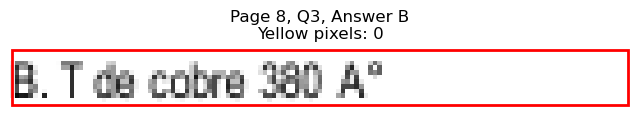

Page 8, Q3 - C: Detected box: x0=71.3, y0=277.7, x1=181.9, y1=289.7
Page 8, Q3, C: Yellow pixels: 864
Page 8, Q3, C: Total non-white pixels: 1417
Page 8, Q3, C: Yellow percentage: 61.0%


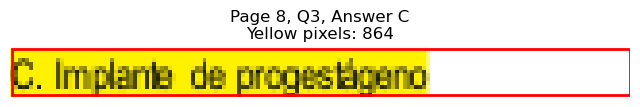

Page 8, Q3 - D: Detected box: x0=322.9, y0=253.6, x1=420.5, y1=265.7
Page 8, Q3, D: Yellow pixels: 0
Page 8, Q3, D: Total non-white pixels: 458
Page 8, Q3, D: Yellow percentage: 0.0%


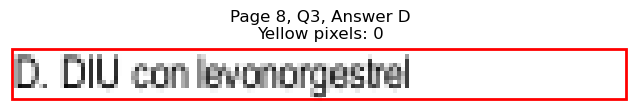

Page 8, Q3 - E: Detected box: x0=396.4, y0=265.7, x1=469.2, y1=277.7
Page 8, Q3, E: Yellow pixels: 0
Page 8, Q3, E: Total non-white pixels: 374
Page 8, Q3, E: Yellow percentage: 0.0%


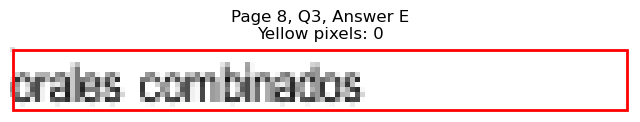


Page 8, Q3 - Selected Answer: C (based on yellow pixel count)




Page 8, Q4 - A: Detected box: x0=82.6, y0=314.5, x1=172.7, y1=326.5
Page 8, Q4, A: Yellow pixels: 0
Page 8, Q4, A: Total non-white pixels: 440
Page 8, Q4, A: Yellow percentage: 0.0%


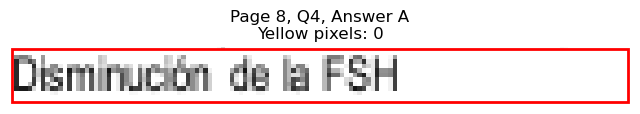

Page 8, Q4 - B: Detected box: x0=71.3, y0=326.5, x1=152.5, y1=338.5
Page 8, Q4, B: Yellow pixels: 0
Page 8, Q4, B: Total non-white pixels: 351
Page 8, Q4, B: Yellow percentage: 0.0%


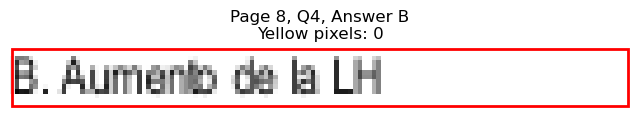

Page 8, Q4 - C: Detected box: x0=71.3, y0=338.5, x1=209.4, y1=350.5
Page 8, Q4, C: Yellow pixels: 0
Page 8, Q4, C: Total non-white pixels: 625
Page 8, Q4, C: Yellow percentage: 0.0%


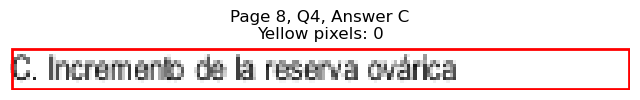

Page 8, Q4 - D: Detected box: x0=322.9, y0=314.5, x1=498.0, y1=326.5
Page 8, Q4, D: Yellow pixels: 1556
Page 8, Q4, D: Total non-white pixels: 2262
Page 8, Q4, D: Yellow percentage: 68.8%


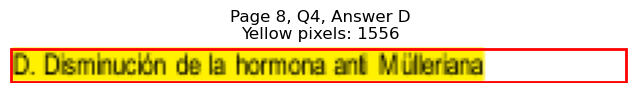

Page 8, Q4 - E: Detected box: x0=322.9, y0=326.5, x1=432.5, y1=338.5
Page 8, Q4, E: Yellow pixels: 160
Page 8, Q4, E: Total non-white pixels: 674
Page 8, Q4, E: Yellow percentage: 23.7%


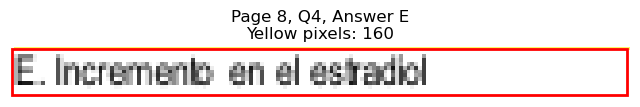


Page 8, Q4 - Selected Answer: D (based on yellow pixel count)




Page 8, Q5 - A: Detected box: x0=82.6, y0=374.5, x1=193.7, y1=386.6
Page 8, Q5, A: Yellow pixels: 0
Page 8, Q5, A: Total non-white pixels: 569
Page 8, Q5, A: Yellow percentage: 0.0%


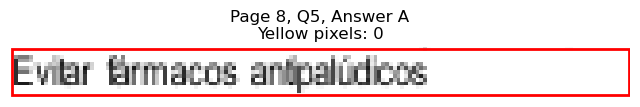

Page 8, Q5 - B: Detected box: x0=71.3, y0=386.5, x1=187.7, y1=398.6
Page 8, Q5, B: Yellow pixels: 0
Page 8, Q5, B: Total non-white pixels: 560
Page 8, Q5, B: Yellow percentage: 0.0%


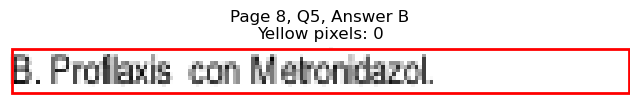

Page 8, Q5 - C: Detected box: x0=71.3, y0=398.5, x1=177.4, y1=410.6
Page 8, Q5, C: Yellow pixels: 949
Page 8, Q5, C: Total non-white pixels: 1352
Page 8, Q5, C: Yellow percentage: 70.2%


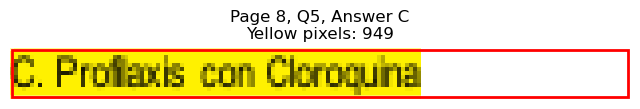

Page 8, Q5 - D: Detected box: x0=322.9, y0=374.5, x1=431.0, y1=386.6
Page 8, Q5, D: Yellow pixels: 0
Page 8, Q5, D: Total non-white pixels: 521
Page 8, Q5, D: Yellow percentage: 0.0%


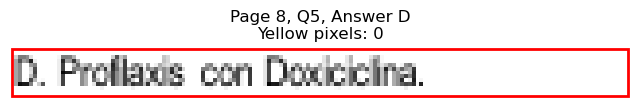

Page 8, Q5 - E: Detected box: x0=322.9, y0=386.5, x1=431.9, y1=398.6
Page 8, Q5, E: Yellow pixels: 0
Page 8, Q5, E: Total non-white pixels: 519
Page 8, Q5, E: Yellow percentage: 0.0%


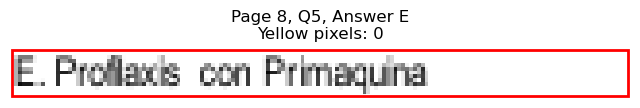


Page 8, Q5 - Selected Answer: C (based on yellow pixel count)




Page 8, Q6 - A: Detected box: x0=82.6, y0=446.6, x1=120.3, y1=458.6
Page 8, Q6, A: Yellow pixels: 525
Page 8, Q6, A: Total non-white pixels: 911
Page 8, Q6, A: Yellow percentage: 57.6%


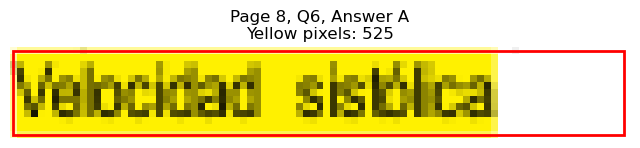

Page 8, Q6 - B: Detected box: x0=71.3, y0=458.6, x1=119.5, y1=470.6
Page 8, Q6, B: Yellow pixels: 69
Page 8, Q6, B: Total non-white pixels: 524
Page 8, Q6, B: Yellow percentage: 13.2%


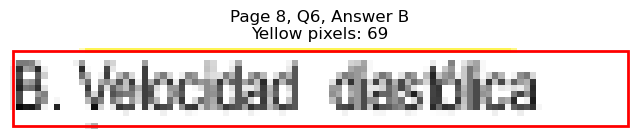

Page 8, Q6 - C: Detected box: x0=71.3, y0=470.6, x1=161.5, y1=482.6
Page 8, Q6, C: Yellow pixels: 0
Page 8, Q6, C: Total non-white pixels: 462
Page 8, Q6, C: Yellow percentage: 0.0%


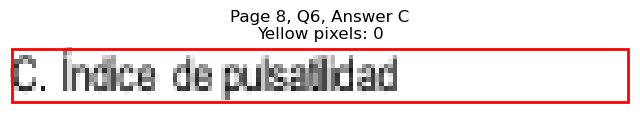

Page 8, Q6 - D: Detected box: x0=322.9, y0=446.6, x1=412.3, y1=458.6
Page 8, Q6, D: Yellow pixels: 0
Page 8, Q6, D: Total non-white pixels: 434
Page 8, Q6, D: Yellow percentage: 0.0%


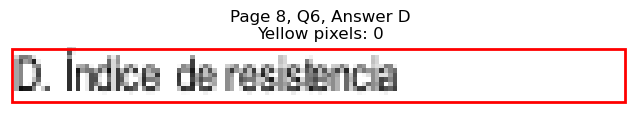

Page 8, Q6 - E: Detected box: x0=322.9, y0=458.6, x1=389.8, y1=470.6
Page 8, Q6, E: Yellow pixels: 0
Page 8, Q6, E: Total non-white pixels: 341
Page 8, Q6, E: Yellow percentage: 0.0%


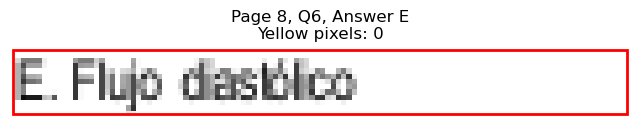


Page 8, Q6 - Selected Answer: A (based on yellow pixel count)




Page 8, Q7 - A: Detected box: x0=82.6, y0=507.4, x1=109.7, y1=519.4
Page 8, Q7, A: Yellow pixels: 0
Page 8, Q7, A: Total non-white pixels: 120
Page 8, Q7, A: Yellow percentage: 0.0%


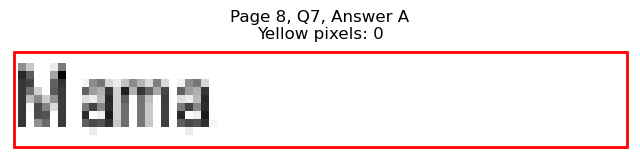

Page 8, Q7 - B: Detected box: x0=71.3, y0=519.4, x1=109.0, y1=531.4
Page 8, Q7, B: Yellow pixels: 336
Page 8, Q7, B: Total non-white pixels: 468
Page 8, Q7, B: Yellow percentage: 71.8%


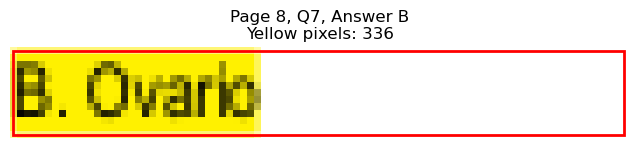

Page 8, Q7 - C: Detected box: x0=71.3, y0=531.4, x1=109.0, y1=543.5
Page 8, Q7, C: Yellow pixels: 34
Page 8, Q7, C: Total non-white pixels: 188
Page 8, Q7, C: Yellow percentage: 18.1%


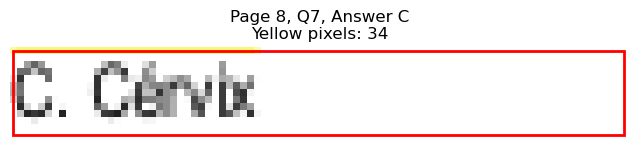

Page 8, Q7 - D: Detected box: x0=322.9, y0=507.4, x1=406.3, y1=519.4
Page 8, Q7, D: Yellow pixels: 0
Page 8, Q7, D: Total non-white pixels: 393
Page 8, Q7, D: Yellow percentage: 0.0%


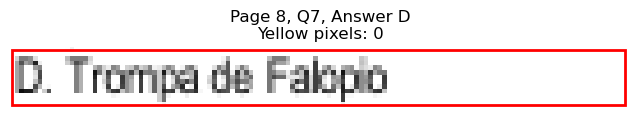

Page 8, Q7 - E: Detected box: x0=322.9, y0=519.4, x1=356.0, y1=531.4
Page 8, Q7, E: Yellow pixels: 0
Page 8, Q7, E: Total non-white pixels: 148
Page 8, Q7, E: Yellow percentage: 0.0%


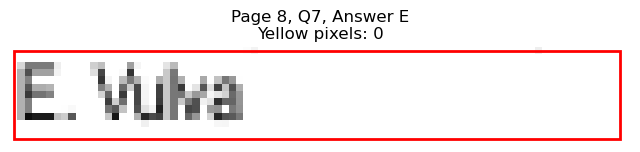


Page 8, Q7 - Selected Answer: B (based on yellow pixel count)




Page 8, Q8 - A: Detected box: x0=82.6, y0=579.4, x1=127.8, y1=591.5
Page 8, Q8, A: Yellow pixels: 0
Page 8, Q8, A: Total non-white pixels: 221
Page 8, Q8, A: Yellow percentage: 0.0%


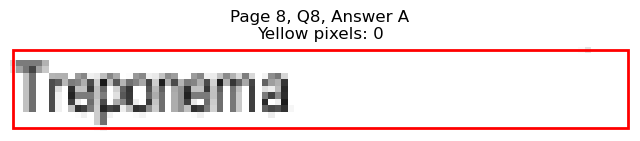

Page 8, Q8 - B: Detected box: x0=71.3, y0=591.5, x1=138.2, y1=603.5
Page 8, Q8, B: Yellow pixels: 0
Page 8, Q8, B: Total non-white pixels: 330
Page 8, Q8, B: Yellow percentage: 0.0%


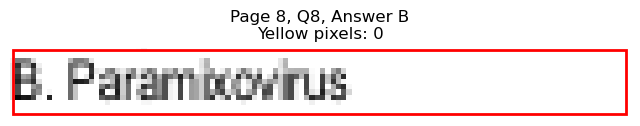

Page 8, Q8 - C: Detected box: x0=71.3, y0=603.5, x1=143.5, y1=615.5
Page 8, Q8, C: Yellow pixels: 0
Page 8, Q8, C: Total non-white pixels: 350
Page 8, Q8, C: Yellow percentage: 0.0%


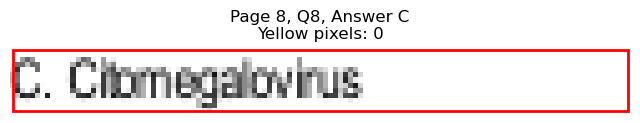

Page 8, Q8 - D: Detected box: x0=322.9, y0=579.4, x1=377.0, y1=591.5
Page 8, Q8, D: Yellow pixels: 0
Page 8, Q8, D: Total non-white pixels: 242
Page 8, Q8, D: Yellow percentage: 0.0%


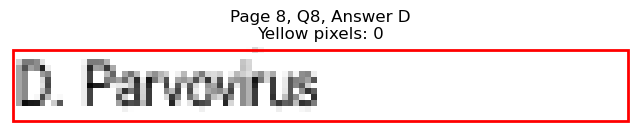

Page 8, Q8 - E: Detected box: x0=322.9, y0=591.5, x1=381.6, y1=603.5
Page 8, Q8, E: Yellow pixels: 499
Page 8, Q8, E: Total non-white pixels: 754
Page 8, Q8, E: Yellow percentage: 66.2%


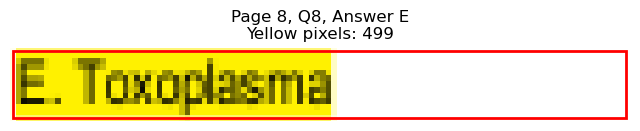


Page 8, Q8 - Selected Answer: E (based on yellow pixel count)




Page 8, Q9 - A: Detected box: x0=71.3, y0=651.5, x1=79.7, y1=663.6
Page 8, Q9, A: Yellow pixels: 0
Page 8, Q9, A: Total non-white pixels: 63
Page 8, Q9, A: Yellow percentage: 0.0%


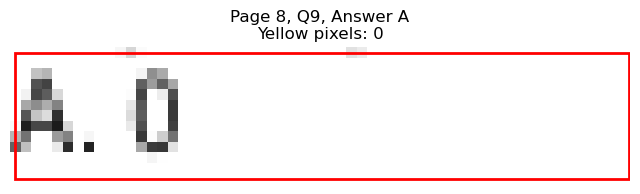

Page 8, Q9 - B: Detected box: x0=71.3, y0=663.5, x1=86.5, y1=675.6
Page 8, Q9, B: Yellow pixels: 0
Page 8, Q9, B: Total non-white pixels: 58
Page 8, Q9, B: Yellow percentage: 0.0%


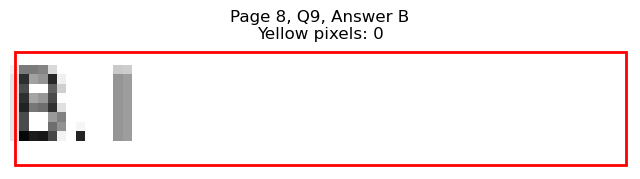

Page 8, Q9 - C: Detected box: x0=71.3, y0=676.3, x1=91.7, y1=688.3
Page 8, Q9, C: Yellow pixels: 0
Page 8, Q9, C: Total non-white pixels: 78
Page 8, Q9, C: Yellow percentage: 0.0%


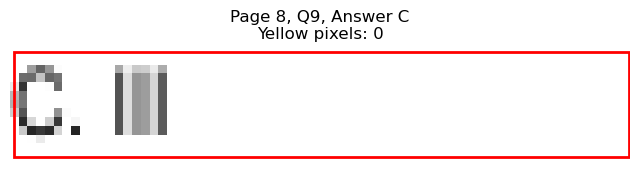

Page 8, Q9 - D: Detected box: x0=322.9, y0=651.5, x1=341.1, y1=663.6
Page 8, Q9, D: Yellow pixels: 157
Page 8, Q9, D: Total non-white pixels: 221
Page 8, Q9, D: Yellow percentage: 71.0%


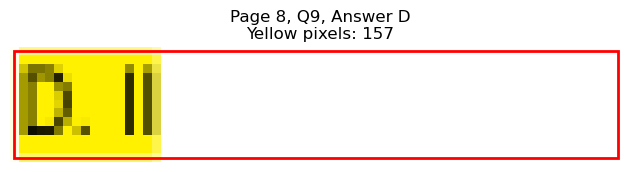

Page 8, Q9 - E: Detected box: x0=322.9, y0=663.5, x1=343.3, y1=675.6
Page 8, Q9, E: Yellow pixels: 16
Page 8, Q9, E: Total non-white pixels: 97
Page 8, Q9, E: Yellow percentage: 16.5%


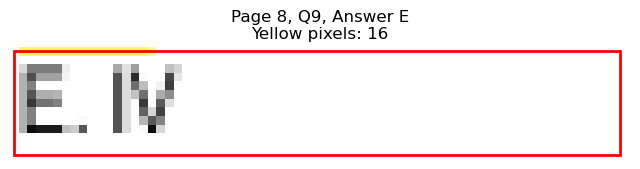


Page 8, Q9 - Selected Answer: D (based on yellow pixel count)




Page 8, Q10 - A: Detected box: x0=82.6, y0=712.3, x1=255.5, y1=724.4
Page 8, Q10, A: Yellow pixels: 1332
Page 8, Q10, A: Total non-white pixels: 2236
Page 8, Q10, A: Yellow percentage: 59.6%


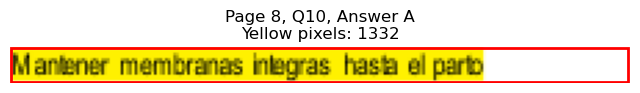

Page 8, Q10 - B: Detected box: x0=71.3, y0=724.3, x1=136.0, y1=736.4
Page 8, Q10, B: Yellow pixels: 2
Page 8, Q10, B: Total non-white pixels: 637
Page 8, Q10, B: Yellow percentage: 0.3%


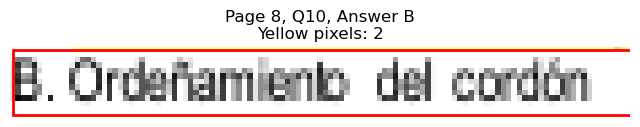

Page 8, Q10 - C: Detected box: x0=71.3, y0=736.4, x1=127.7, y1=748.4
Page 8, Q10, C: Yellow pixels: 0
Page 8, Q10, C: Total non-white pixels: 444
Page 8, Q10, C: Yellow percentage: 0.0%


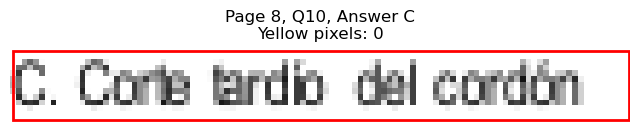

Page 8, Q10 - D: Detected box: x0=322.9, y0=712.3, x1=434.0, y1=724.4
Page 8, Q10, D: Yellow pixels: 0
Page 8, Q10, D: Total non-white pixels: 504
Page 8, Q10, D: Yellow percentage: 0.0%


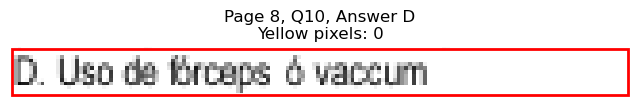

Page 8, Q10 - E: Detected box: x0=322.9, y0=724.3, x1=407.9, y1=736.4
Page 8, Q10, E: Yellow pixels: 0
Page 8, Q10, E: Total non-white pixels: 440
Page 8, Q10, E: Yellow percentage: 0.0%


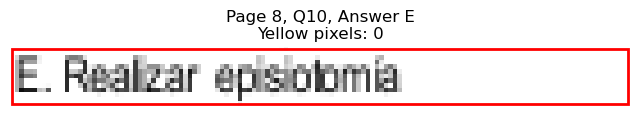


Page 8, Q10 - Selected Answer: A (based on yellow pixel count)





Page 9: Found 10 questions
Page 9, Q1 - A: Detected box: x0=82.6, y0=109.5, x1=167.6, y1=121.6
Page 9, Q1, A: Yellow pixels: 0
Page 9, Q1, A: Total non-white pixels: 441
Page 9, Q1, A: Yellow percentage: 0.0%


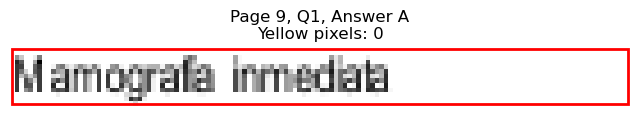

Page 9, Q1 - B: Detected box: x0=71.3, y0=121.5, x1=156.3, y1=133.6
Page 9, Q1, B: Yellow pixels: 738
Page 9, Q1, B: Total non-white pixels: 1079
Page 9, Q1, B: Yellow percentage: 68.4%


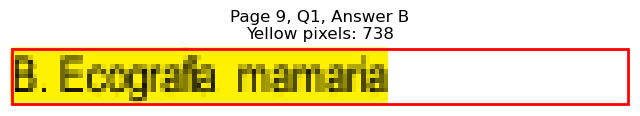

Page 9, Q1 - C: Detected box: x0=71.3, y0=133.5, x1=199.9, y1=145.6
Page 9, Q1, C: Yellow pixels: 83
Page 9, Q1, C: Total non-white pixels: 700
Page 9, Q1, C: Yellow percentage: 11.9%


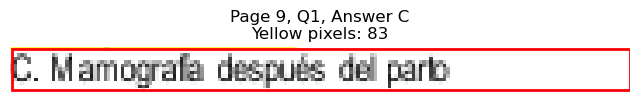

Page 9, Q1 - D: Detected box: x0=322.9, y0=109.5, x1=438.4, y1=121.6
Page 9, Q1, D: Yellow pixels: 0
Page 9, Q1, D: Total non-white pixels: 539
Page 9, Q1, D: Yellow percentage: 0.0%


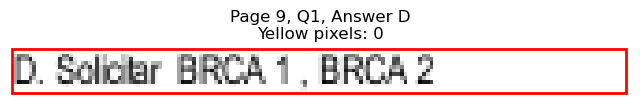

Page 9, Q1 - E: Detected box: x0=322.9, y0=121.5, x1=442.3, y1=133.6
Page 9, Q1, E: Yellow pixels: 0
Page 9, Q1, E: Total non-white pixels: 572
Page 9, Q1, E: Yellow percentage: 0.0%


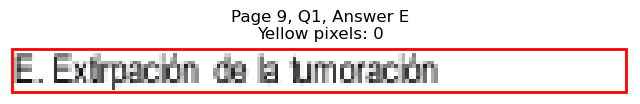


Page 9, Q1 - Selected Answer: B (based on yellow pixel count)




Page 9, Q2 - A: Detected box: x0=82.6, y0=169.6, x1=183.3, y1=181.6
Page 9, Q2, A: Yellow pixels: 0
Page 9, Q2, A: Total non-white pixels: 493
Page 9, Q2, A: Yellow percentage: 0.0%


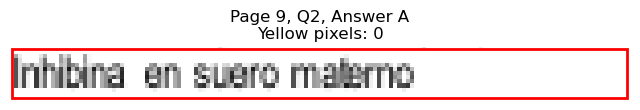

Page 9, Q2 - B: Detected box: x0=71.3, y0=181.6, x1=250.7, y1=193.6
Page 9, Q2, B: Yellow pixels: 0
Page 9, Q2, B: Total non-white pixels: 801
Page 9, Q2, B: Yellow percentage: 0.0%


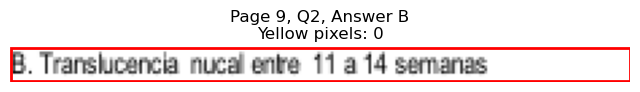

Page 9, Q2 - C: Detected box: x0=71.3, y0=193.6, x1=169.8, y1=205.6
Page 9, Q2, C: Yellow pixels: 0
Page 9, Q2, C: Total non-white pixels: 432
Page 9, Q2, C: Yellow percentage: 0.0%


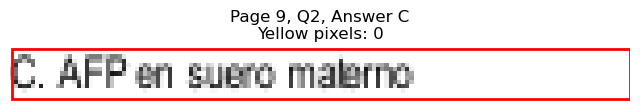

Page 9, Q2 - D: Detected box: x0=322.9, y0=169.6, x1=450.5, y1=181.6
Page 9, Q2, D: Yellow pixels: 0
Page 9, Q2, D: Total non-white pixels: 588
Page 9, Q2, D: Yellow percentage: 0.0%


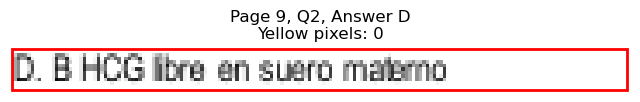

Page 9, Q2 - E: Detected box: x0=372.4, y0=181.6, x1=459.7, y1=193.6
Page 9, Q2, E: Yellow pixels: 684
Page 9, Q2, E: Total non-white pixels: 1118
Page 9, Q2, E: Yellow percentage: 61.2%


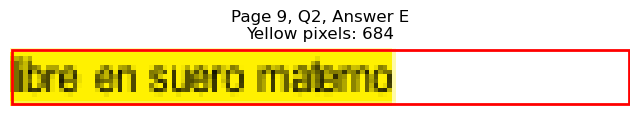


Page 9, Q2 - Selected Answer: E (based on yellow pixel count)




Page 9, Q3 - A: Detected box: x0=82.6, y0=241.6, x1=134.5, y1=253.7
Page 9, Q3, A: Yellow pixels: 542
Page 9, Q3, A: Total non-white pixels: 910
Page 9, Q3, A: Yellow percentage: 59.6%


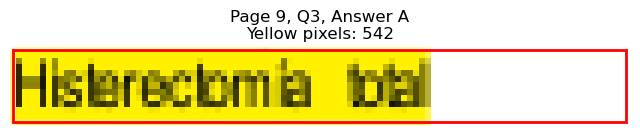

Page 9, Q3 - B: Detected box: x0=71.3, y0=253.6, x1=133.7, y1=265.7
Page 9, Q3, B: Yellow pixels: 69
Page 9, Q3, B: Total non-white pixels: 606
Page 9, Q3, B: Yellow percentage: 11.4%


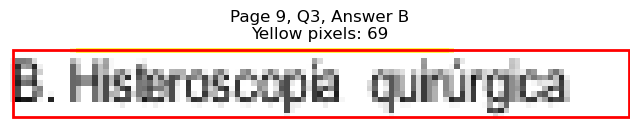

Page 9, Q3 - C: Detected box: x0=71.3, y0=265.7, x1=168.2, y1=277.7
Page 9, Q3, C: Yellow pixels: 0
Page 9, Q3, C: Total non-white pixels: 466
Page 9, Q3, C: Yellow percentage: 0.0%


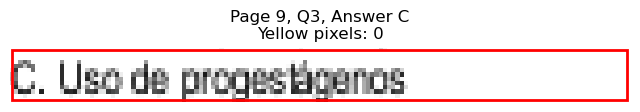

Page 9, Q3 - D: Detected box: x0=322.9, y0=241.6, x1=386.0, y1=253.7
Page 9, Q3, D: Yellow pixels: 0
Page 9, Q3, D: Total non-white pixels: 492
Page 9, Q3, D: Yellow percentage: 0.0%


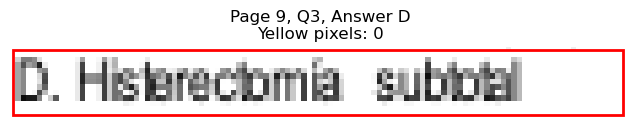

Page 9, Q3 - E: Detected box: x0=322.9, y0=253.6, x1=413.0, y1=265.7
Page 9, Q3, E: Yellow pixels: 0
Page 9, Q3, E: Total non-white pixels: 464
Page 9, Q3, E: Yellow percentage: 0.0%


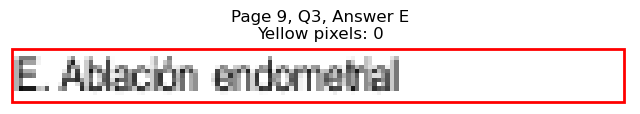


Page 9, Q3 - Selected Answer: A (based on yellow pixel count)




Page 9, Q4 - A: Detected box: x0=82.6, y0=302.5, x1=189.4, y1=314.5
Page 9, Q4, A: Yellow pixels: 934
Page 9, Q4, A: Total non-white pixels: 1366
Page 9, Q4, A: Yellow percentage: 68.4%


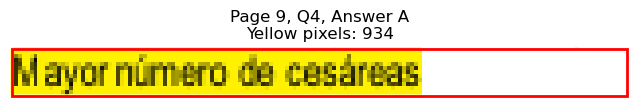

Page 9, Q4 - B: Detected box: x0=71.3, y0=314.5, x1=128.5, y1=326.5
Page 9, Q4, B: Yellow pixels: 96
Page 9, Q4, B: Total non-white pixels: 412
Page 9, Q4, B: Yellow percentage: 23.3%


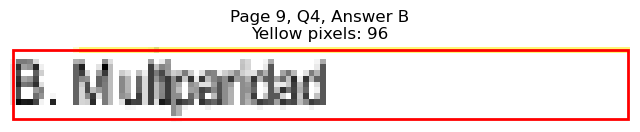

Page 9, Q4 - C: Detected box: x0=71.3, y0=326.5, x1=148.7, y1=338.5
Page 9, Q4, C: Yellow pixels: 0
Page 9, Q4, C: Total non-white pixels: 380
Page 9, Q4, C: Yellow percentage: 0.0%


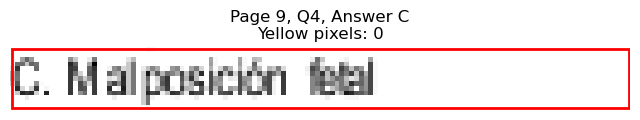

Page 9, Q4 - D: Detected box: x0=322.9, y0=302.5, x1=412.3, y1=314.5
Page 9, Q4, D: Yellow pixels: 0
Page 9, Q4, D: Total non-white pixels: 442
Page 9, Q4, D: Yellow percentage: 0.0%


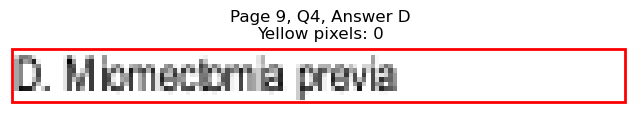

Page 9, Q4 - E: Detected box: x0=322.9, y0=314.5, x1=482.0, y1=326.5
Page 9, Q4, E: Yellow pixels: 0
Page 9, Q4, E: Total non-white pixels: 778
Page 9, Q4, E: Yellow percentage: 0.0%


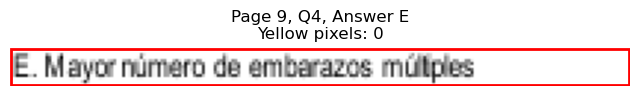


Page 9, Q4 - Selected Answer: A (based on yellow pixel count)




Page 9, Q5 - A: Detected box: x0=82.6, y0=362.5, x1=135.9, y1=374.6
Page 9, Q5, A: Yellow pixels: 0
Page 9, Q5, A: Total non-white pixels: 226
Page 9, Q5, A: Yellow percentage: 0.0%


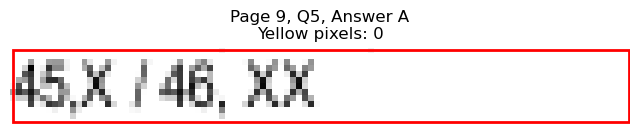

Page 9, Q5 - B: Detected box: x0=71.3, y0=374.5, x1=132.9, y1=386.6
Page 9, Q5, B: Yellow pixels: 0
Page 9, Q5, B: Total non-white pixels: 266
Page 9, Q5, B: Yellow percentage: 0.0%


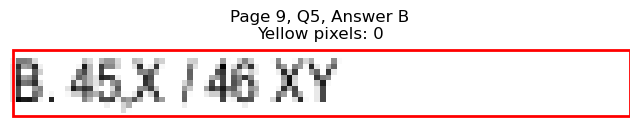

Page 9, Q5 - C: Detected box: x0=71.3, y0=386.5, x1=111.2, y1=398.6
Page 9, Q5, C: Yellow pixels: 0
Page 9, Q5, C: Total non-white pixels: 157
Page 9, Q5, C: Yellow percentage: 0.0%


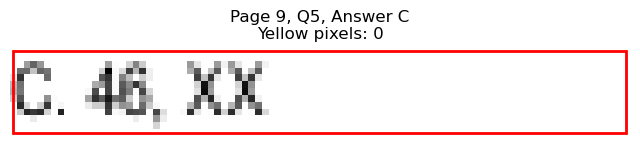

Page 9, Q5 - D: Detected box: x0=322.9, y0=362.5, x1=356.8, y1=374.6
Page 9, Q5, D: Yellow pixels: 313
Page 9, Q5, D: Total non-white pixels: 429
Page 9, Q5, D: Yellow percentage: 73.0%


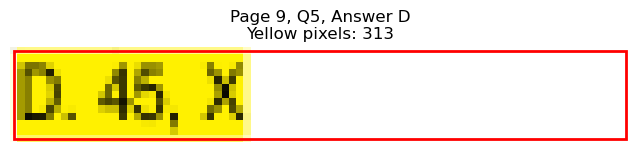

Page 9, Q5 - E: Detected box: x0=322.9, y0=374.5, x1=362.0, y1=386.6
Page 9, Q5, E: Yellow pixels: 31
Page 9, Q5, E: Total non-white pixels: 191
Page 9, Q5, E: Yellow percentage: 16.2%


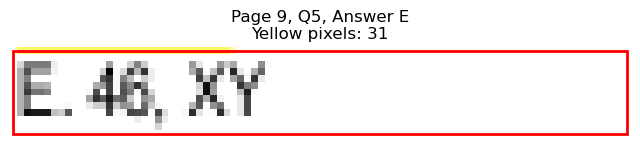


Page 9, Q5 - Selected Answer: D (based on yellow pixel count)




Page 9, Q6 - A: Detected box: x0=71.3, y0=422.5, x1=79.7, y1=434.6
Page 9, Q6, A: Yellow pixels: 0
Page 9, Q6, A: Total non-white pixels: 52
Page 9, Q6, A: Yellow percentage: 0.0%


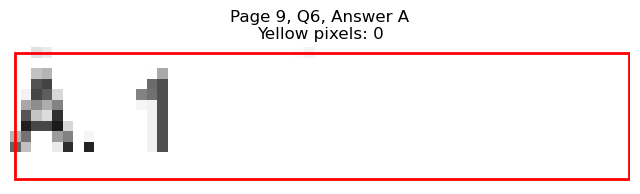

Page 9, Q6 - B: Detected box: x0=71.3, y0=434.6, x1=88.7, y1=446.6
Page 9, Q6, B: Yellow pixels: 0
Page 9, Q6, B: Total non-white pixels: 66
Page 9, Q6, B: Yellow percentage: 0.0%


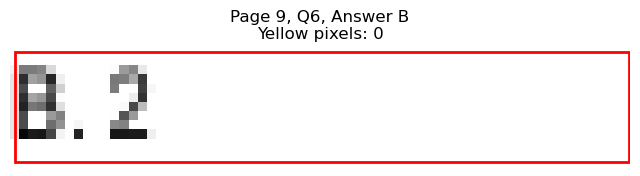

Page 9, Q6 - C: Detected box: x0=71.3, y0=446.6, x1=89.5, y1=458.6
Page 9, Q6, C: Yellow pixels: 146
Page 9, Q6, C: Total non-white pixels: 221
Page 9, Q6, C: Yellow percentage: 66.1%


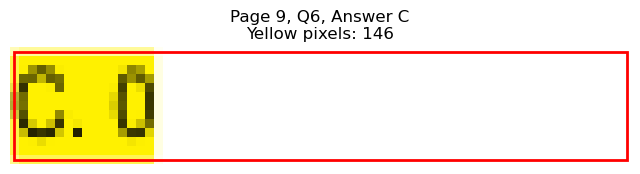

Page 9, Q6 - D: Detected box: x0=322.9, y0=422.5, x1=341.0, y1=434.6
Page 9, Q6, D: Yellow pixels: 0
Page 9, Q6, D: Total non-white pixels: 72
Page 9, Q6, D: Yellow percentage: 0.0%


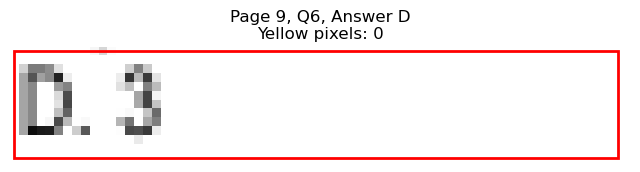

Page 9, Q6 - E: Detected box: x0=322.9, y0=434.6, x1=340.3, y1=446.6
Page 9, Q6, E: Yellow pixels: 0
Page 9, Q6, E: Total non-white pixels: 64
Page 9, Q6, E: Yellow percentage: 0.0%


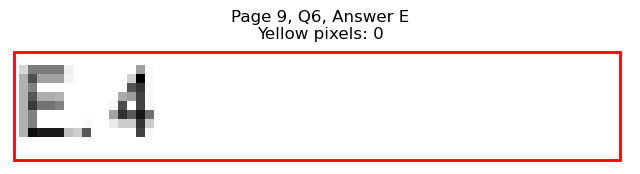


Page 9, Q6 - Selected Answer: C (based on yellow pixel count)




Page 9, Q7 - A: Detected box: x0=71.3, y0=495.4, x1=79.7, y1=507.4
Page 9, Q7, A: Yellow pixels: 0
Page 9, Q7, A: Total non-white pixels: 58
Page 9, Q7, A: Yellow percentage: 0.0%


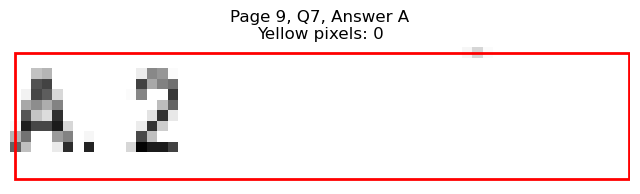

Page 9, Q7 - B: Detected box: x0=71.3, y0=507.4, x1=95.5, y1=519.4
Page 9, Q7, B: Yellow pixels: 0
Page 9, Q7, B: Total non-white pixels: 98
Page 9, Q7, B: Yellow percentage: 0.0%


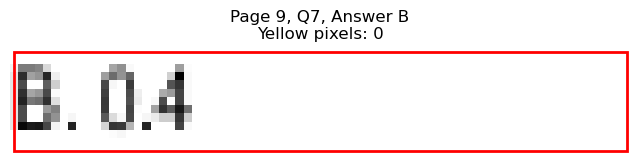

Page 9, Q7 - C: Detected box: x0=71.3, y0=519.4, x1=96.2, y1=531.4
Page 9, Q7, C: Yellow pixels: 0
Page 9, Q7, C: Total non-white pixels: 94
Page 9, Q7, C: Yellow percentage: 0.0%


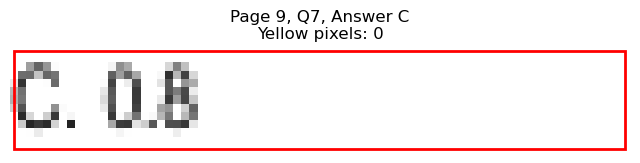

Page 9, Q7 - D: Detected box: x0=322.9, y0=495.4, x1=341.1, y1=507.4
Page 9, Q7, D: Yellow pixels: 154
Page 9, Q7, D: Total non-white pixels: 221
Page 9, Q7, D: Yellow percentage: 69.7%


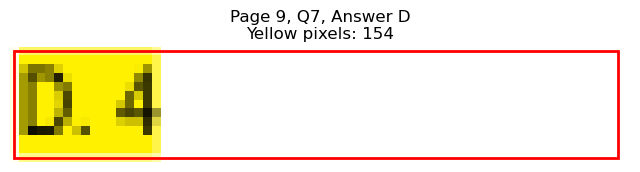

Page 9, Q7 - E: Detected box: x0=322.9, y0=507.4, x1=340.3, y1=519.4
Page 9, Q7, E: Yellow pixels: 15
Page 9, Q7, E: Total non-white pixels: 71
Page 9, Q7, E: Yellow percentage: 21.1%


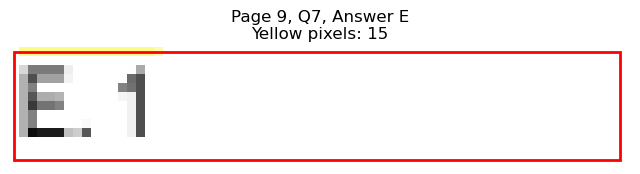


Page 9, Q7 - Selected Answer: D (based on yellow pixel count)




Page 9, Q8 - A: Detected box: x0=82.6, y0=555.4, x1=177.2, y1=567.5
Page 9, Q8, A: Yellow pixels: 0
Page 9, Q8, A: Total non-white pixels: 701
Page 9, Q8, A: Yellow percentage: 0.0%


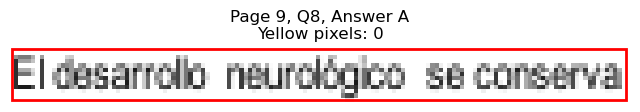

Page 9, Q8 - B: Detected box: x0=71.3, y0=567.5, x1=224.6, y1=579.5
Page 9, Q8, B: Yellow pixels: 0
Page 9, Q8, B: Total non-white pixels: 737
Page 9, Q8, B: Yellow percentage: 0.0%


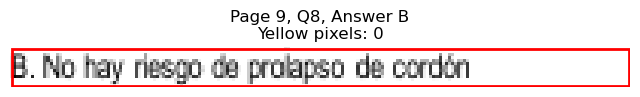

Page 9, Q8 - C: Detected box: x0=71.3, y0=579.4, x1=259.2, y1=591.5
Page 9, Q8, C: Yellow pixels: 0
Page 9, Q8, C: Total non-white pixels: 898
Page 9, Q8, C: Yellow percentage: 0.0%


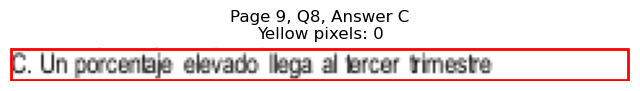

Page 9, Q8 - D: Detected box: x0=322.9, y0=555.4, x1=413.9, y1=567.5
Page 9, Q8, D: Yellow pixels: 0
Page 9, Q8, D: Total non-white pixels: 660
Page 9, Q8, D: Yellow percentage: 0.0%


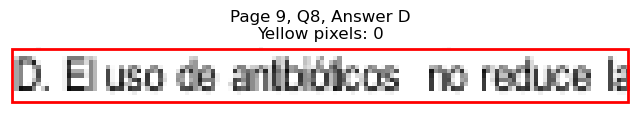

Page 9, Q8 - E: Detected box: x0=322.9, y0=579.4, x1=416.1, y1=591.5
Page 9, Q8, E: Yellow pixels: 1303
Page 9, Q8, E: Total non-white pixels: 1885
Page 9, Q8, E: Yellow percentage: 69.1%


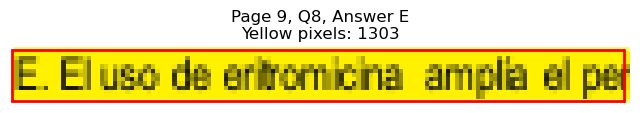


Page 9, Q8 - Selected Answer: E (based on yellow pixel count)




Page 9, Q9 - A: Detected box: x0=147.1, y0=639.5, x1=214.9, y1=651.6
Page 9, Q9, A: Yellow pixels: 559
Page 9, Q9, A: Total non-white pixels: 858
Page 9, Q9, A: Yellow percentage: 65.2%


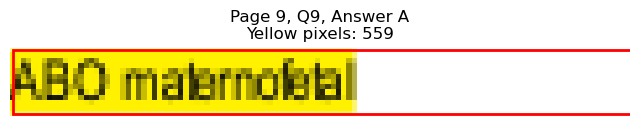

Page 9, Q9 - B: Detected box: x0=71.3, y0=651.5, x1=156.2, y1=663.6
Page 9, Q9, B: Yellow pixels: 124
Page 9, Q9, B: Total non-white pixels: 788
Page 9, Q9, B: Yellow percentage: 15.7%


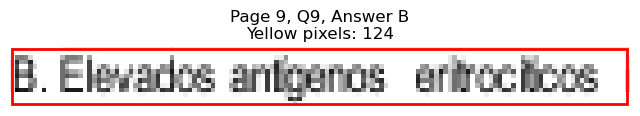

Page 9, Q9 - C: Detected box: x0=71.3, y0=663.5, x1=184.0, y1=675.6
Page 9, Q9, C: Yellow pixels: 0
Page 9, Q9, C: Total non-white pixels: 822
Page 9, Q9, C: Yellow percentage: 0.0%


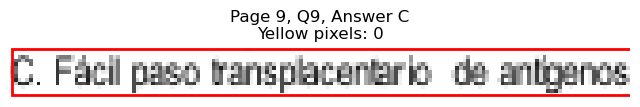

Page 9, Q9 - D: Detected box: x0=322.9, y0=639.5, x1=384.5, y1=651.6
Page 9, Q9, D: Yellow pixels: 0
Page 9, Q9, D: Total non-white pixels: 480
Page 9, Q9, D: Yellow percentage: 0.0%


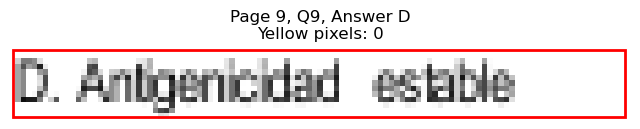

Page 9, Q9 - E: Detected box: x0=322.9, y0=651.5, x1=418.3, y1=663.6
Page 9, Q9, E: Yellow pixels: 0
Page 9, Q9, E: Total non-white pixels: 737
Page 9, Q9, E: Yellow percentage: 0.0%


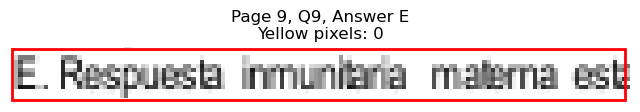


Page 9, Q9 - Selected Answer: A (based on yellow pixel count)




Page 9, Q10 - A: Detected box: x0=82.6, y0=724.3, x1=195.2, y1=736.4
Page 9, Q10, A: Yellow pixels: 0
Page 9, Q10, A: Total non-white pixels: 574
Page 9, Q10, A: Yellow percentage: 0.0%


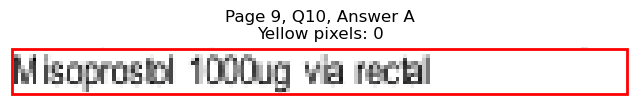

Page 9, Q10 - B: Detected box: x0=71.3, y0=736.4, x1=218.5, y1=748.4
Page 9, Q10, B: Yellow pixels: 0
Page 9, Q10, B: Total non-white pixels: 723
Page 9, Q10, B: Yellow percentage: 0.0%


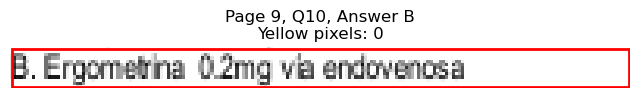

Page 9, Q10 - C: Detected box: x0=71.3, y0=748.4, x1=212.4, y1=760.4
Page 9, Q10, C: Yellow pixels: 0
Page 9, Q10, C: Total non-white pixels: 671
Page 9, Q10, C: Yellow percentage: 0.0%


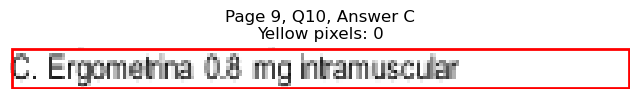

Page 9, Q10 - D: Detected box: x0=322.9, y0=724.3, x1=441.7, y1=736.4
Page 9, Q10, D: Yellow pixels: 929
Page 9, Q10, D: Total non-white pixels: 1534
Page 9, Q10, D: Yellow percentage: 60.6%


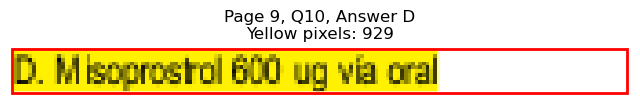

Page 9, Q10 - E: Detected box: x0=396.4, y0=736.4, x1=470.9, y1=748.4
Page 9, Q10, E: Yellow pixels: 2
Page 9, Q10, E: Total non-white pixels: 412
Page 9, Q10, E: Yellow percentage: 0.5%


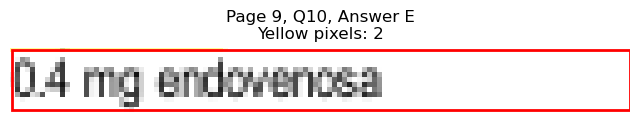


Page 9, Q10 - Selected Answer: D (based on yellow pixel count)





Page 10: Found 10 questions
Page 10, Q1 - A: Detected box: x0=82.6, y0=96.8, x1=162.3, y1=108.8
Page 10, Q1, A: Yellow pixels: 0
Page 10, Q1, A: Total non-white pixels: 433
Page 10, Q1, A: Yellow percentage: 0.0%


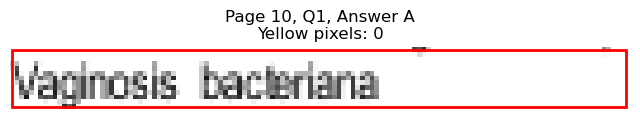

Page 10, Q1 - B: Detected box: x0=71.3, y0=109.5, x1=173.6, y1=121.6
Page 10, Q1, B: Yellow pixels: 902
Page 10, Q1, B: Total non-white pixels: 1313
Page 10, Q1, B: Yellow percentage: 68.7%


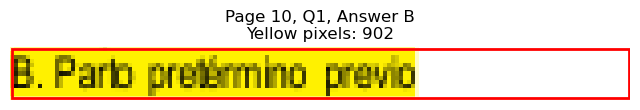

Page 10, Q1 - C: Detected box: x0=71.3, y0=121.5, x1=130.7, y1=133.6
Page 10, Q1, C: Yellow pixels: 100
Page 10, Q1, C: Total non-white pixels: 382
Page 10, Q1, C: Yellow percentage: 26.2%


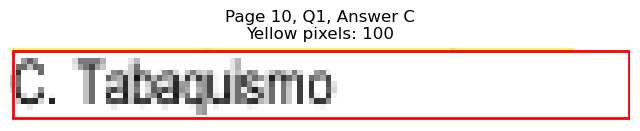

Page 10, Q1 - D: Detected box: x0=322.9, y0=96.8, x1=412.3, y1=108.8
Page 10, Q1, D: Yellow pixels: 0
Page 10, Q1, D: Total non-white pixels: 446
Page 10, Q1, D: Yellow percentage: 0.0%


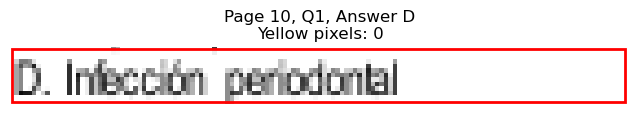

Page 10, Q1 - E: Detected box: x0=322.9, y0=109.5, x1=403.3, y1=121.6
Page 10, Q1, E: Yellow pixels: 0
Page 10, Q1, E: Total non-white pixels: 375
Page 10, Q1, E: Yellow percentage: 0.0%


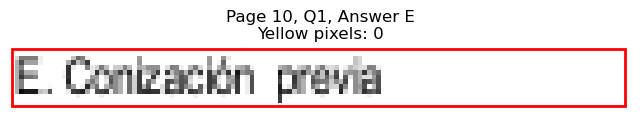


Page 10, Q1 - Selected Answer: B (based on yellow pixel count)




Page 10, Q2 - A: Detected box: x0=82.6, y0=169.6, x1=149.5, y1=181.6
Page 10, Q2, A: Yellow pixels: 0
Page 10, Q2, A: Total non-white pixels: 339
Page 10, Q2, A: Yellow percentage: 0.0%


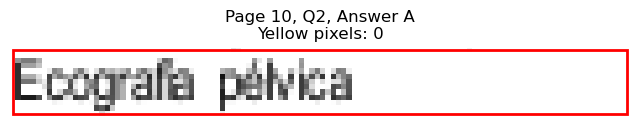

Page 10, Q2 - B: Detected box: x0=71.3, y0=181.6, x1=188.5, y1=193.6
Page 10, Q2, B: Yellow pixels: 0
Page 10, Q2, B: Total non-white pixels: 606
Page 10, Q2, B: Yellow percentage: 0.0%


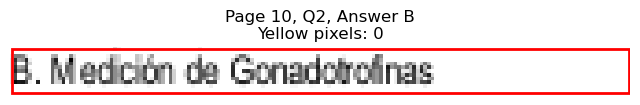

Page 10, Q2 - C: Detected box: x0=71.3, y0=193.6, x1=181.0, y1=205.6
Page 10, Q2, C: Yellow pixels: 0
Page 10, Q2, C: Total non-white pixels: 505
Page 10, Q2, C: Yellow percentage: 0.0%


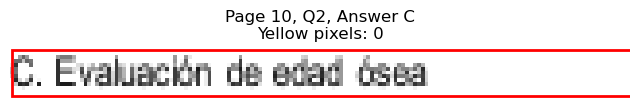

Page 10, Q2 - D: Detected box: x0=322.9, y0=169.6, x1=368.1, y1=181.6
Page 10, Q2, D: Yellow pixels: 334
Page 10, Q2, D: Total non-white pixels: 572
Page 10, Q2, D: Yellow percentage: 58.4%


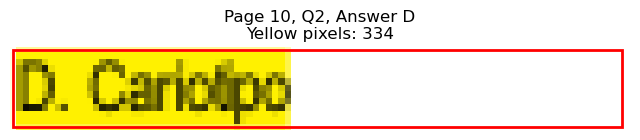

Page 10, Q2 - E: Detected box: x0=322.9, y0=181.6, x1=421.3, y1=193.6
Page 10, Q2, E: Yellow pixels: 43
Page 10, Q2, E: Total non-white pixels: 536
Page 10, Q2, E: Yellow percentage: 8.0%


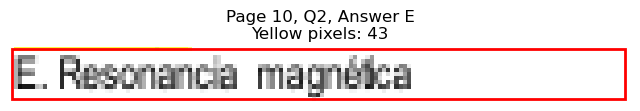


Page 10, Q2 - Selected Answer: D (based on yellow pixel count)




Page 10, Q3 - A: Detected box: x0=82.6, y0=241.6, x1=174.4, y1=253.7
Page 10, Q3, A: Yellow pixels: 709
Page 10, Q3, A: Total non-white pixels: 1170
Page 10, Q3, A: Yellow percentage: 60.6%


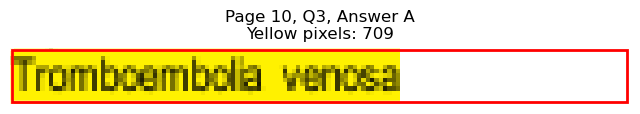

Page 10, Q3 - B: Detected box: x0=71.3, y0=253.6, x1=137.5, y1=265.7
Page 10, Q3, B: Yellow pixels: 89
Page 10, Q3, B: Total non-white pixels: 435
Page 10, Q3, B: Yellow percentage: 20.5%


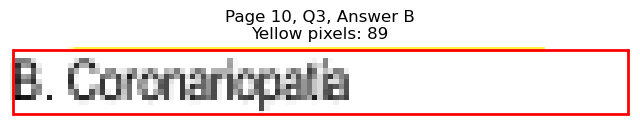

Page 10, Q3 - C: Detected box: x0=71.3, y0=265.7, x1=151.0, y1=277.7
Page 10, Q3, C: Yellow pixels: 0
Page 10, Q3, C: Total non-white pixels: 352
Page 10, Q3, C: Yellow percentage: 0.0%


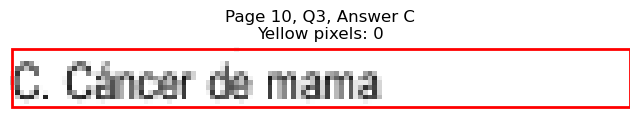

Page 10, Q3 - D: Detected box: x0=322.9, y0=241.6, x1=398.0, y1=253.7
Page 10, Q3, D: Yellow pixels: 0
Page 10, Q3, D: Total non-white pixels: 342
Page 10, Q3, D: Yellow percentage: 0.0%


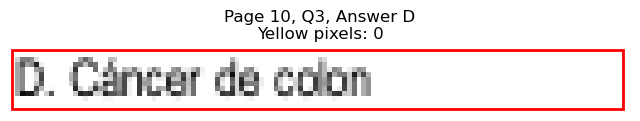

Page 10, Q3 - E: Detected box: x0=322.9, y0=253.6, x1=400.3, y1=265.7
Page 10, Q3, E: Yellow pixels: 0
Page 10, Q3, E: Total non-white pixels: 360
Page 10, Q3, E: Yellow percentage: 0.0%


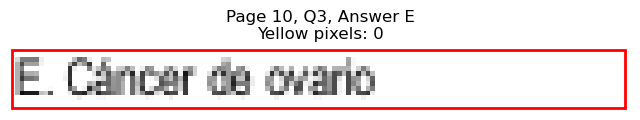


Page 10, Q3 - Selected Answer: A (based on yellow pixel count)




Page 10, Q4 - A: Detected box: x0=82.6, y0=314.5, x1=195.2, y1=326.5
Page 10, Q4, A: Yellow pixels: 0
Page 10, Q4, A: Total non-white pixels: 538
Page 10, Q4, A: Yellow percentage: 0.0%


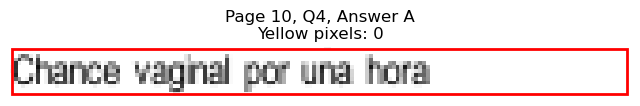

Page 10, Q4 - B: Detected box: x0=71.3, y0=326.5, x1=158.5, y1=338.5
Page 10, Q4, B: Yellow pixels: 0
Page 10, Q4, B: Total non-white pixels: 432
Page 10, Q4, B: Yellow percentage: 0.0%


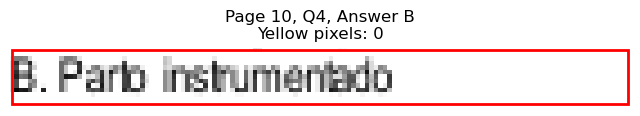

Page 10, Q4 - C: Detected box: x0=71.3, y0=338.5, x1=116.5, y1=350.5
Page 10, Q4, C: Yellow pixels: 394
Page 10, Q4, C: Total non-white pixels: 572
Page 10, Q4, C: Yellow percentage: 68.9%


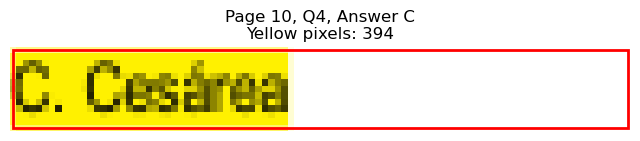

Page 10, Q4 - D: Detected box: x0=322.9, y0=314.5, x1=434.0, y1=326.5
Page 10, Q4, D: Yellow pixels: 0
Page 10, Q4, D: Total non-white pixels: 536
Page 10, Q4, D: Yellow percentage: 0.0%


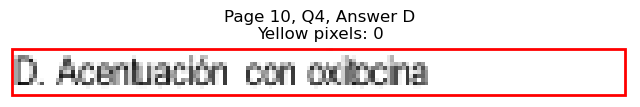

Page 10, Q4 - E: Detected box: x0=322.9, y0=326.5, x1=406.3, y1=338.5
Page 10, Q4, E: Yellow pixels: 0
Page 10, Q4, E: Total non-white pixels: 407
Page 10, Q4, E: Yellow percentage: 0.0%


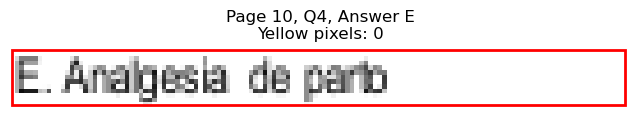


Page 10, Q4 - Selected Answer: C (based on yellow pixel count)




Page 10, Q5 - A: Detected box: x0=82.6, y0=374.5, x1=163.8, y1=386.6
Page 10, Q5, A: Yellow pixels: 0
Page 10, Q5, A: Total non-white pixels: 433
Page 10, Q5, A: Yellow percentage: 0.0%


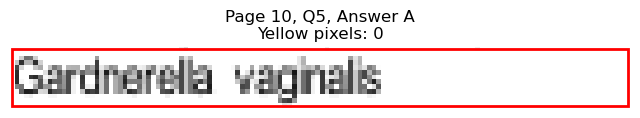

Page 10, Q5 - B: Detected box: x0=71.3, y0=386.5, x1=127.7, y1=398.6
Page 10, Q5, B: Yellow pixels: 740
Page 10, Q5, B: Total non-white pixels: 1170
Page 10, Q5, B: Yellow percentage: 63.2%


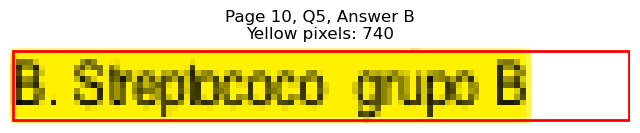

Page 10, Q5 - C: Detected box: x0=71.3, y0=398.5, x1=143.5, y1=410.6
Page 10, Q5, C: Yellow pixels: 90
Page 10, Q5, C: Total non-white pixels: 411
Page 10, Q5, C: Yellow percentage: 21.9%


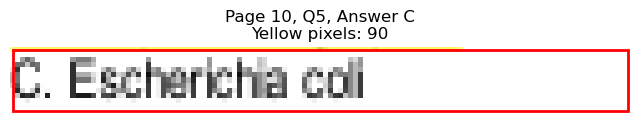

Page 10, Q5 - D: Detected box: x0=322.9, y0=374.5, x1=378.5, y1=386.6
Page 10, Q5, D: Yellow pixels: 0
Page 10, Q5, D: Total non-white pixels: 274
Page 10, Q5, D: Yellow percentage: 0.0%


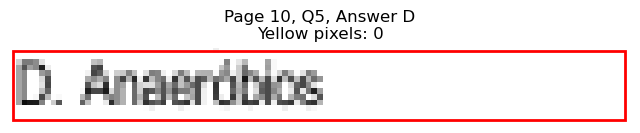

Page 10, Q5 - E: Detected box: x0=322.9, y0=386.5, x1=383.8, y1=398.6
Page 10, Q5, E: Yellow pixels: 0
Page 10, Q5, E: Total non-white pixels: 306
Page 10, Q5, E: Yellow percentage: 0.0%


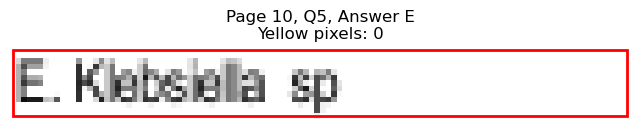


Page 10, Q5 - Selected Answer: B (based on yellow pixel count)




Page 10, Q6 - A: Detected box: x0=82.6, y0=446.6, x1=94.0, y1=458.6
Page 10, Q6, A: Yellow pixels: 64
Page 10, Q6, A: Total non-white pixels: 132
Page 10, Q6, A: Yellow percentage: 48.5%


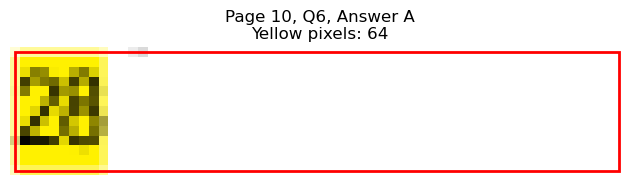

Page 10, Q6 - B: Detected box: x0=71.3, y0=458.6, x1=93.2, y1=470.6
Page 10, Q6, B: Yellow pixels: 9
Page 10, Q6, B: Total non-white pixels: 99
Page 10, Q6, B: Yellow percentage: 9.1%


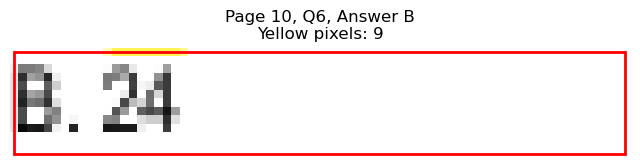

Page 10, Q6 - C: Detected box: x0=71.3, y0=470.6, x1=94.0, y1=482.6
Page 10, Q6, C: Yellow pixels: 0
Page 10, Q6, C: Total non-white pixels: 82
Page 10, Q6, C: Yellow percentage: 0.0%


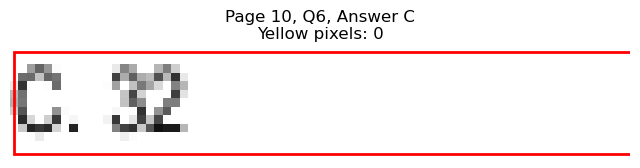

Page 10, Q6 - D: Detected box: x0=322.9, y0=446.6, x1=345.5, y1=458.6
Page 10, Q6, D: Yellow pixels: 0
Page 10, Q6, D: Total non-white pixels: 99
Page 10, Q6, D: Yellow percentage: 0.0%


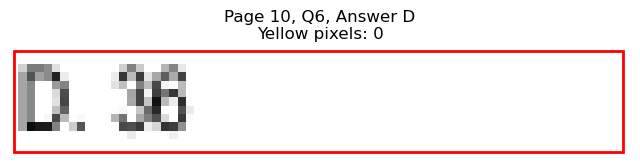

Page 10, Q6 - E: Detected box: x0=322.9, y0=458.6, x1=344.8, y1=470.6
Page 10, Q6, E: Yellow pixels: 0
Page 10, Q6, E: Total non-white pixels: 93
Page 10, Q6, E: Yellow percentage: 0.0%


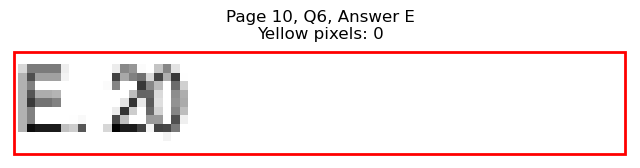


Page 10, Q6 - Selected Answer: A (based on yellow pixel count)




Page 10, Q7 - A: Detected box: x0=82.6, y0=519.4, x1=208.8, y1=531.4
Page 10, Q7, A: Yellow pixels: 0
Page 10, Q7, A: Total non-white pixels: 624
Page 10, Q7, A: Yellow percentage: 0.0%


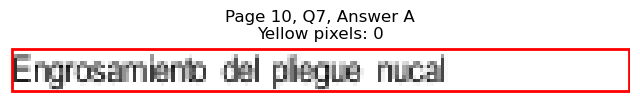

Page 10, Q7 - B: Detected box: x0=71.3, y0=531.4, x1=136.0, y1=543.5
Page 10, Q7, B: Yellow pixels: 0
Page 10, Q7, B: Total non-white pixels: 594
Page 10, Q7, B: Yellow percentage: 0.0%


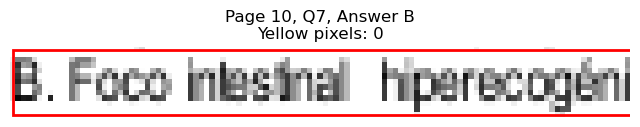

Page 10, Q7 - C: Detected box: x0=71.3, y0=543.4, x1=136.0, y1=555.5
Page 10, Q7, C: Yellow pixels: 0
Page 10, Q7, C: Total non-white pixels: 271
Page 10, Q7, C: Yellow percentage: 0.0%


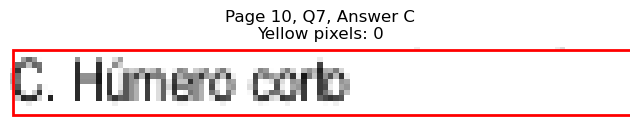

Page 10, Q7 - D: Detected box: x0=322.9, y0=519.4, x1=482.2, y1=531.4
Page 10, Q7, D: Yellow pixels: 1418
Page 10, Q7, D: Total non-white pixels: 2054
Page 10, Q7, D: Yellow percentage: 69.0%


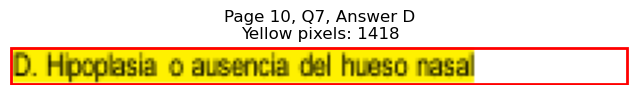

Page 10, Q7 - E: Detected box: x0=322.9, y0=531.4, x1=380.8, y1=543.5
Page 10, Q7, E: Yellow pixels: 108
Page 10, Q7, E: Total non-white pixels: 359
Page 10, Q7, E: Yellow percentage: 30.1%


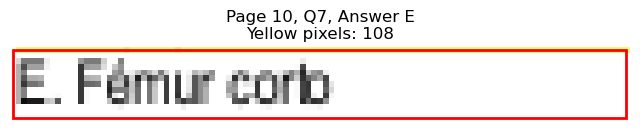


Page 10, Q7 - Selected Answer: D (based on yellow pixel count)




Page 10, Q8 - A: Detected box: x0=82.6, y0=579.4, x1=142.8, y1=591.5
Page 10, Q8, A: Yellow pixels: 0
Page 10, Q8, A: Total non-white pixels: 328
Page 10, Q8, A: Yellow percentage: 0.0%


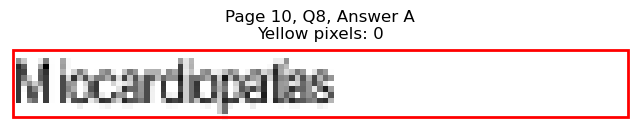

Page 10, Q8 - B: Detected box: x0=71.3, y0=591.5, x1=154.7, y1=603.5
Page 10, Q8, B: Yellow pixels: 0
Page 10, Q8, B: Total non-white pixels: 445
Page 10, Q8, B: Yellow percentage: 0.0%


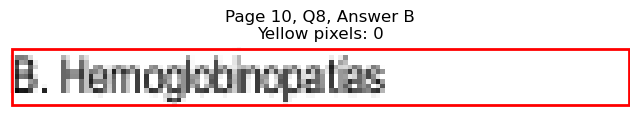

Page 10, Q8 - C: Detected box: x0=71.3, y0=603.5, x1=154.7, y1=615.5
Page 10, Q8, C: Yellow pixels: 0
Page 10, Q8, C: Total non-white pixels: 389
Page 10, Q8, C: Yellow percentage: 0.0%


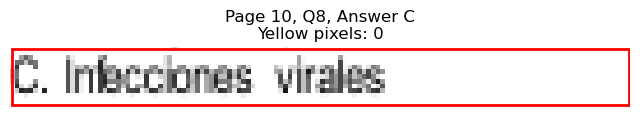

Page 10, Q8 - D: Detected box: x0=322.9, y0=579.4, x1=441.7, y1=591.5
Page 10, Q8, D: Yellow pixels: 1046
Page 10, Q8, D: Total non-white pixels: 1534
Page 10, Q8, D: Yellow percentage: 68.2%


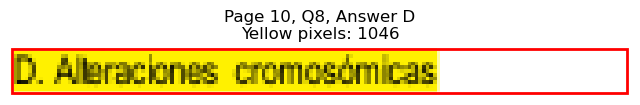

Page 10, Q8 - E: Detected box: x0=322.9, y0=591.5, x1=418.3, y1=603.5
Page 10, Q8, E: Yellow pixels: 116
Page 10, Q8, E: Total non-white pixels: 594
Page 10, Q8, E: Yellow percentage: 19.5%


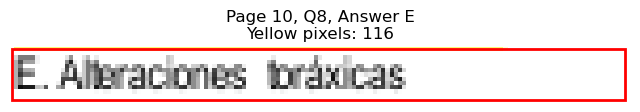


Page 10, Q8 - Selected Answer: D (based on yellow pixel count)




Page 10, Q9 - A: Detected box: x0=82.6, y0=651.5, x1=186.4, y1=663.6
Page 10, Q9, A: Yellow pixels: 864
Page 10, Q9, A: Total non-white pixels: 1326
Page 10, Q9, A: Yellow percentage: 65.2%


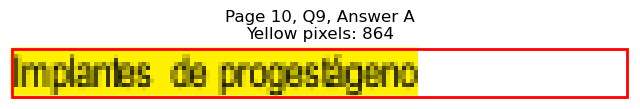

Page 10, Q9 - B: Detected box: x0=71.3, y0=663.5, x1=183.4, y1=675.6
Page 10, Q9, B: Yellow pixels: 101
Page 10, Q9, B: Total non-white pixels: 690
Page 10, Q9, B: Yellow percentage: 14.6%


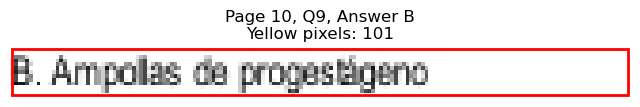

Page 10, Q9 - C: Detected box: x0=71.3, y0=676.3, x1=163.7, y1=688.3
Page 10, Q9, C: Yellow pixels: 0
Page 10, Q9, C: Total non-white pixels: 429
Page 10, Q9, C: Yellow percentage: 0.0%


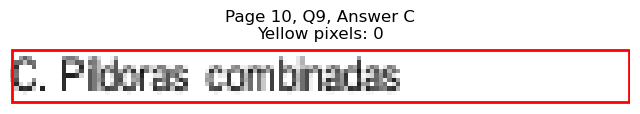

Page 10, Q9 - D: Detected box: x0=322.9, y0=651.5, x1=419.8, y1=663.6
Page 10, Q9, D: Yellow pixels: 0
Page 10, Q9, D: Total non-white pixels: 463
Page 10, Q9, D: Yellow percentage: 0.0%


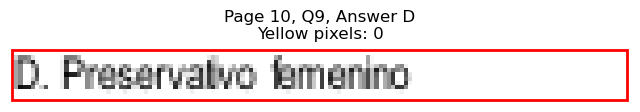

Page 10, Q9 - E: Detected box: x0=322.9, y0=663.5, x1=375.5, y1=675.6
Page 10, Q9, E: Yellow pixels: 0
Page 10, Q9, E: Total non-white pixels: 260
Page 10, Q9, E: Yellow percentage: 0.0%


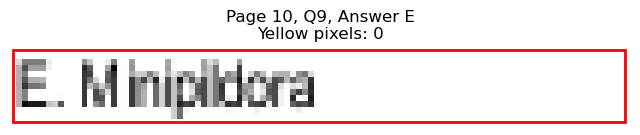


Page 10, Q9 - Selected Answer: A (based on yellow pixel count)




Page 10, Q10 - A: Detected box: x0=144.9, y0=712.3, x1=211.9, y1=724.4
Page 10, Q10, A: Yellow pixels: 498
Page 10, Q10, A: Total non-white pixels: 860
Page 10, Q10, A: Yellow percentage: 57.9%


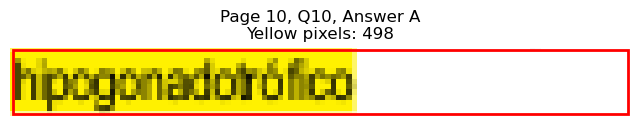

Page 10, Q10 - B: Detected box: x0=144.1, y0=724.3, x1=214.1, y1=736.4
Page 10, Q10, B: Yellow pixels: 3
Page 10, Q10, B: Total non-white pixels: 455
Page 10, Q10, B: Yellow percentage: 0.7%


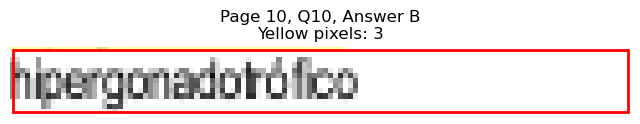

Page 10, Q10 - C: Detected box: x0=71.3, y0=736.4, x1=188.5, y1=748.4
Page 10, Q10, C: Yellow pixels: 0
Page 10, Q10, C: Total non-white pixels: 571
Page 10, Q10, C: Yellow percentage: 0.0%


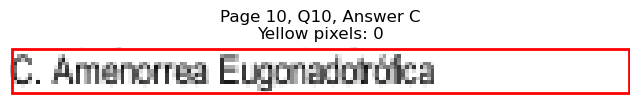

Page 10, Q10 - D: Detected box: x0=322.9, y0=712.3, x1=464.0, y1=724.4
Page 10, Q10, D: Yellow pixels: 0
Page 10, Q10, D: Total non-white pixels: 699
Page 10, Q10, D: Yellow percentage: 0.0%


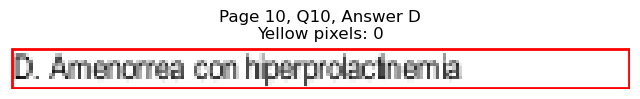

Page 10, Q10 - E: Detected box: x0=322.9, y0=724.3, x1=441.7, y1=736.4
Page 10, Q10, E: Yellow pixels: 0
Page 10, Q10, E: Total non-white pixels: 619
Page 10, Q10, E: Yellow percentage: 0.0%


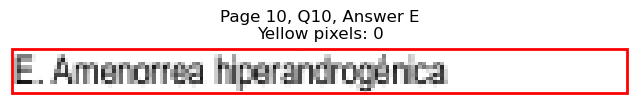


Page 10, Q10 - Selected Answer: A (based on yellow pixel count)






In [6]:
questions_df = extract_questions(pdf_path = pdf_file)
answers_df = extract_answers(pdf_path = pdf_file)
correct_answers_df = extract_correct_answers(pdf_path = pdf_file)

In [7]:
questions_df

question
0   Gestante de 33 semanas con un embarazo gemelar...
1   ¿Cuál es el tumor cardíaco más común durante l...
2   ¿Cuál es el factor más importante para la tran...
3   ¿Cuál es la causa más frecuente de amenorrea p...
4   ¿Cuál de los siguientes valores en sangre se e...
..                                                ...
95  Gestante Rh (-), con determinación de anticuer...
96  ¿Cuál de los siguientes hallazgos ecográficos ...
97  ¿Cuáles son las causas más frecuentes de hidro...
98  ¿Cuál de los siguientes anticonceptivos perten...
99  ¿A qué tipo de amenorrea hormonal corresponde ...

[100 rows x 1 columns]

In [8]:
answers_df

option_A  \
0   Maduración pulmonar y cesárea a las 48 horas   
1                                     Rabdomioma   
2                     Momento de inicio de TARGA   
3                                Tabique vaginal   
4                                  Transaminasas   
..                                           ...   
95                                            28   
96               Engrosamiento del pliegue nucal   
97                               Miocardiopatías   
98                     Implantes de progestágeno   
99               Hipogonadismo hipogonadotrófico   

                            option_B  \
0              Cesárea de emergencia   
1                        Endotelioma   
2                       Vía de parto   
3                  Himen imperforado   
4                 Fosfatasa alcalina   
..                               ...   
95                                24   
96    Foco intestinal hiperecogénico   
97                 Hemoglobinopatías   
98          Ampollas de progestágeno   
99  Hipogonadismo hipergonadotrófico   

                                       option_C  \
0       Maduración pulmonar y manejo expectante   
1                                       Adenoma   
2                             Lactancia materna   
3   Sindrome de insensibilidad a los andrógenos   
4                                   Bilirrubina   
..                                          ...   
95                                           32   
96                                 Húmero corto   
97                          Infecciones virales   
98                          Píldoras combinadas   
99                    Amenorrea Eugonadotrófica   

                                          option_D  \
0   Maduración pulmonar e inducción a las 48 horas   
1                                         Teratoma   
2                                 Carga viral alta   
3                  Sindrome de ovario poliquístico   
4                                      Fibrinógeno   
..                                             ...   
95                                              36   
96           Hipoplasia o ausencia del hueso nasal   
97                       Alteraciones cromosómicas   
98                           Preservativo femenino   
99                Amenorrea con hiperprolactinemia   

                               option_E  
0         Inducción del parto inmediato  
1                                Glioma  
2                  Recuento de CD4 bajo  
3   Agenesia de los conductos de Müller  
4                Deshidrogenasa láctica  
..                                  ...  
95                                   20  
96                          Fémur corto  
97               Alteraciones toráxicas  
98                          Minipildora  
99           Amenorrea hiperandrogénica  

[100 rows x 5 columns]

In [9]:
correct_answers_df

correct_answer
0               C
1               A
2               D
3               E
4               D
..            ...
95              A
96              D
97              D
98              A
99              A

[100 rows x 1 columns]

In [10]:
total_df = pd.concat([questions_df, answers_df, correct_answers_df], ignore_index = True, axis = 1)
total_df.columns = ["questions", "option_A", "option_B", "option_C", "option_D", "option_E", "correct_answer"]
total_df

questions  \
0   Gestante de 33 semanas con un embarazo gemelar...   
1   ¿Cuál es el tumor cardíaco más común durante l...   
2   ¿Cuál es el factor más importante para la tran...   
3   ¿Cuál es la causa más frecuente de amenorrea p...   
4   ¿Cuál de los siguientes valores en sangre se e...   
..                                                ...   
95  Gestante Rh (-), con determinación de anticuer...   
96  ¿Cuál de los siguientes hallazgos ecográficos ...   
97  ¿Cuáles son las causas más frecuentes de hidro...   
98  ¿Cuál de los siguientes anticonceptivos perten...   
99  ¿A qué tipo de amenorrea hormonal corresponde ...   

                                        option_A  \
0   Maduración pulmonar y cesárea a las 48 horas   
1                                     Rabdomioma   
2                     Momento de inicio de TARGA   
3                                Tabique vaginal   
4                                  Transaminasas   
..                                           ...   
95                                            28   
96               Engrosamiento del pliegue nucal   
97                               Miocardiopatías   
98                     Implantes de progestágeno   
99               Hipogonadismo hipogonadotrófico   

                            option_B  \
0              Cesárea de emergencia   
1                        Endotelioma   
2                       Vía de parto   
3                  Himen imperforado   
4                 Fosfatasa alcalina   
..                               ...   
95                                24   
96    Foco intestinal hiperecogénico   
97                 Hemoglobinopatías   
98          Ampollas de progestágeno   
99  Hipogonadismo hipergonadotrófico   

                                       option_C  \
0       Maduración pulmonar y manejo expectante   
1                                       Adenoma   
2                             Lactancia materna   
3   Sindrome de insensibilidad a los andrógenos   
4                                   Bilirrubina   
..                                          ...   
95                                           32   
96                                 Húmero corto   
97                          Infecciones virales   
98                          Píldoras combinadas   
99                    Amenorrea Eugonadotrófica   

                                          option_D  \
0   Maduración pulmonar e inducción a las 48 horas   
1                                         Teratoma   
2                                 Carga viral alta   
3                  Sindrome de ovario poliquístico   
4                                      Fibrinógeno   
..                                             ...   
95                                              36   
96           Hipoplasia o ausencia del hueso nasal   
97                       Alteraciones cromosómicas   
98                           Preservativo femenino   
99                Amenorrea con hiperprolactinemia   

                               option_E correct_answer  
0         Inducción del parto inmediato              C  
1                                Glioma              A  
2                  Recuento de CD4 bajo              D  
3   Agenesia de los conductos de Müller              E  
4                Deshidrogenasa láctica              D  
..                                  ...            ...  
95                                   20              A  
96                          Fémur corto              D  
97               Alteraciones toráxicas              D  
98                          Minipildora              A  
99           Amenorrea hiperandrogénica              A  

[100 rows x 7 columns]

In [11]:
# Extract folder path
folder_path = os.path.dirname(pdf_file)  # Gets the directory path

# Extract filename without extension
file_name = os.path.splitext(os.path.basename(pdf_file))[0]  # Removes the .pdf extension

# Create CSV file path
csv_file = os.path.join(folder_path, f"{file_name}.csv")

# Save a sample DataFrame
total_df.to_csv(csv_file, index=False, encoding="utf-8-sig")
print(f"CSV saved at: {csv_file}")


CSV saved at: /Users/rodrigocarrillo/Library/CloudStorage/OneDrive-EmoryUniversity/Natural Language Processing Projects/Examen Residentado Peru/CONAREME/Year2018/GINECOLOGIA Y OBSTETRICIA.csv
